In [1]:
from __future__ import print_function, division, absolute_import

import os

%matplotlib inline
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.units as u
from scipy.interpolate import interp1d
from cycler import cycler
import glob

In [2]:
%matplotlib inline

In [3]:
matplotlib.rc?

Signature: matplotlib.rc(group, **kwargs)
Docstring:
Set the current rc params.  *group* is the grouping for the rc, e.g.,
for ``lines.linewidth`` the group is ``lines``, for
``axes.facecolor``, the group is ``axes``, and so on.  Group may
also be a list or tuple of group names, e.g., (*xtick*, *ytick*).
*kwargs* is a dictionary attribute name/value pairs, e.g.,::

  rc('lines', linewidth=2, color='r')

sets the current rc params and is equivalent to::

  rcParams['lines.linewidth'] = 2
  rcParams['lines.color'] = 'r'

The following aliases are available to save typing for interactive
users:

=====   =================
Alias   Property
=====   =================
'lw'    'linewidth'
'ls'    'linestyle'
'c'     'color'
'fc'    'facecolor'
'ec'    'edgecolor'
'mew'   'markeredgewidth'
'aa'    'antialiased'
=====   =================

Thus you could abbreviate the above rc command as::

      rc('lines', lw=2, c='r')


Note you can use python's kwargs dictionary facility to store
dictionaries

In [4]:
matplotlib.rc("axes",prop_cycle=cycler('color',cm.cool(np.linspace(0,1,10))),
             labelsize=20)
matplotlib.rc("font",size=20)

In [5]:
def calc_sn(w,f,v):
    halpha = (w>6555) & (w<6575)
    tio = (w>7000) & (w<7200)

    s2n = f/v

    print("Halpha",np.median(s2n[halpha]),"TiO",np.median(s2n[tio]))

In [6]:
def read_mdm(filename, print_sec_HA = False, to_plot=False,get_sn=False,return_header=False, print_winfo = False): 
    """read .fits file for spectral data
    
    args:

    filename: path and name of .fits file
    print_sec_HA = print HA and sec(z) values
    to_plot = plot spectral data
    get_sn = print exposure time
    get_header = print .fits header

    returns: 
        wavelength (wavelength array)
        flux 
        var (uncertainty)
    """
    with fits.open(filename) as spec:  #remanes fits file to spec
#             print(spec.info())
#             print(spec[0].data)
        
            flux = spec[0].data[0][0] #pulls the spectral data

            w0 = np.float(spec[0].header["CRVAL1"])
            wi = np.int(spec[0].header["CRPIX1"])
            wstep = np.float(spec[0].header["CD1_1"])
            w00 = (0-wi)*wstep + w0
            lf = len(flux)
            wavelength = np.arange(w00,w00+(lf-1)*wstep,wstep)
            
            if print_winfo is True:
                print('w0 = ' + str(w0) + ', wi = ' + str(wi) + ', wstep = ' + str(wstep) + ', w00 = ' + str(w00))
            
            #print(len(wavelength))
            
            while len(wavelength)<lf:
                wavelength = np.append(wavelength,
                                       wavelength[-1]+wstep)

            var = spec[0].data[3][0]
#             print(len(wavelength), len(flux), len(var))
            if print_sec_HA is True:
                print("sec(z) =",spec[0].header["AIRMASS"], 
                  "HA =",spec[0].header["HA"])
            
            if to_plot is True:
                plt.figure(figsize=(10,7))
                for i in range(4):
                    plt.plot(wavelength,spec[0].data[i][0],
                             label="row {0}".format(i))
                    plt.yscale("log")
                    plt.ylim(1e-16,1e-12)
                    plt.xlim(6000,8000)
                    plt.legend(loc="best")
                    
            if get_sn is True:
                print(spec[0].header["EXPTIME"])
                calc_sn(wavelength, flux, var)
                
            if return_header is True:
                header = spec[0].header
                
    if return_header is True:
        return wavelength, flux, var, header
    else:
        return wavelength, flux, var

In [7]:
def plot_spec(w,f,v,ax=None,wmin=6500,wmax=7500):
    
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.subplot(111)
    
    wreg = (w<=wmax) & (w>=wmin)
    
    ax.errorbar(w[wreg],f[wreg],v[wreg],capsize=0)

    fmin,fmax = min(f[wreg])*0.99,max(f[wreg])*1.01
    ax.set_ylim(fmin,fmax)
    ax.set_xlim(wmin,wmax)    
    ax.set_xlabel(r"$wavelength [\AA]$")
    ax.set_ylabel(r"$flux [erg \ cm^-2 \ s^-1 \ \AA^-1]$")
    #plt.show()

In [8]:
def overplot(star_name, days, min_spectra = True, individual_exposure = False, plot_shortterm = False, save_fig = False):
    import glob as glob
    """plot multiple exposures for single target individually or collectively 
    
    args:

    star_name = target name
    days = single value or array of values when target was observed, 
    follows convention ****$$## where: **** = year = 2018, $$ = month, ## = date,
    ie. 20180111
    min_spectra = remove any targets with less than or equal to three spectra
    individual_exposure = if true create seperate graphs for each targer exposure
    if false create one plot with every exposure overlaid
    plot_shortterm = plot all exposures from a single day
    
    returns: 
        targets with less than or equal to three spectra as failed
        targets with greather than three spectra with number of exposures over 
        number of days
        saves desired figures to specified directory
    """
    
    available_spectra_multi = glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/????????/finals/trim.{0}.?.fits'.format(star_name))
    available_spectra_single = glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/????????/finals/trim.{0}.fits'.format(star_name))
    available_spectra = available_spectra_multi + available_spectra_single
    # Removes any targets which have fewer than 3 spectra
    
    if min_spectra is True:
        if len(available_spectra) <= 3:
            result = print(star_name + ' available spectra = ' + str(len(available_spectra)) + ': fail')
            return result
        
        else:
            
            if len(available_spectra)>=4 :
                number_of_days_multi_exposure = len(glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/????????/finals/trim.{0}.1.fits'.format(star_name)))
                number_of_days_single_exposure = len(glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/????????/finals/trim.{0}.fits'.format(star_name)))
                number_of_days = number_of_days_multi_exposure + number_of_days_single_exposure     #number of exposures the target has and how many days they were taken over
                print(star_name + ' ' + str(len(available_spectra))+ ' exposures over ' + str(number_of_days) + ' days : success')
                
                #Plots each exposure individually, seperates into nights and then into exposures
                if individual_exposure is True:
                    for i in days:
                            
                            fname_single_exposure = '/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.fits'.format(i,star_name)
                            if os.path.exists(fname_single_exposure) is True:
                                single_exposure_individual = plt.figure(figsize=(10,8))
                                ax_single_exposure_individual = plt.subplot(111)
                                w,f,v = read_mdm(fname_single_exposure)
                                norm_reg = (w>6565) & (w<6576)
                                norm_by = np.median(f[norm_reg])
                                plot_spec(w,f/norm_by,v/norm_by,ax=ax_single_exposure_individual,wmin=6540,wmax=6580)
                                ax_single_exposure_individual.axvline(x = 6563, color = '#045FB4', linestyle = 'dashed')
                                ax_single_exposure_individual.axvline(x = 6560, color = '#3A01DF', linestyle = 'dashed')
                                ax_single_exposure_individual.axvline(x = 6566, color = '#3A01DF', linestyle = 'dashed')
                                day = fname_single_exposure.split('/')[7]
                                #print(day)
                                ax_single_exposure_individual.set_title(day + ' : ' + fname_single_exposure.split('.')[1])
                                single_exposure_individual.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/single_exposures/{0}_{1}.pdf'.format(fname_single_exposure.split('.')[1], day))
                                plt.close()
                            else:
                                pass
                            
                           
                            fname_multi_exposure = '/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.1.fits'.format(i,star_name)
                            
                            if os.path.exists(fname_multi_exposure) is True:
                                multi_files = glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.*.fits'.format(i,star_name))
                                for file in multi_files:
                                    multi_exposure_individual = plt.figure(figsize=(10,8))
                                    ax_multi_exposure_individual = plt.subplot(111)
                                    w,f,v = read_mdm(file)
                                    norm_reg = (w>6565) & (w<6576)
                                    norm_by = np.median(f[norm_reg])
                                    plot_spec(w,f/norm_by,v/norm_by,ax=ax_multi_exposure_individual,wmin=6540,wmax=6580)
                                    ax_multi_exposure_individual.axvline(x = 6563, color = 'grey', linestyle = 'dashed')
                                    #ax_multi_exposure_individual.axvline(x = 6560, color = '#3A01DF', linestyle = 'dashed')
                                    #ax_multi_exposure_individual.axvline(x = 6566, color = '#3A01DF', linestyle = 'dashed')
                                    day = file.split('/')[7]
                                    #print(day)
                                    ax_multi_exposure_individual.set_title(day + ' : ' + file.split('.')[1] + ', ' + file.split('.')[2])
                                    if save_fig is True:
                                        multi_exposure_individual.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/single_exposures/{0}_{1}_{2}.pdf'.format(file.split('.')[1], day, file.split('.')[2]))
                                    plt.close()
                            else:
                                continue
                #overplots all of the exposures from every night onto one plot               
                if individual_exposure is False:
                    multi_exposure = plt.figure(figsize=(10,8))
                    ax_multi_exposure = plt.subplot(111)
                    for i in days:
                        fname_multi = "/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.1.fits".format(i,star_name)    
                        if os.path.exists(fname_multi) == True:
                            multi_files = glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.?.fits'.format(i,star_name))
                            for file in multi_files:
                                w,f,v = read_mdm(file)
                                norm_reg = (w>6565) & (w<6575)
                                norm_by = np.median(f[norm_reg])
                                plot_spec(w,f/norm_by,v/norm_by,ax=ax_multi_exposure,wmin=6540,wmax=6580)
                        else:
                            pass
                        fname_single = "/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.fits".format(i,star_name)
                        if os.path.exists(fname_single) == True:
                            w,f,v = read_mdm(fname_single)
                            norm_reg = (w>6565) & (w<6575)
                            norm_by = np.median(f[norm_reg])
                            plot_spec(w,f/norm_by,v/norm_by,ax=ax_multi_exposure,wmin=6540,wmax=6580)
                        else:
                            continue
                    ax_multi_exposure.axvline(x = 6563, color = 'k', linestyle = 'dashed')
                    ax_multi_exposure.set_title(star_name)
                    if save_fig is True:
                        multi_exposure.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/overplot/{0}_spectra.pdf'.format(star_name))
                    plt.close()
                
                
                if plot_shortterm is True:
                    for i in days:
                        fname = "/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.1.fits".format(i,star_name)
                        if os.path.exists(fname):
                            exposures = glob.glob("/Users/amandaash/Desktop/Research/data/CSCU_reductions/{0}/finals/trim.{1}.?.fits".format(i,star_name))
                            day_variability = plt.figure(figsize=(10,8))
                            ax_day_variability = plt.subplot(111)
                            for spectra in exposures:
                                w,f,v = read_mdm(spectra)
                                norm_reg = (w>6565) & (w<6575)
                                norm_by = np.median(f[norm_reg])
                                plot_spec(w,f/norm_by,v/norm_by,ax=ax_day_variability,wmin=6540,wmax=6580)
                            ax_day_variability.axvline(x = 6563, color = '#045FB4', linestyle = 'dashed')
                            ax_day_variability.set_title(fname.split('/')[7] + ' ' + star_name)
                        else:
                            continue
                        if save_fig is True:
                            day_variability.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/day_exposures/{0}_{1}_spectra.pdf'.format(star_name, i))
                        plt.close()
                                

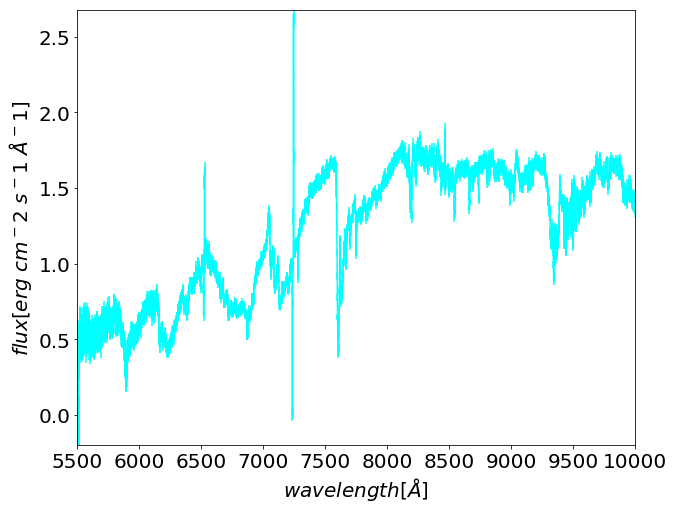

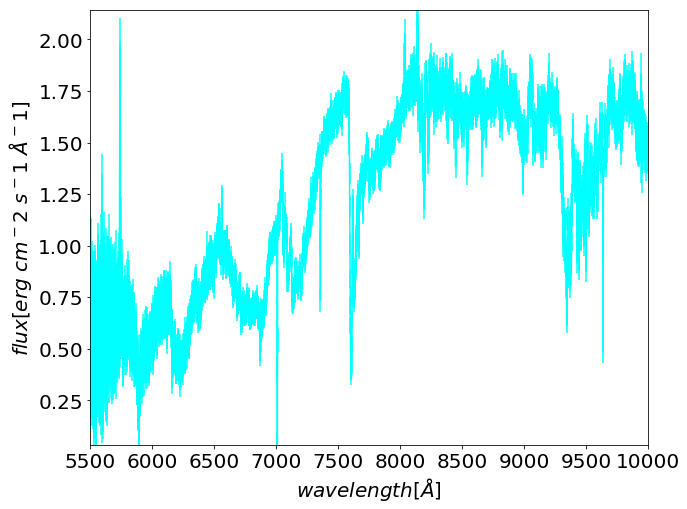

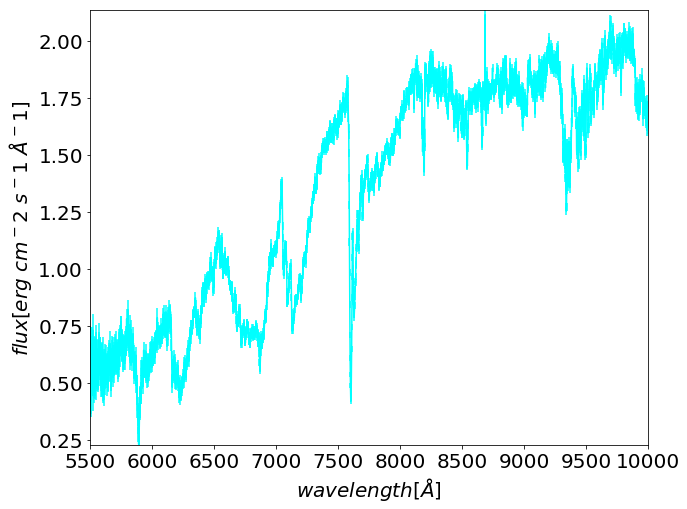

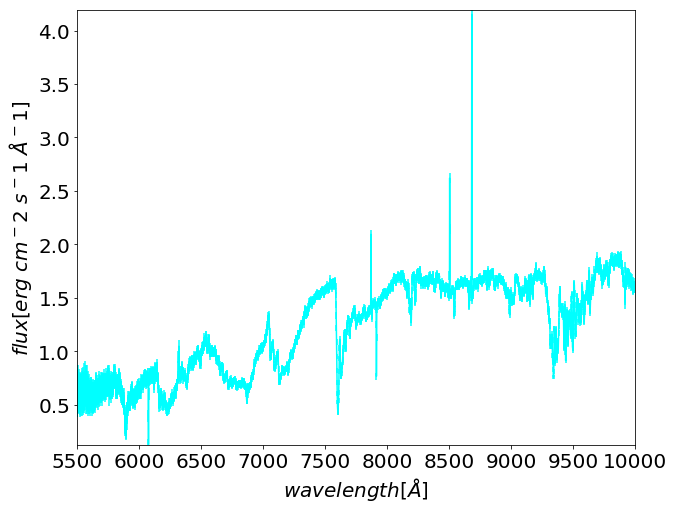

In [9]:
w,f,v = read_mdm('/Users/amandaash/Desktop/Research/data/CSCU_reductions/20180113/finals/trim.JS281.1.fits')
norm_reg = (w>6565) & (w<6575)
norm_by = np.median(f[norm_reg])
plot_spec(w,f/norm_by,v/norm_by,ax=None,wmin=5500,wmax=10000)
w,f,v = read_mdm('/Users/amandaash/Desktop/Research/data/CSCU_reductions/20180115/finals/trim.JS281.1.fits')
norm_reg = (w>6565) & (w<6575)
norm_by = np.median(f[norm_reg])
plot_spec(w,f/norm_by,v/norm_by,ax=None,wmin=5500,wmax=10000)
w,f,v = read_mdm('/Users/amandaash/Desktop/Research/data/CSCU_reductions/20180117/finals/trim.JS281.1.fits')
norm_reg = (w>6565) & (w<6575)
norm_by = np.median(f[norm_reg])
plot_spec(w,f/norm_by,v/norm_by,ax=None,wmin=5500,wmax=10000)
w,f,v = read_mdm('/Users/amandaash/Desktop/Research/data/CSCU_reductions/20180119/finals/trim.JS281.1.fits')
norm_reg = (w>6565) & (w<6575)
norm_by = np.median(f[norm_reg])
plot_spec(w,f/norm_by,v/norm_by,ax=None,wmin=5500,wmax=10000)

JS473 8 exposures over 8 days : success
JS561 7 exposures over 7 days : success
JS267 7 exposures over 7 days : success
AD4269 6 exposures over 6 days : success
A575 17 exposures over 17 days : success
JS455 17 exposures over 17 days : success
08403953+1849 6 exposures over 6 days : success
JS536 11 exposures over 9 days : success
JS457 10 exposures over 9 days : success
JS301 10 exposures over 9 days : success
KW563 13 exposures over 11 days : success
JS468 10 exposures over 9 days : success
JS315 37 exposures over 18 days : success
JS391 27 exposures over 13 days : success
JS414 27 exposures over 14 days : success
JS441 25 exposures over 12 days : success
JS283 15 exposures over 11 days : success
HSHJ272 27 exposures over 13 days : success
JS706 15 exposures over 7 days : success
JC143 17 exposures over 8 days : success
JS281 19 exposures over 10 days : success


KeyboardInterrupt: 

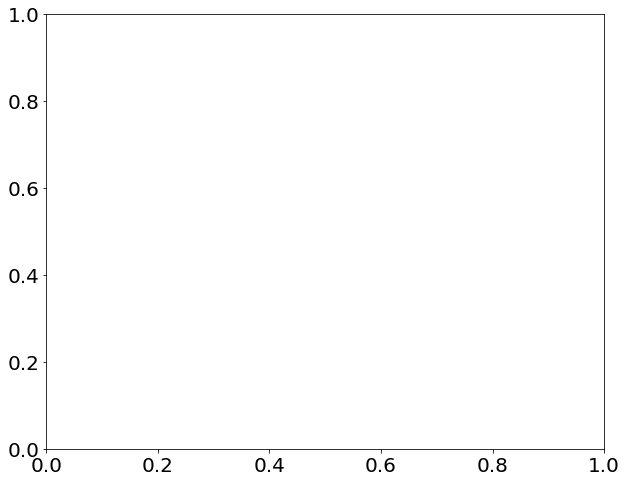

In [10]:
#Plot all of the OSMOS targets

days=[20171215, 20180111,20180112,20180113,20180114,20180115,20180116,20180117,20180118,20180119,20180120,20180121,
      20180122,20180123,20180124,20180125,20180126,20180127,20180128,20180204,20180205,20180206,20180207,
      20180208,20180209]

import csv
import glob as glob
target_list = []
with open('/Users/amandaash/Desktop/Research/data/all_target_names.csv', 'r') as csvFile:
    target_data = csv.reader(csvFile)
    for row in target_data:
        target_list.append(row[1])
csvFile.close()

targets = target_list[2:]

for file in targets:
    
    overplot(file, days, True, True, False, True)

In [ ]:
#morris spectra: EPIC 211928486
flist = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211928486/*'))

overplot = plt.figure(figsize=(10,8))
ax_multi_exposure = plt.subplot(111)
                    
for file in flist:
    star_name = "JS482"
    day = file.split('/')[8].split('_')[2].split('.')[0]
    file = np.genfromtxt(file)
    wavelength = file[:,0]
    flux = file[:,1]
    dat = np.column_stack((wavelength, flux))
    
    cont_flux = []
    
    wmin = 6540
    wmax = 6580
    
    for a in dat: 
        if a[0]>=6558 and a[0]<=6562:
            cont_flux.append(a[1])
        if a[0]>=6566 and a[0]<=6569:
            cont_flux.append(a[1])
    
    err = np.std(cont_flux)
    errs = [err] * len(list(flux))
    
    norm_reg = (wavelength>6565) & (wavelength<6576)
    norm_by = np.median(flux[norm_reg])
    
    wreg = (wavelength<=wmax) & (wavelength>=wmin)
    

    fmin,fmax = np.min(flux[wreg])*0.99,np.max(flux[wreg])*1.01
    single_spectra = plt.figure(figsize=(10,8))
    single_ax = plt.subplot(111)
    single_ax.set_ylim(fmin,fmax)
    single_ax.set_xlim(wmin,wmax)    
    single_ax.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)
    single_ax.set_xlabel('wavelength')
    single_ax.set_ylabel('flux')
    single_ax.set_title(star_name + ' ' + day)
    single_ax.axvline(x = 6563, color = '#045FB4',linestyle = 'dashed')
    single_ax.axvline(x = 6560, color = '#3A01DF', linestyle = 'dashed')
    single_ax.axvline(x = 6566, color = '#3A01DF', linestyle = 'dashed')
    single_spectra.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/single_exposures/{0}_{1}.pdf'.format(star_name,day))
    plt.close()
    day_spectra = plt.figure(figsize=(10,8))
    day_spectra = plt.figure(figsize=(10,8))
    day_ax = plt.subplot(111)
    day_ax.set_ylim(fmin,fmax)
    day_ax.set_xlim(wmin,wmax)    
    day_ax.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)
    day_ax.set_xlabel('wavelength')
    day_ax.set_ylabel('flux')
    day_ax.set_title(star_name + ' ' + day)
    day_ax.axvline(x = 6563, color = '#045FB4',linestyle = 'dashed')
    day_spectra.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/day_exposures/{0}_{1}.pdf'.format(star_name,day))
    plt.close()
    
    ax_multi_exposure.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)

ax_multi_exposure.set_xlabel('wavelength')
ax_multi_exposure.set_ylabel('flux')
ax_multi_exposure.axvline(x = 6563, color = 'k',linestyle = 'dashed')
ax_multi_exposure.set_title(star_name)
ax_multi_exposure.set_xlim(6540,6580)
ax_multi_exposure.set_ylim(fmin, fmax)
overplot.show()
overplot.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/overplot/{0}_spectra.pdf'.format(star_name))
    

In [ ]:
#morris spectra: EPIC 211966629
flist = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211966629/*'))

overplot = plt.figure(figsize=(10,8))
ax_multi_exposure = plt.subplot(111)
                    
for file in flist:
    star_name = "JS556"
    day = file.split('/')[8].split('_')[2].split('.')[0]
    file = np.genfromtxt(file)
    wavelength = file[:,0]
    flux = file[:,1]
    dat = np.column_stack((wavelength, flux))
    
    cont_flux = []
    
    wmin = 6540
    wmax = 6580
    
    for a in dat: 
        if a[0]>=6558 and a[0]<=6562:
            cont_flux.append(a[1])
        if a[0]>=6566 and a[0]<=6569:
            cont_flux.append(a[1])
    
    err = np.std(cont_flux)
    errs = [err] * len(list(flux))
    
    norm_reg = (wavelength>6565) & (wavelength<6576)
    norm_by = np.median(flux[norm_reg])
    
    wreg = (wavelength<=wmax) & (wavelength>=wmin)
    

    fmin,fmax = np.min(flux[wreg])*0.99,np.max(flux[wreg])*1.01
    single_spectra = plt.figure(figsize=(10,8))
    single_ax = plt.subplot(111)
    single_ax.set_ylim(fmin,fmax)
    single_ax.set_xlim(wmin,wmax)    
    single_ax.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)
    single_ax.set_xlabel('wavelength')
    single_ax.set_ylabel('flux')
    single_ax.set_title(star_name + ' ' + day)
    single_ax.axvline(x = 6563, color = '#045FB4',linestyle = 'dashed')
    single_ax.axvline(x = 6560, color = '#3A01DF', linestyle = 'dashed')
    single_ax.axvline(x = 6566, color = '#3A01DF', linestyle = 'dashed')
    single_spectra.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/single_exposures/{0}_{1}.pdf'.format(star_name,day))
    plt.close()
    day_spectra = plt.figure(figsize=(10,8))
    day_spectra = plt.figure(figsize=(10,8))
    day_ax = plt.subplot(111)
    day_ax.set_ylim(fmin,fmax)
    day_ax.set_xlim(wmin,wmax)    
    day_ax.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)
    day_ax.set_xlabel('wavelength')
    day_ax.set_ylabel('flux')
    day_ax.set_title(star_name + ' ' + day)
    day_ax.axvline(x = 6563, color = '#045FB4',linestyle = 'dashed')
    day_spectra.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/day_exposures/{0}_{1}.pdf'.format(star_name,day))
    plt.close()
    
    ax_multi_exposure.errorbar(wavelength, flux/norm_by, yerr = errs/norm_by)

ax_multi_exposure.set_xlabel('wavelength')
ax_multi_exposure.set_ylabel('flux')
ax_multi_exposure.axvline(x = 6563, color = 'k',linestyle = 'dashed')
ax_multi_exposure.set_title(star_name)
ax_multi_exposure.set_xlim(6540,6580)
ax_multi_exposure.set_ylim(fmin, fmax)
overplot.show()
overplot.savefig('/Users/amandaash/Desktop/Research/plots/CSCU_reductions/overplot/{0}_spectra.pdf'.format(star_name))
    

In [11]:
#Altered plotting function to give full spectra and close up of Halpha
def plot_spec_wide_close(w,f,v,ax=None,wmin=6500,wmax=7500):
    
    if ax is None:
        plt.figure(figsize=(20,10))
        ax = plt.subplot(111)
    
    wreg = (w<=wmax) & (w>=wmin)
    
    ax.errorbar(w[wreg],f[wreg],v[wreg],capsize=0, color = '#4B088A')

    fmin,fmax = min(f[wreg])*0.99,max(f[wreg])*1.01
    ax.set_ylim(fmin,fmax)
    ax.set_xlim(wmin,wmax)    
    ax.set_xlabel(r"$wavelength [\AA]$")
    ax.set_ylabel(r"$flux [erg \ cm^-2 \ s^-1 \ \AA^-1]$")
    #plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


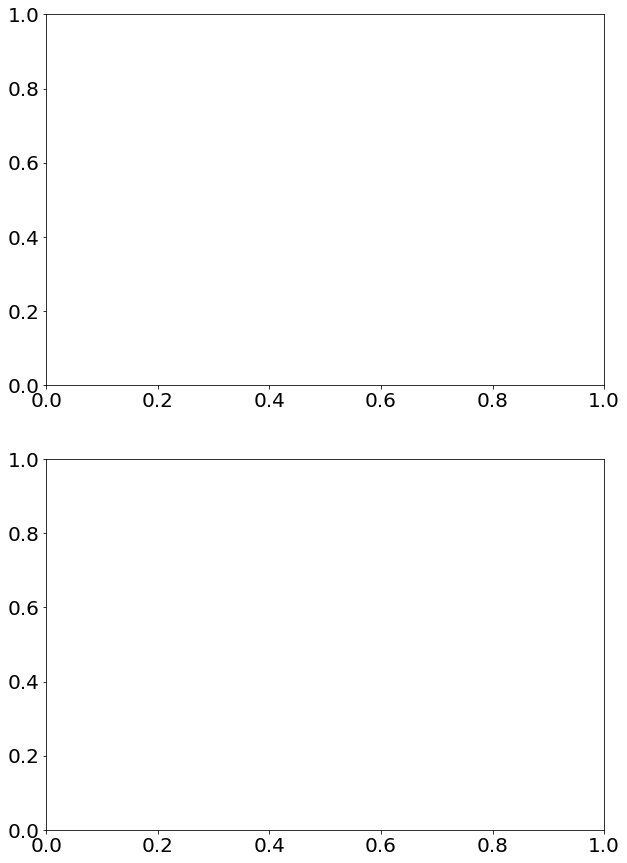

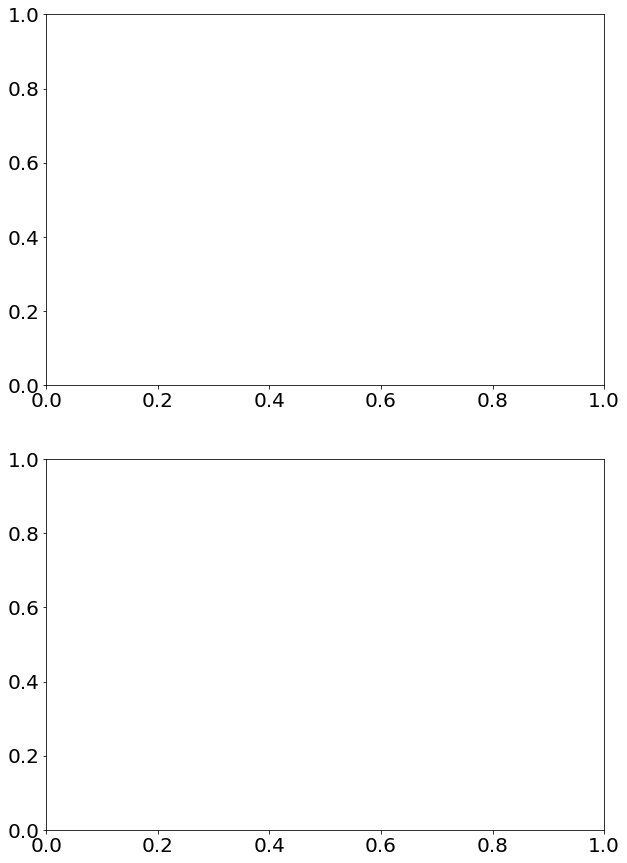

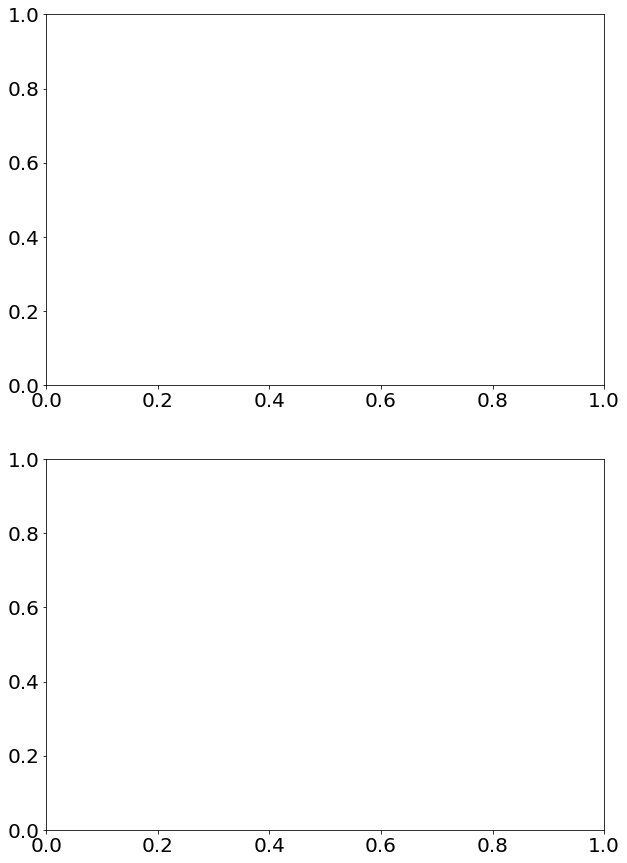

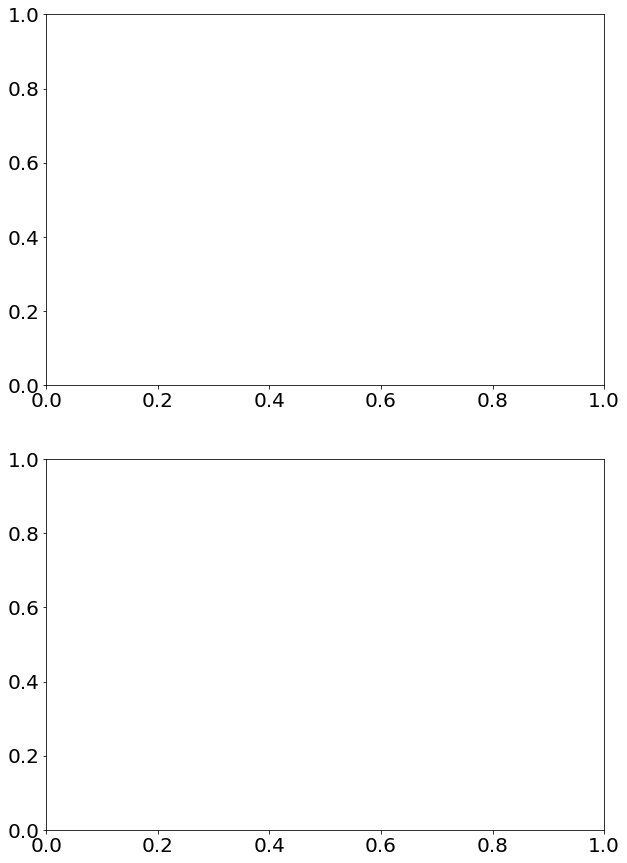

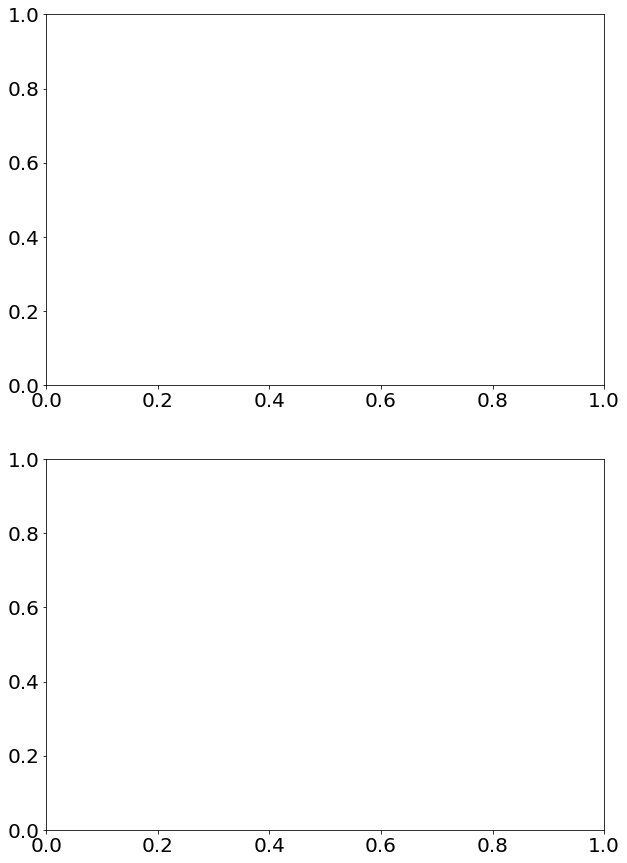

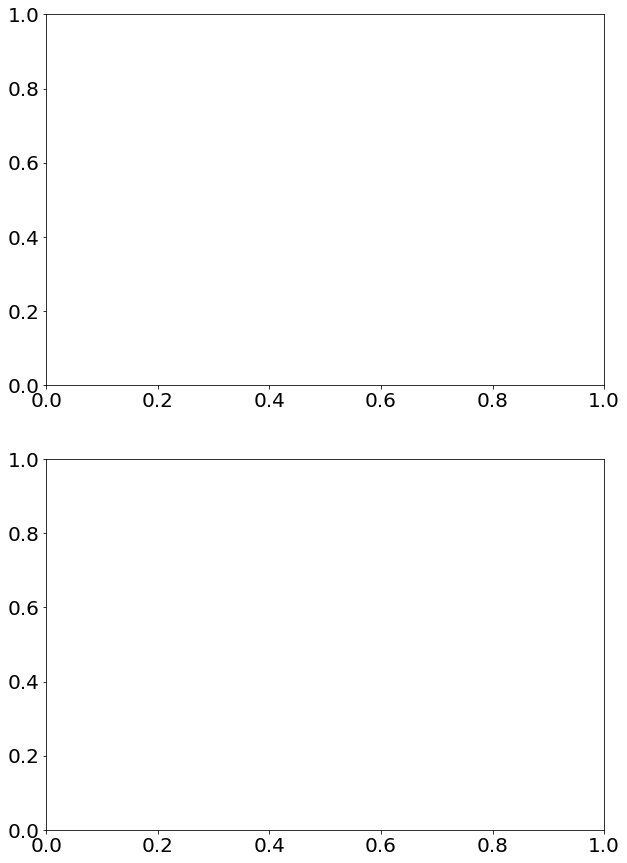

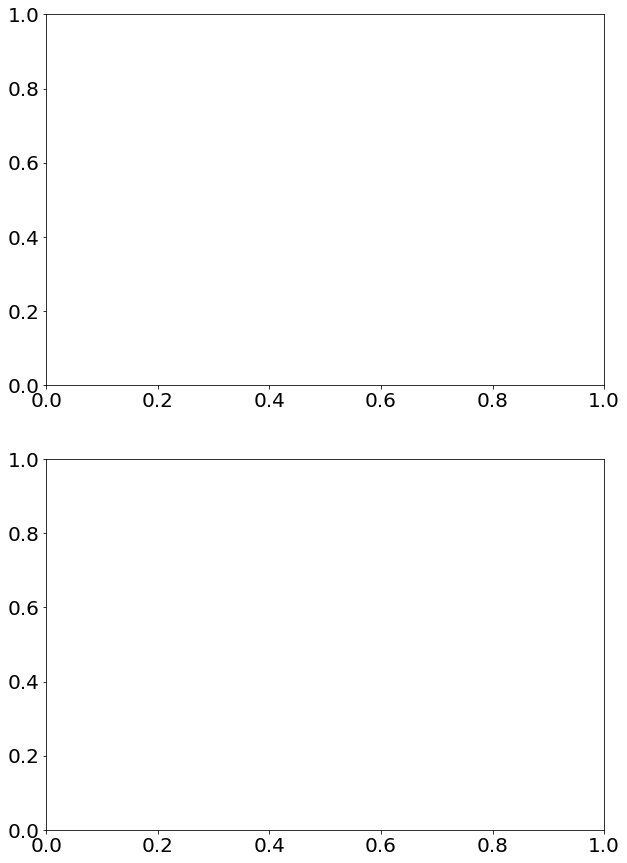

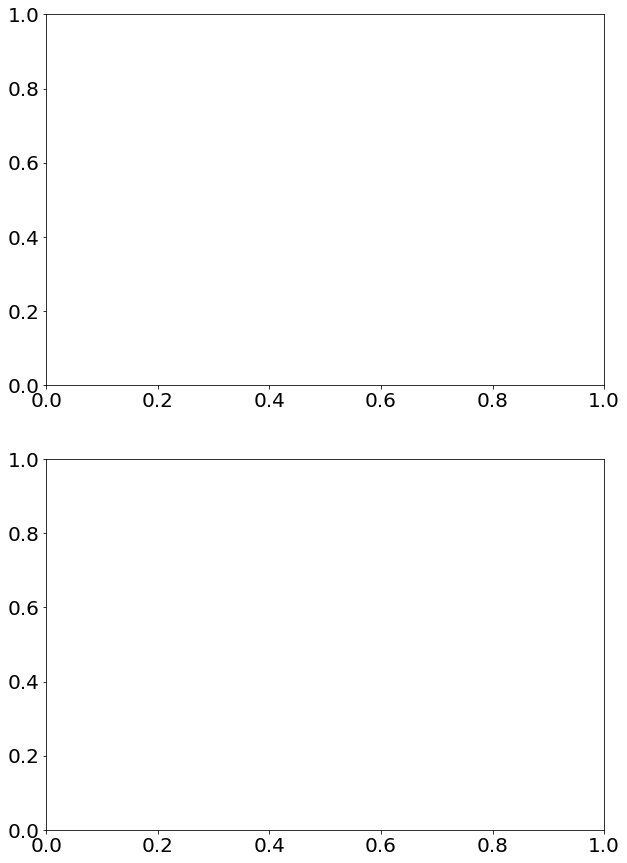

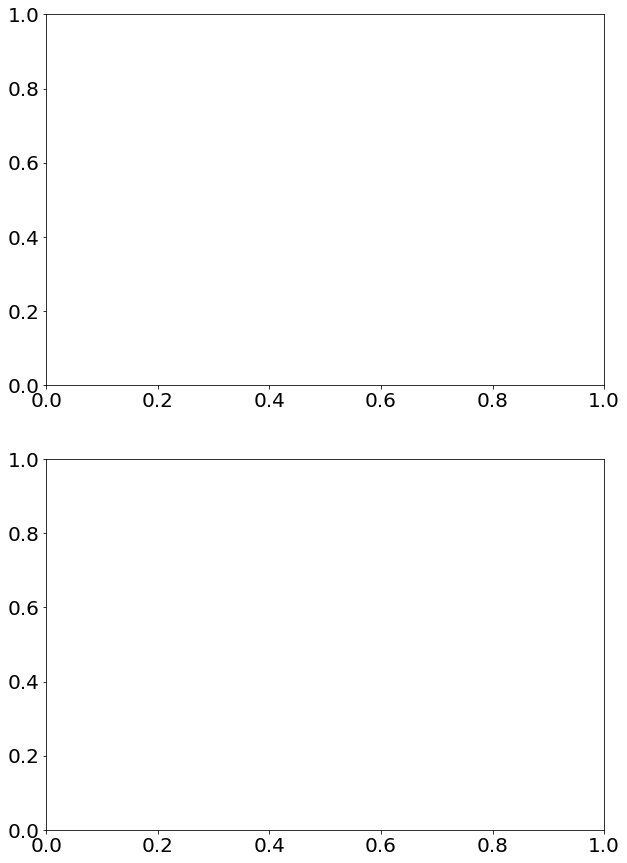

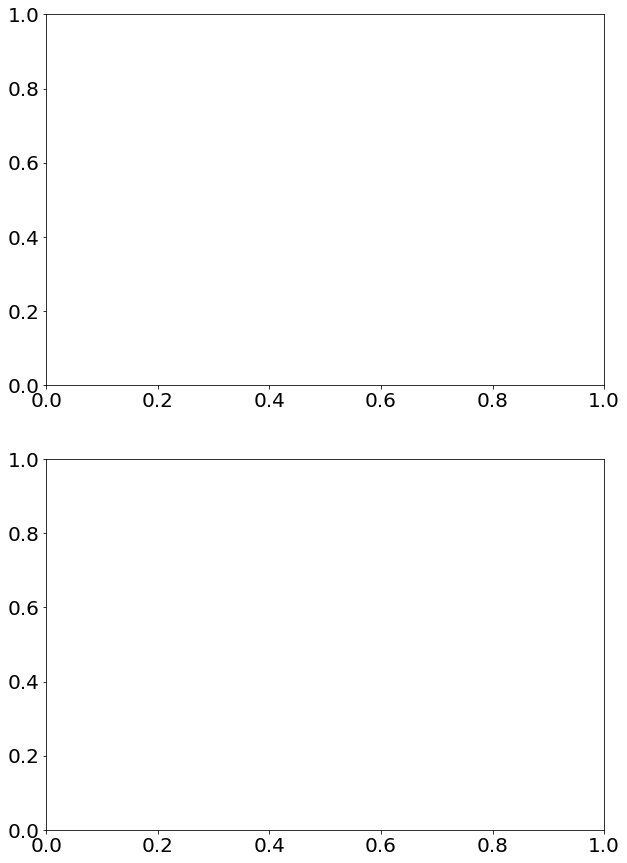

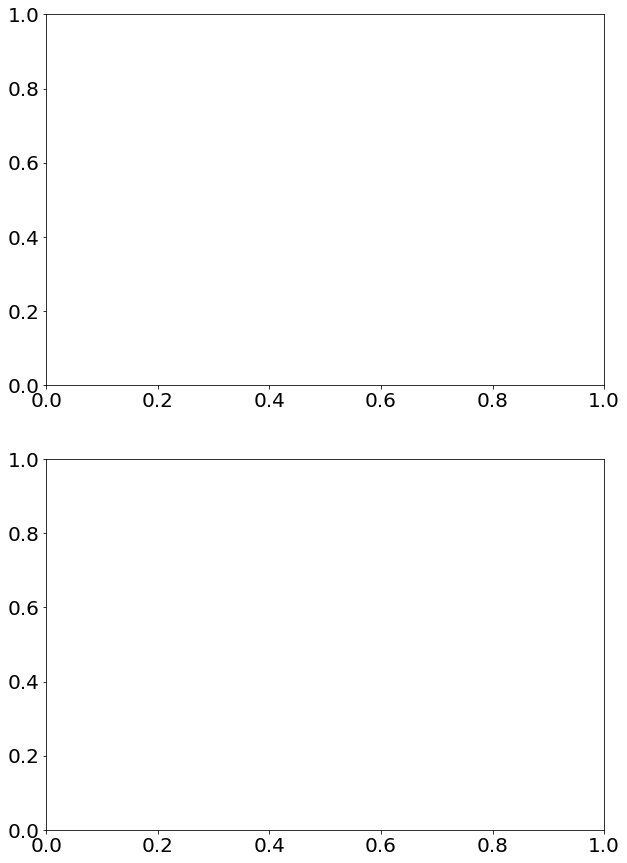

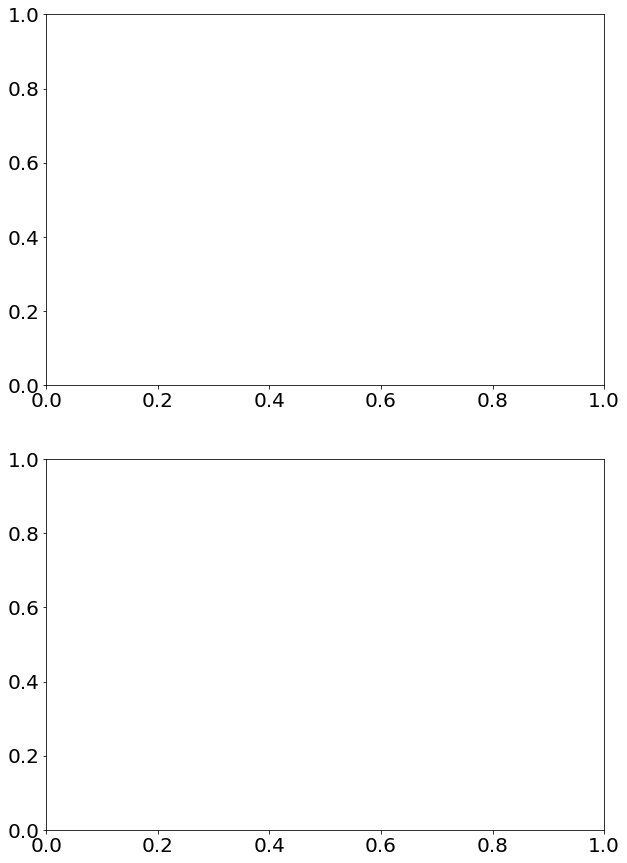

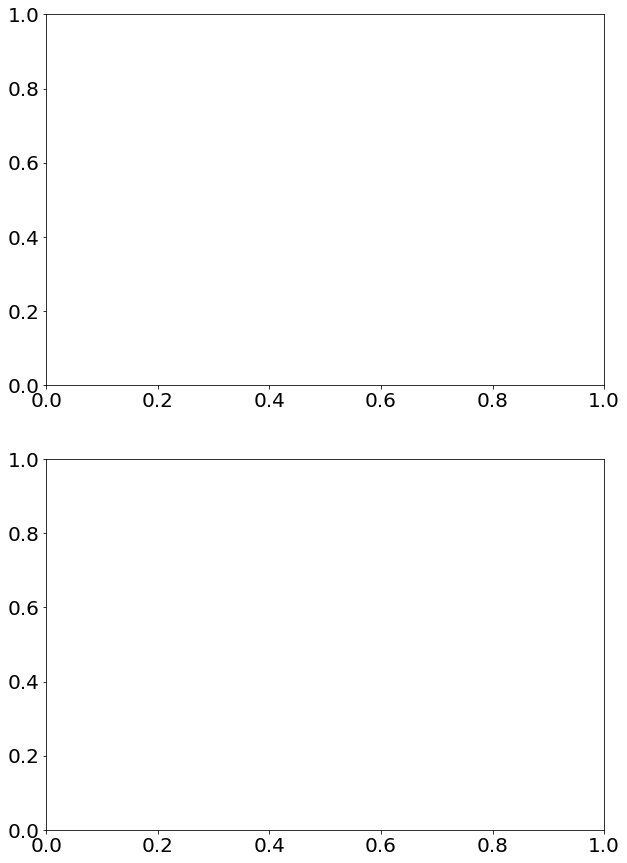

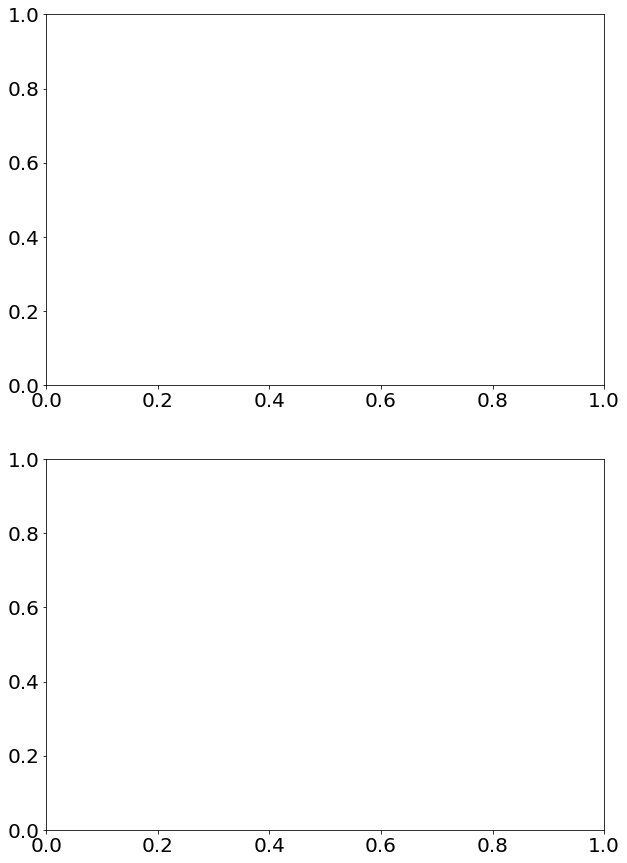

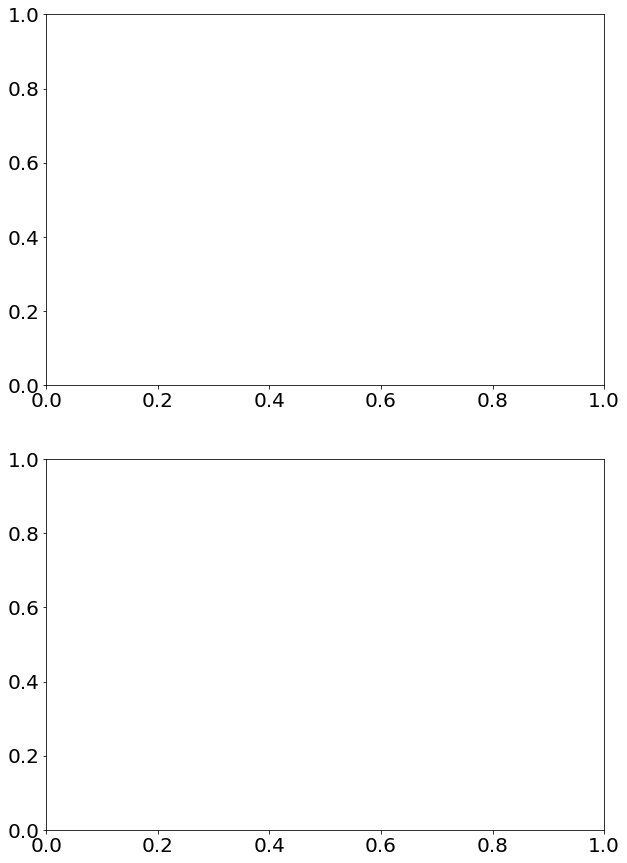

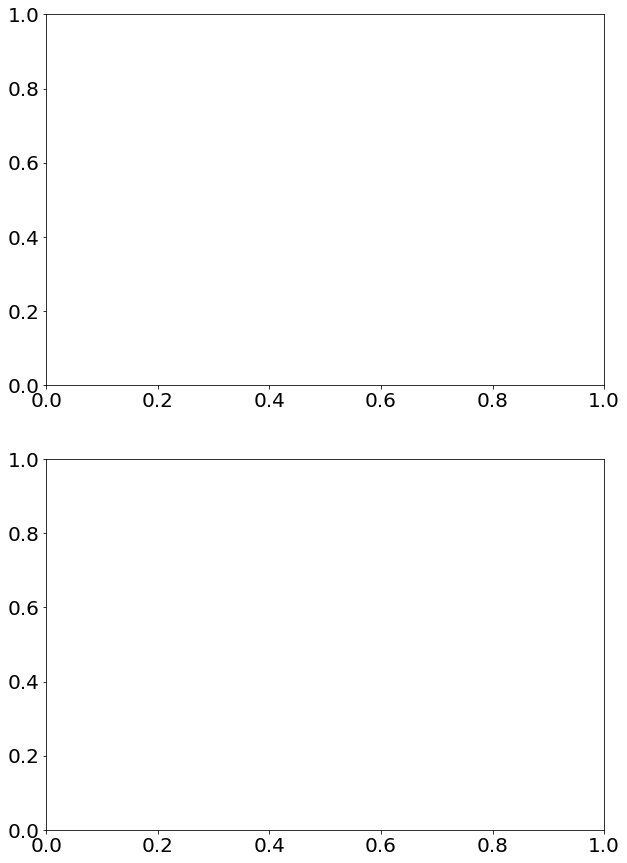

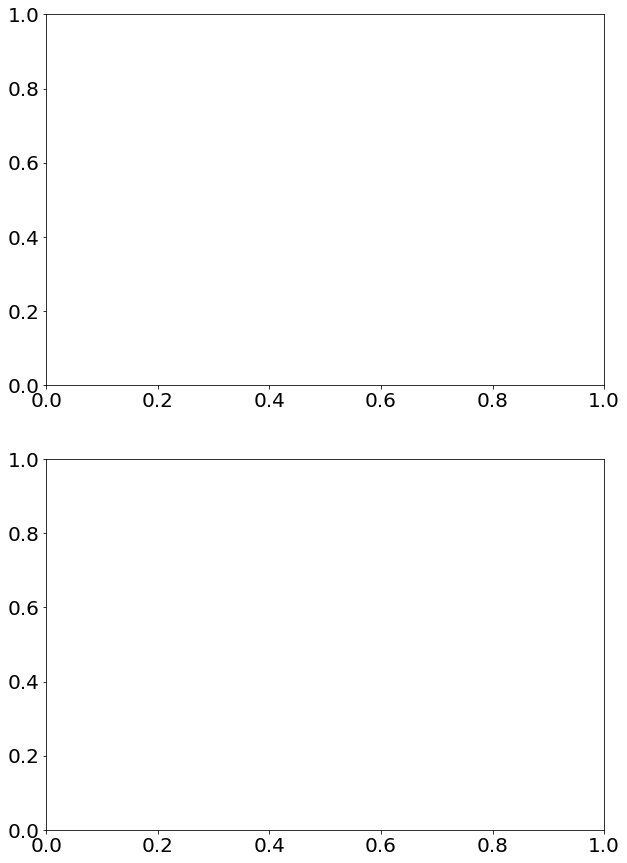

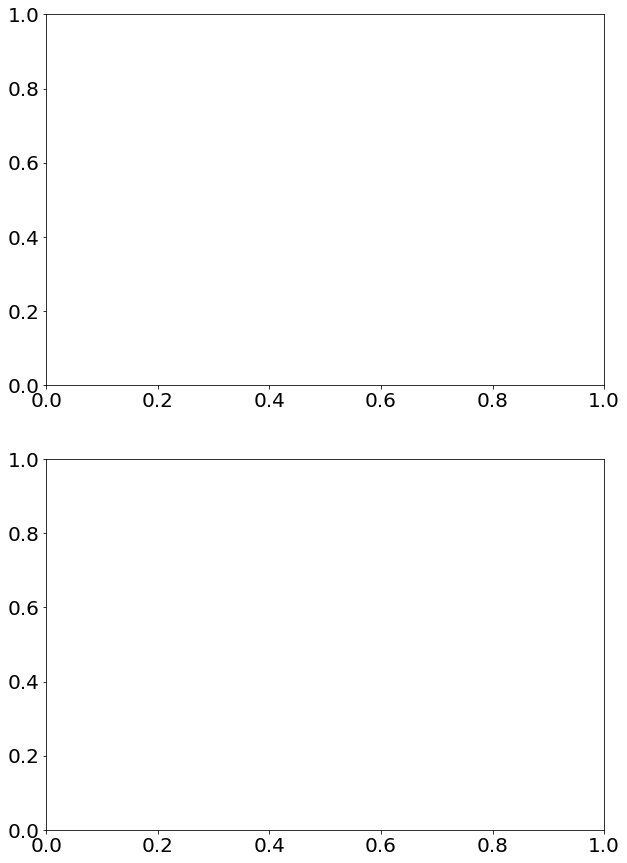

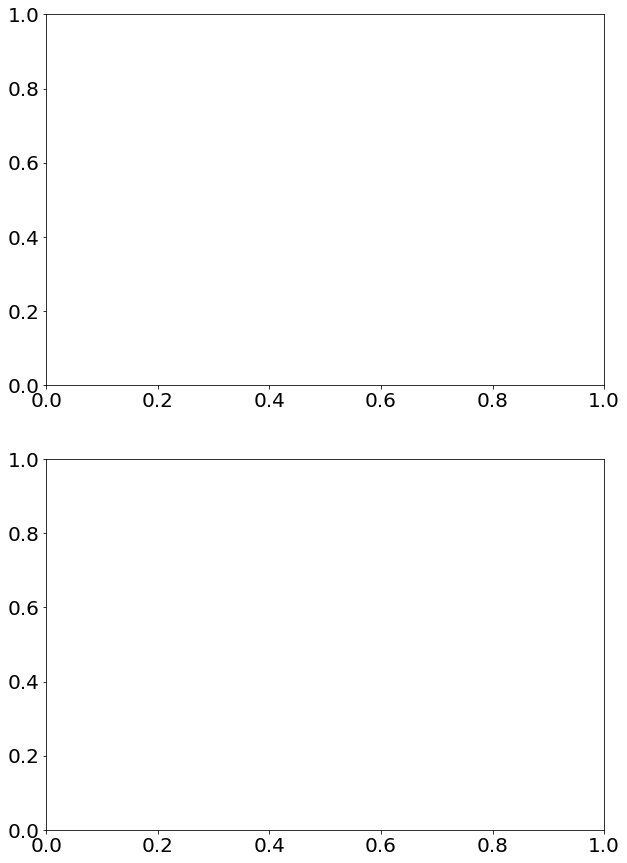

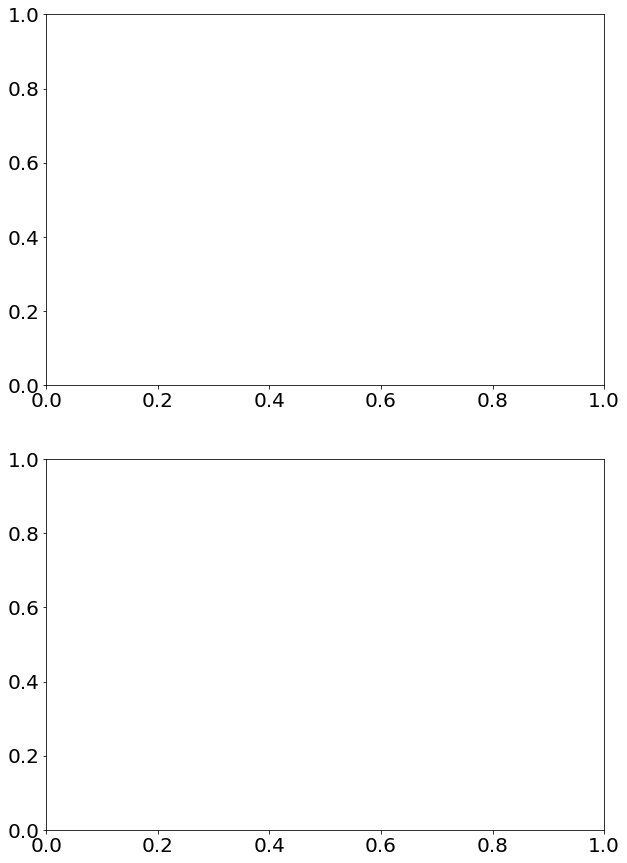

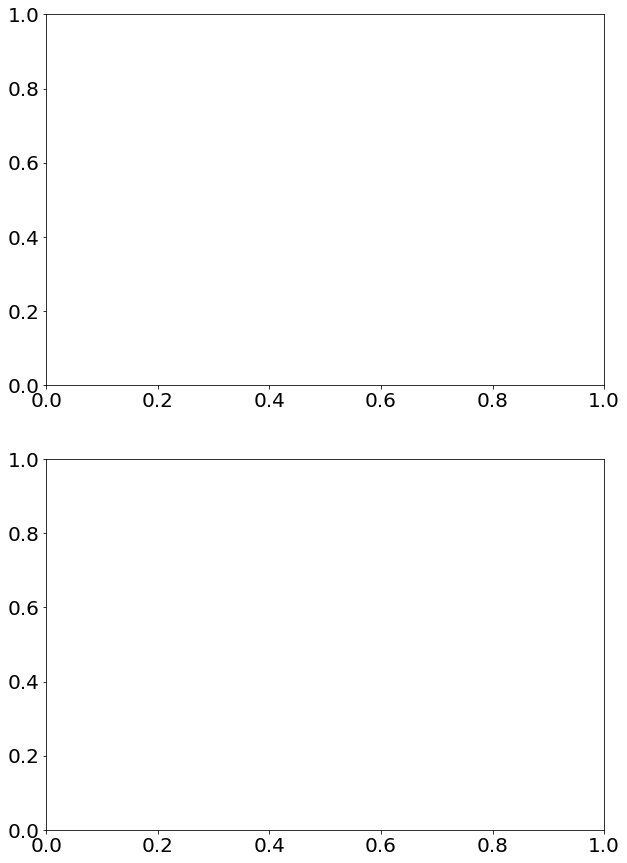

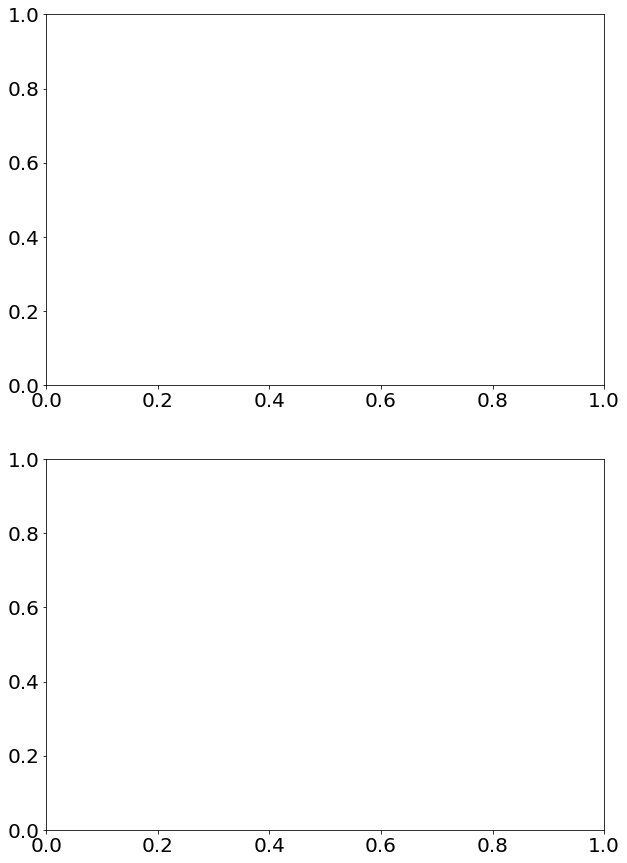

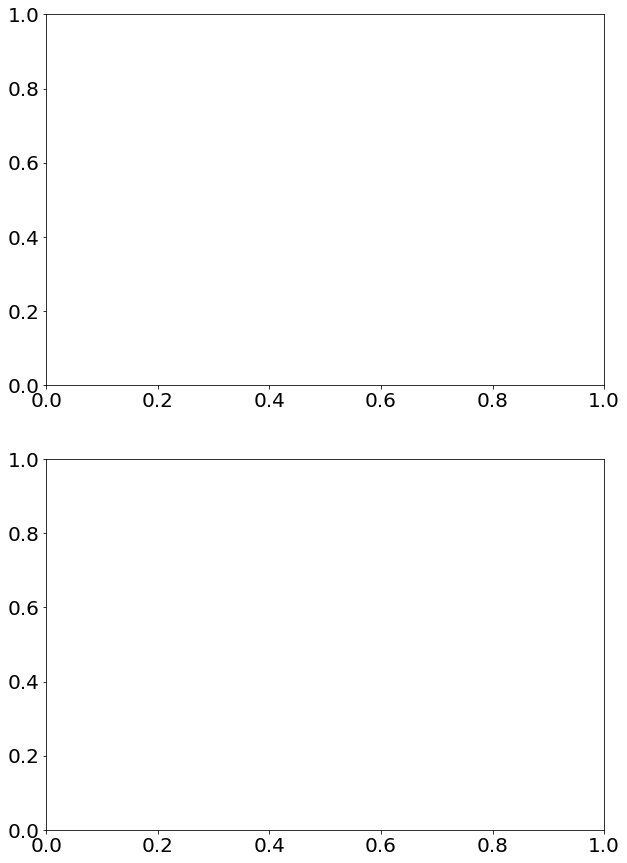

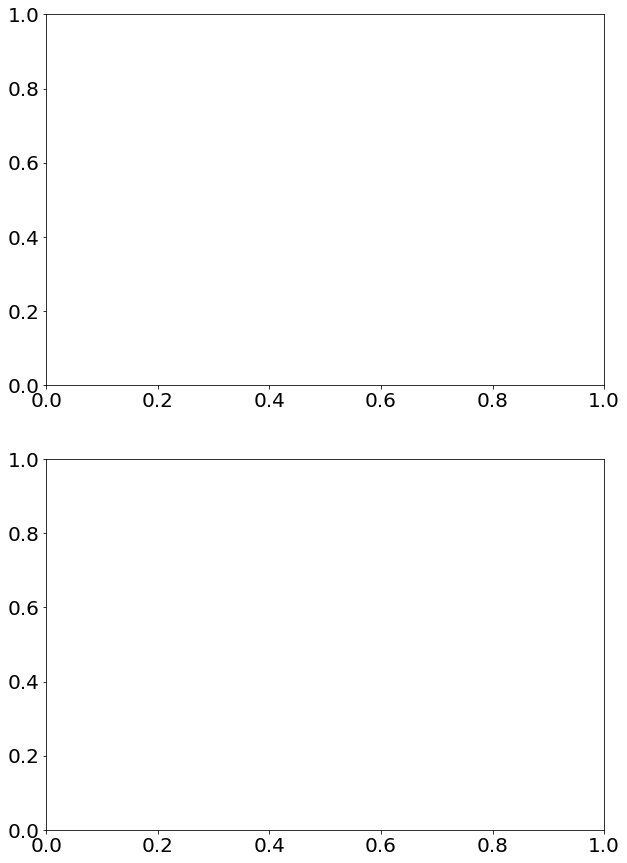

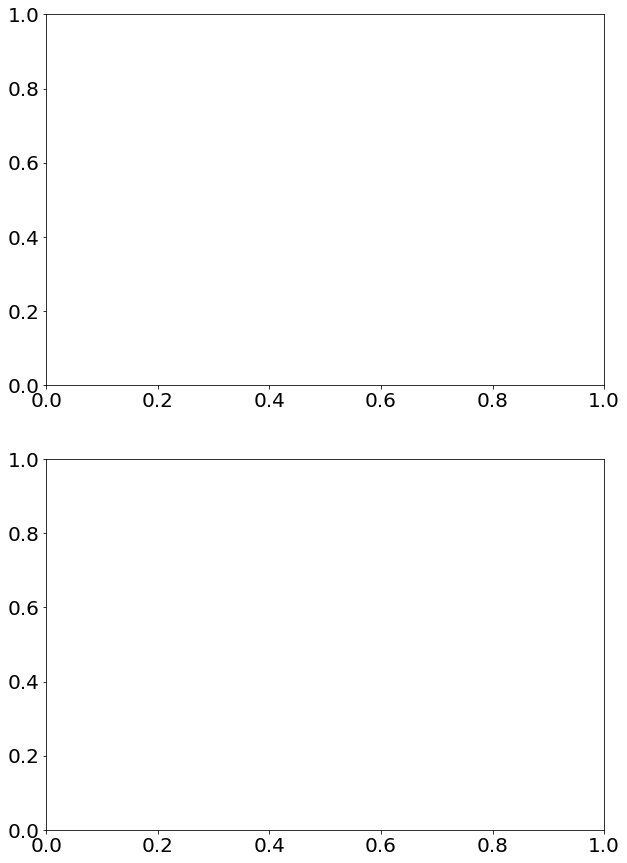

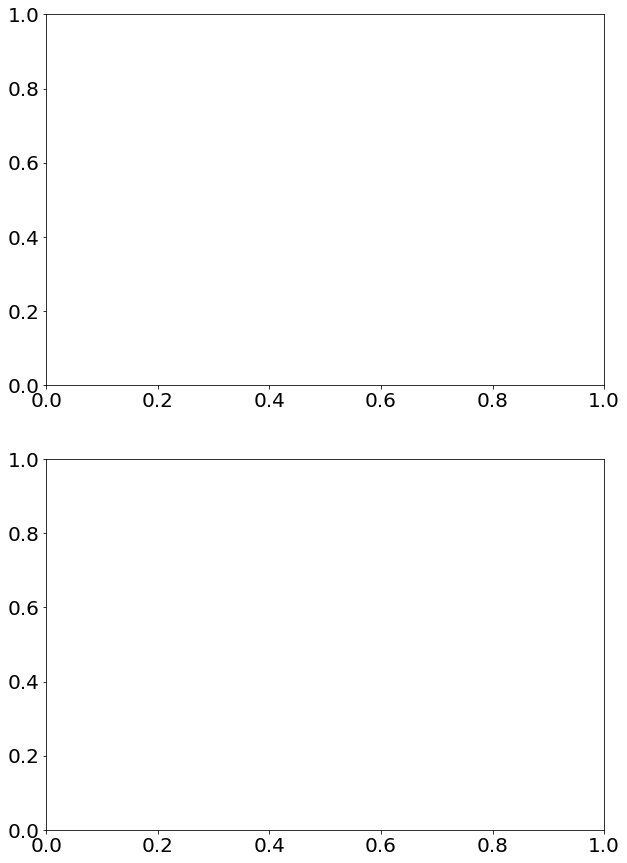

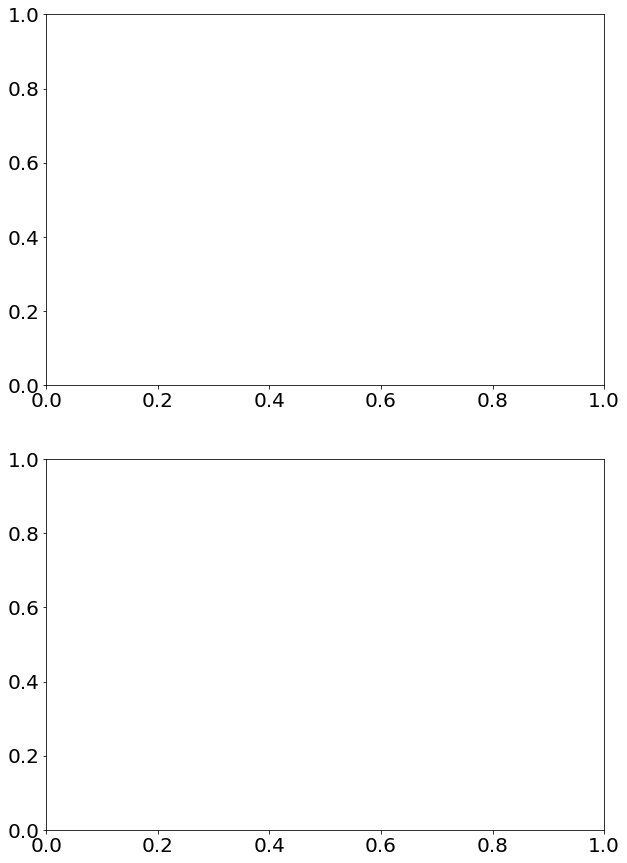

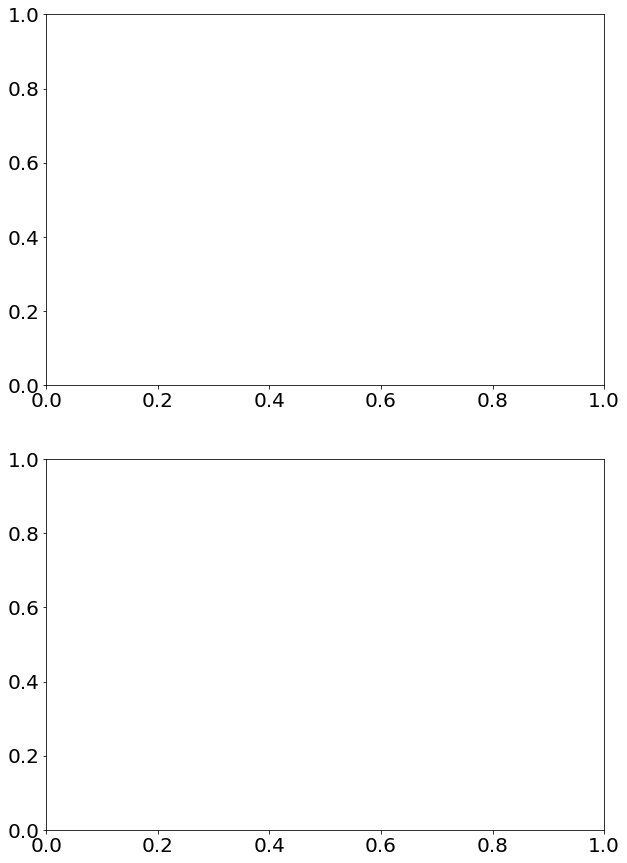

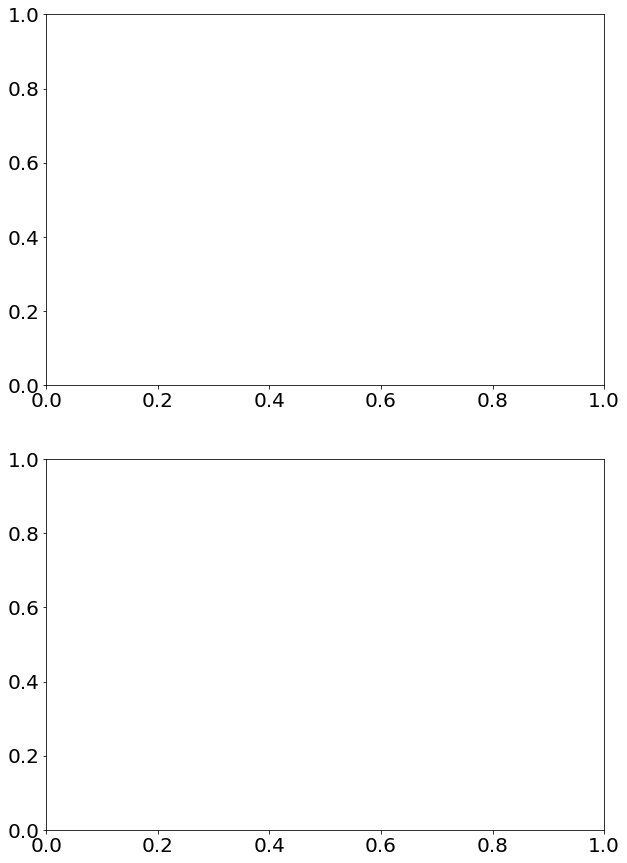

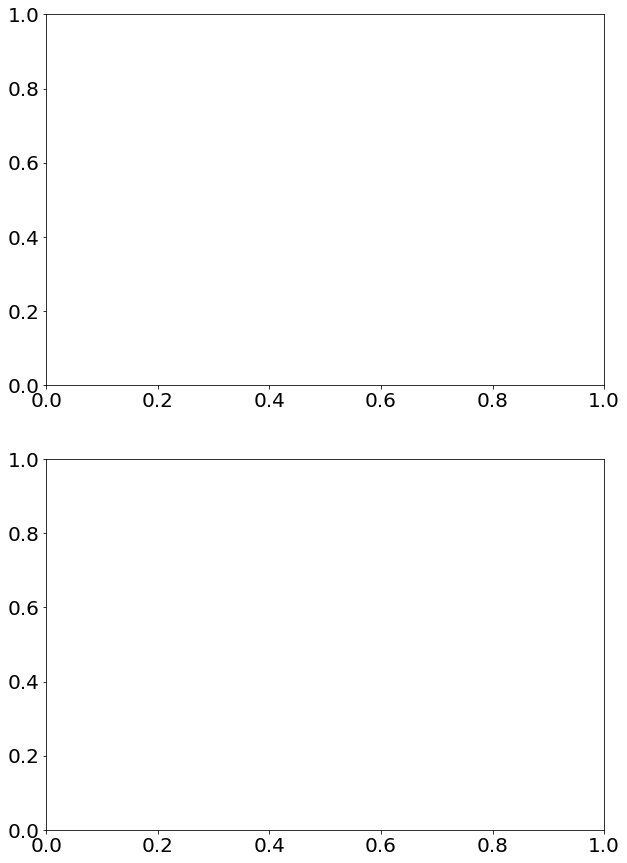

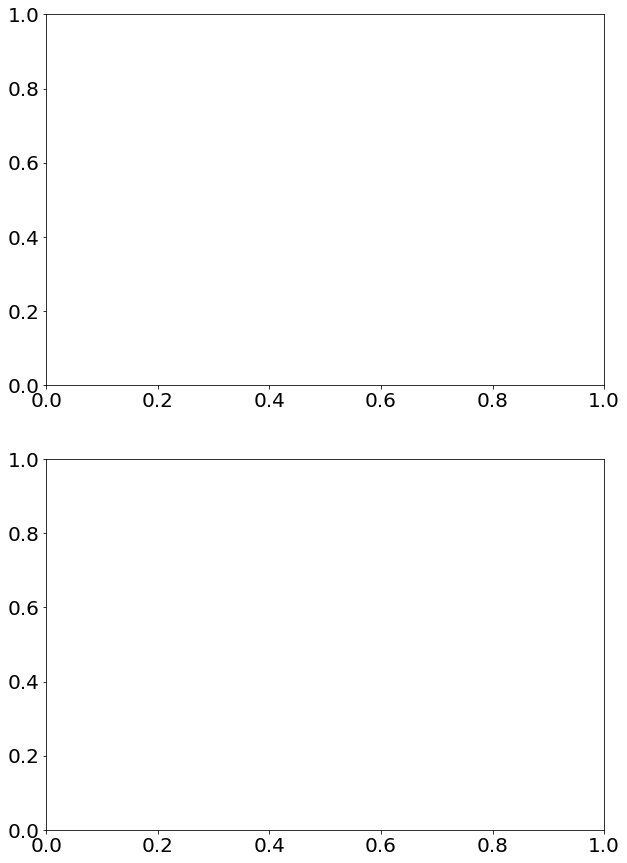

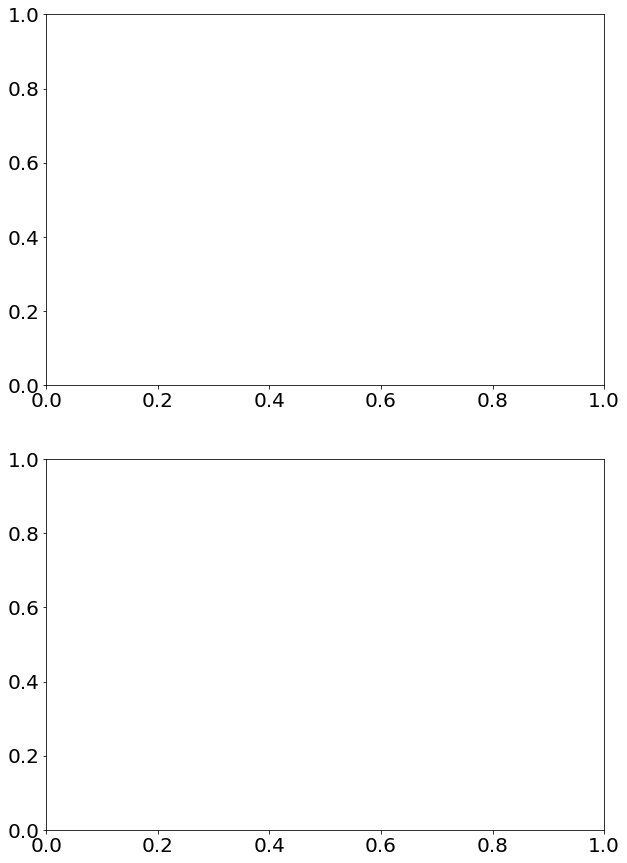

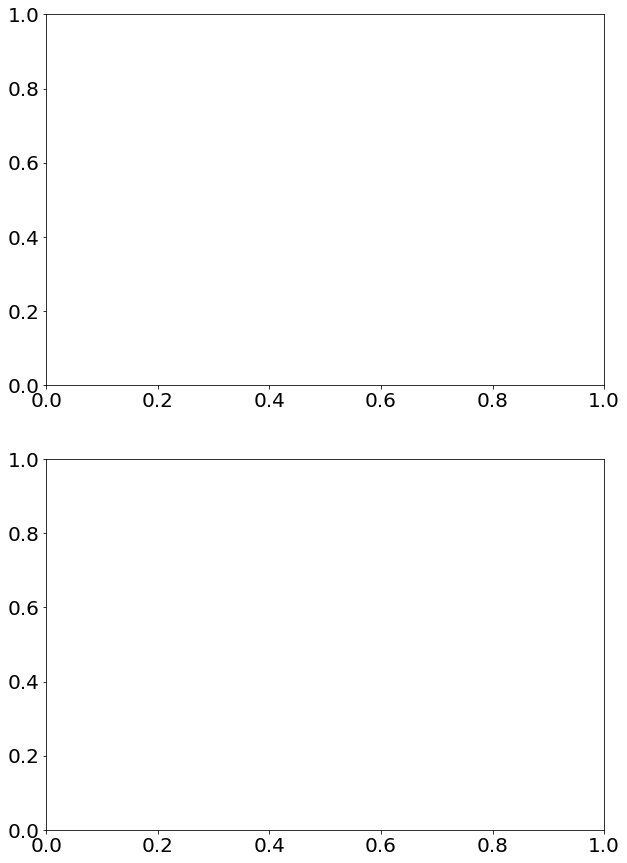

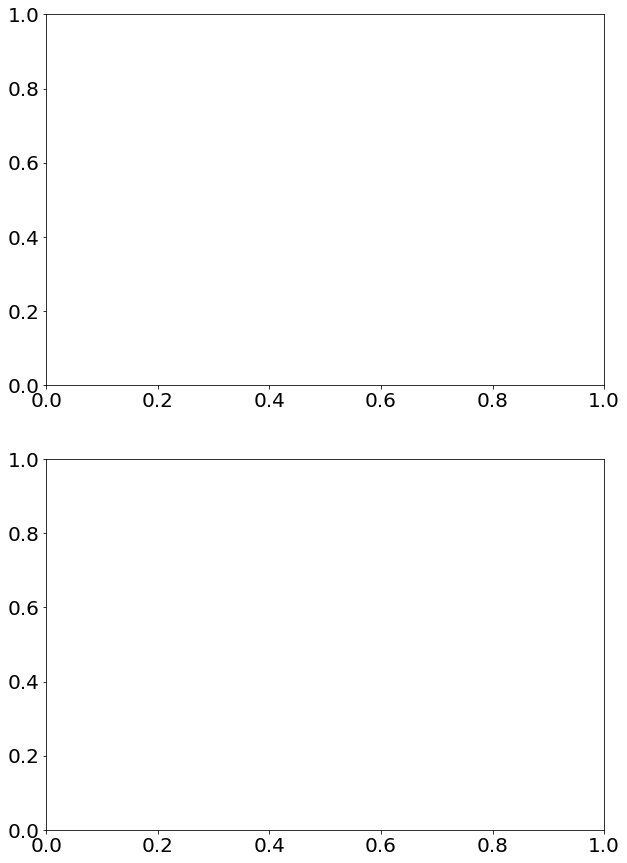

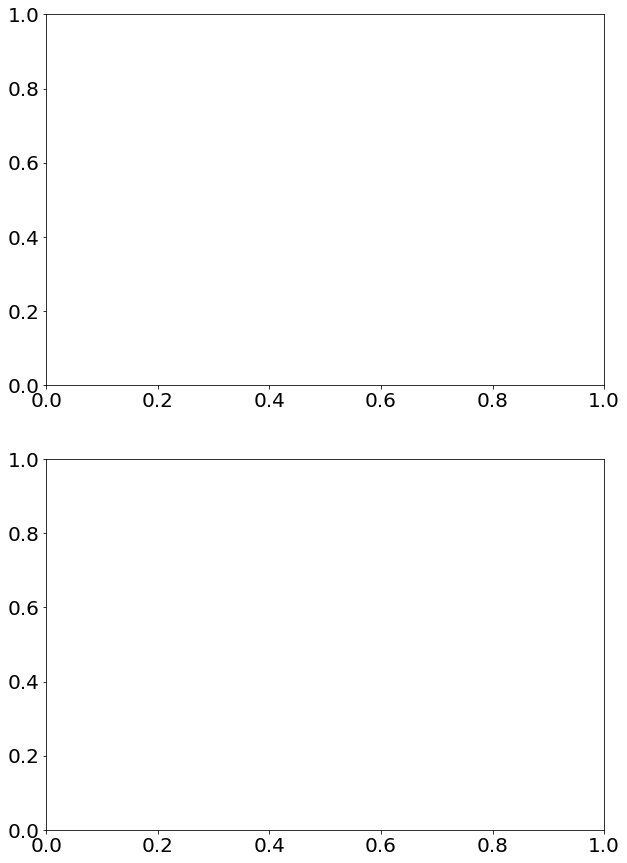

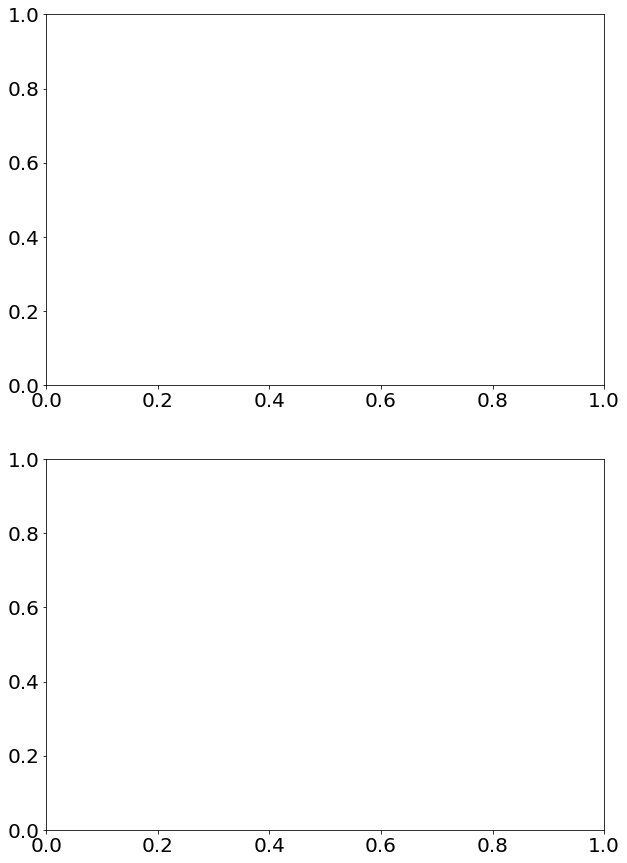

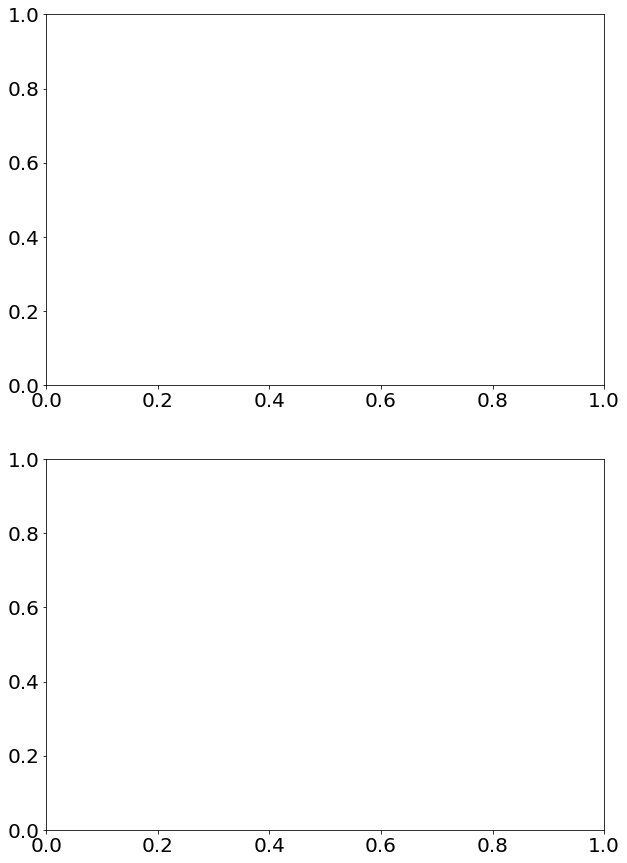

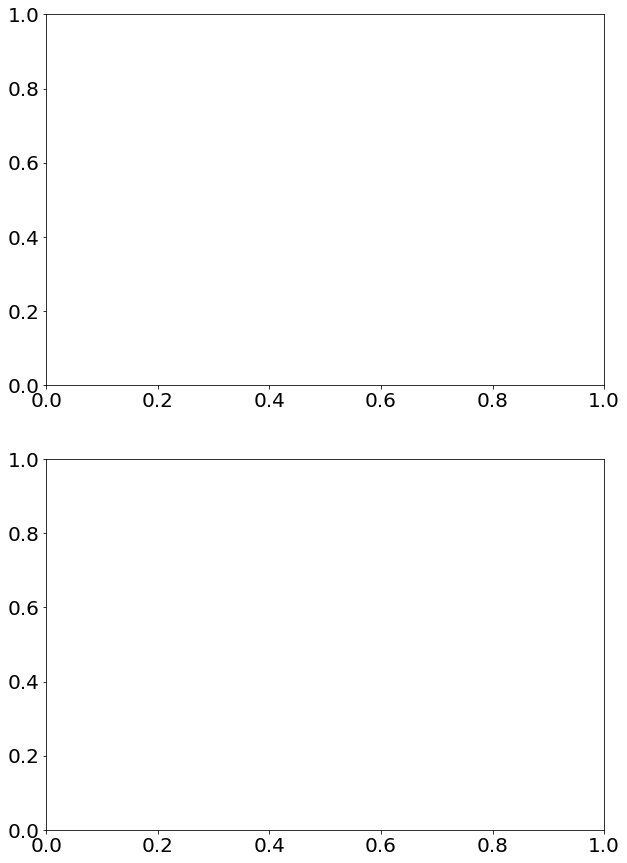

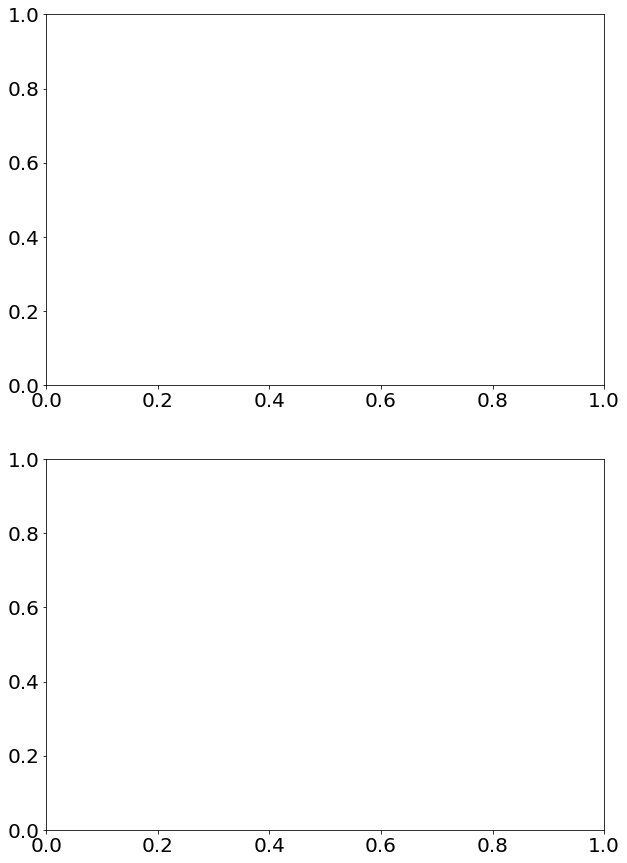

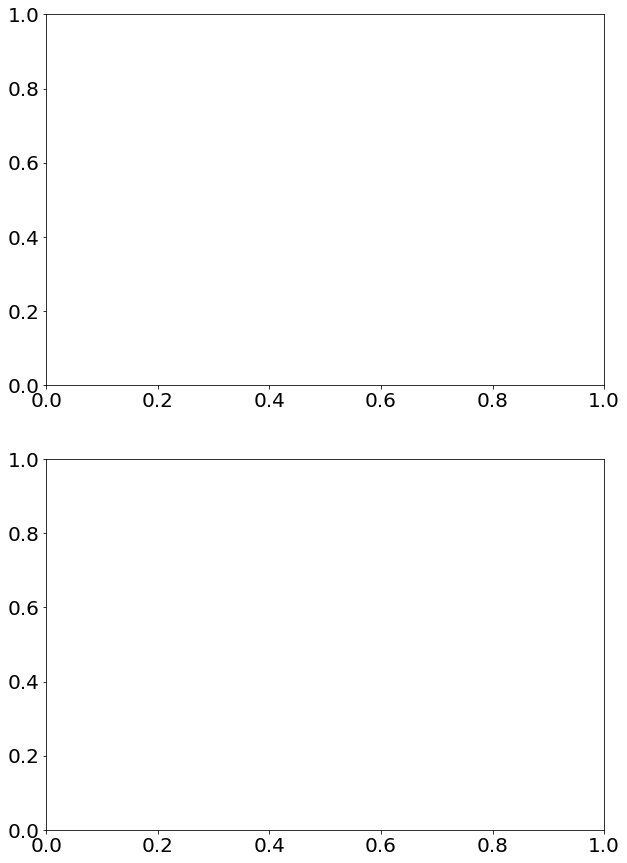

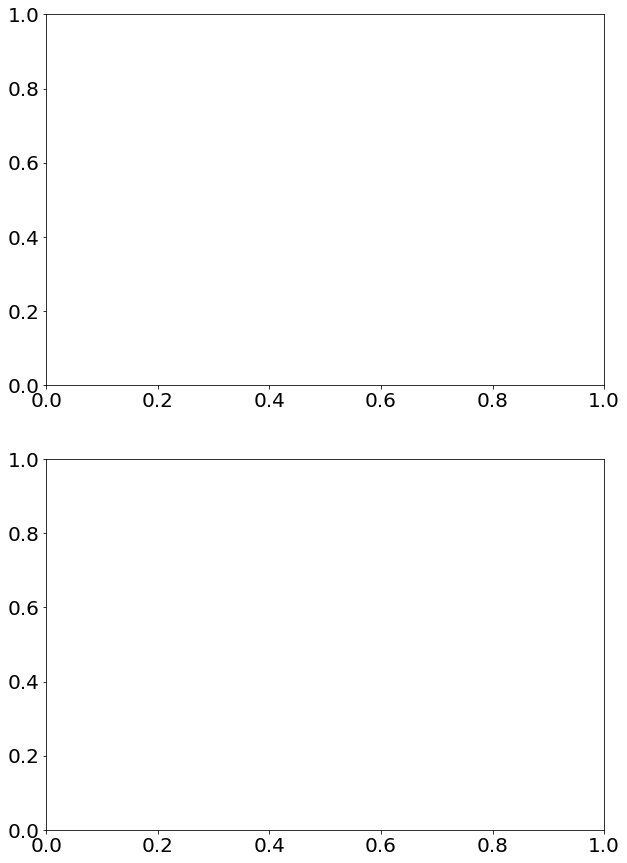

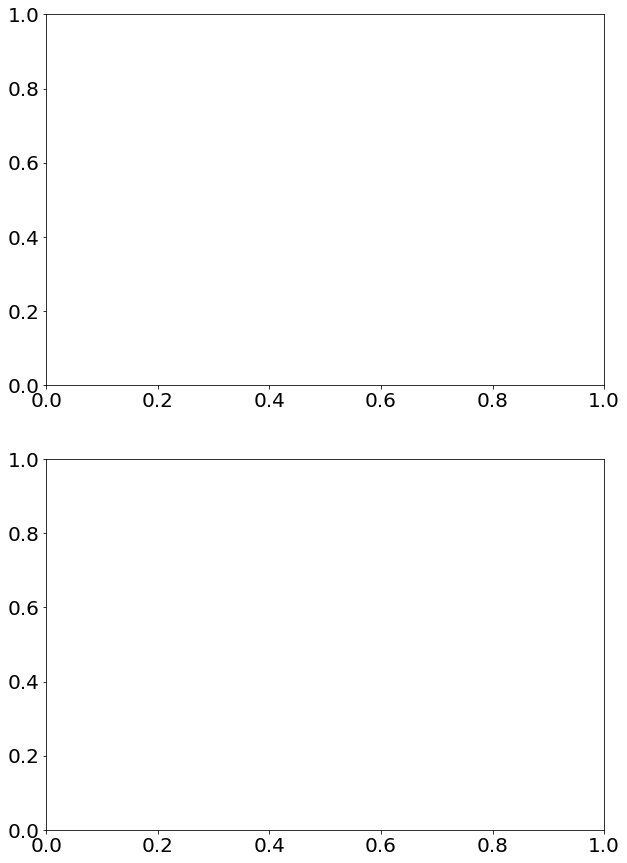

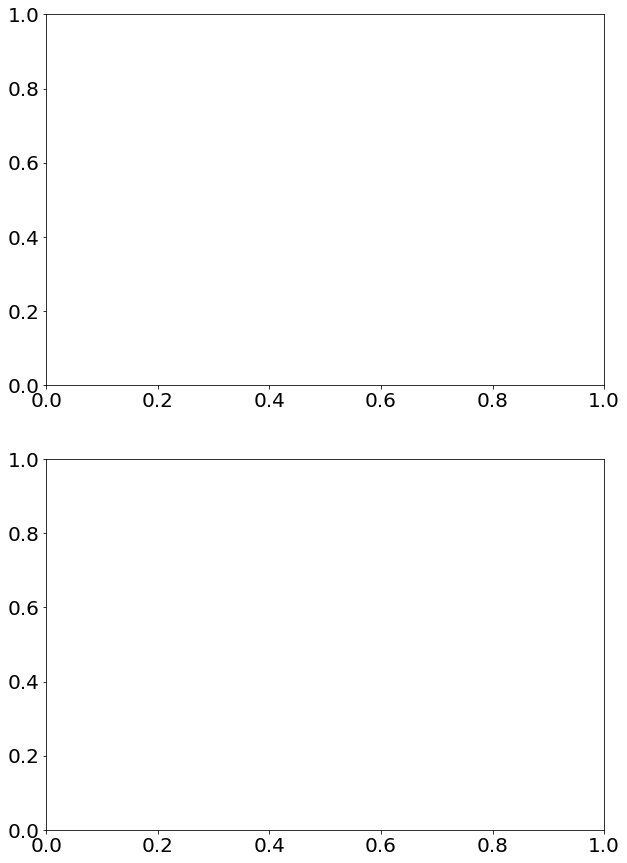

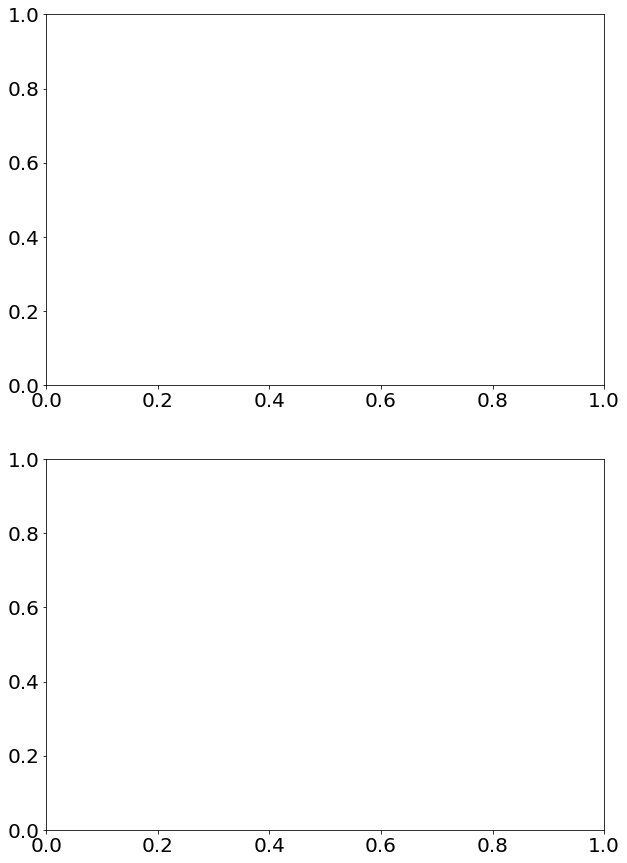

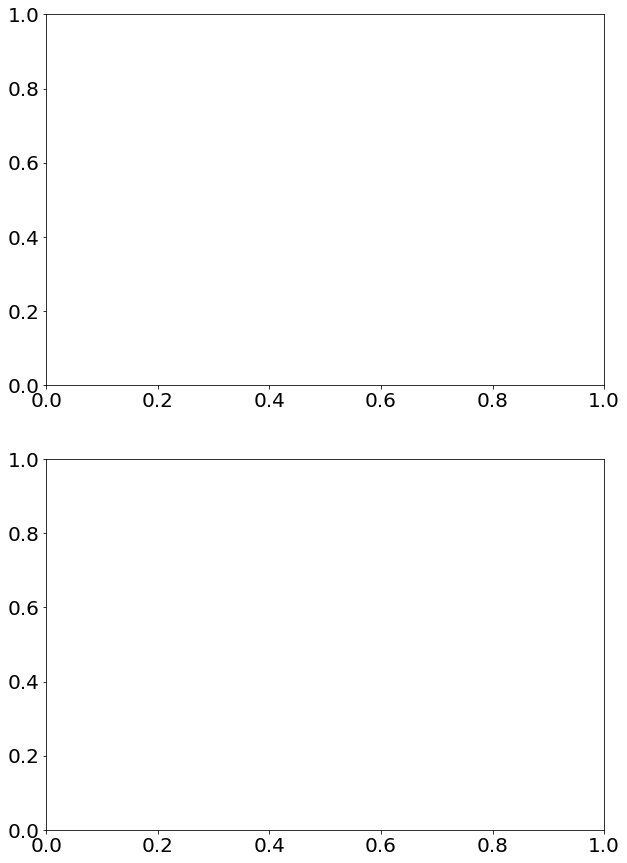

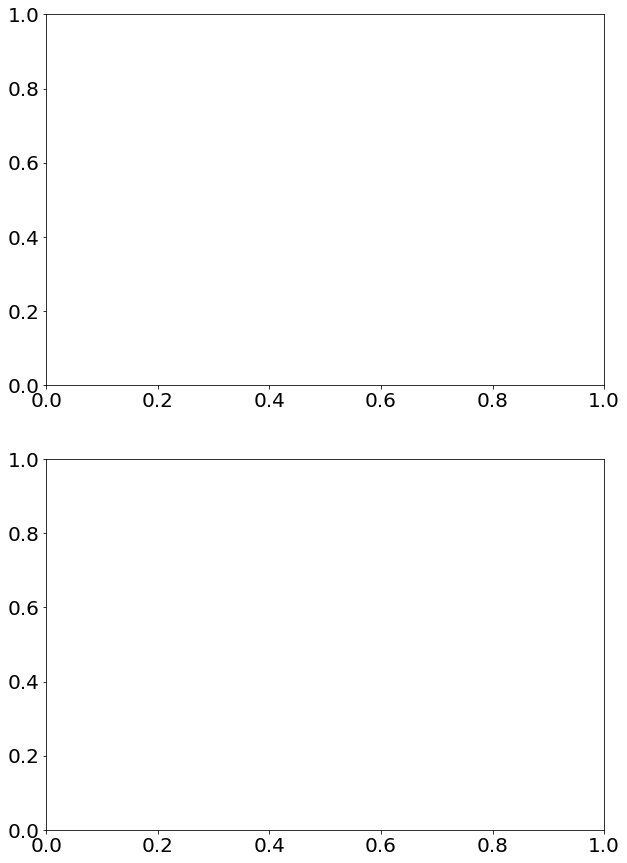

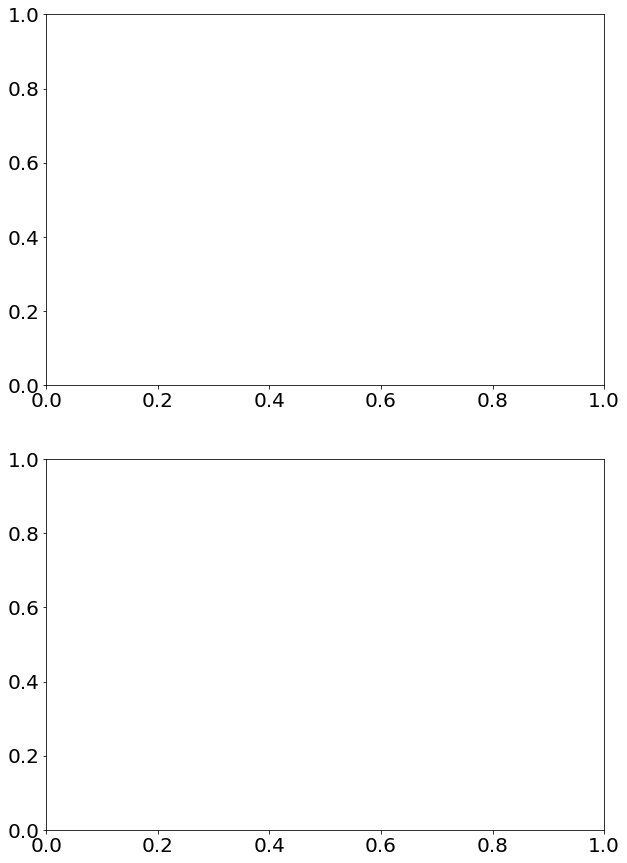

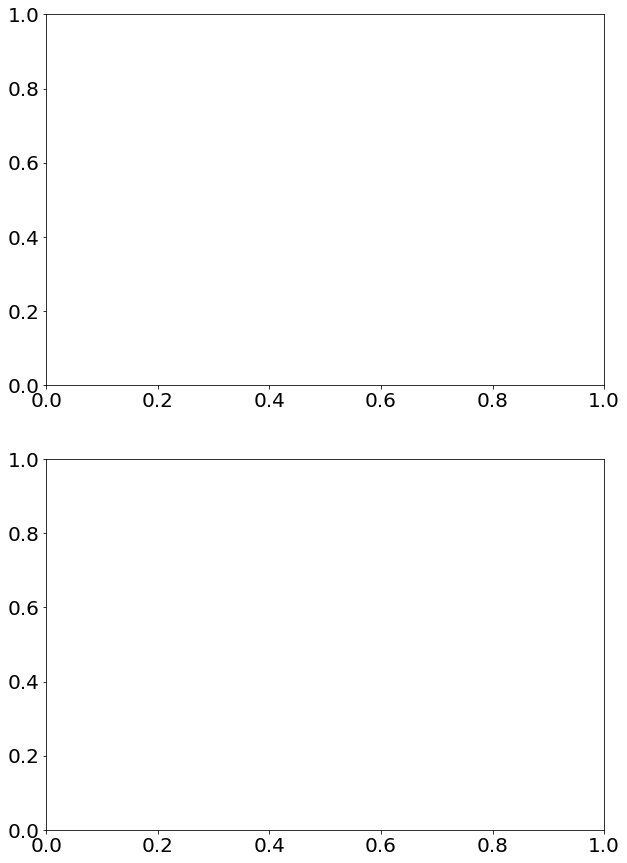

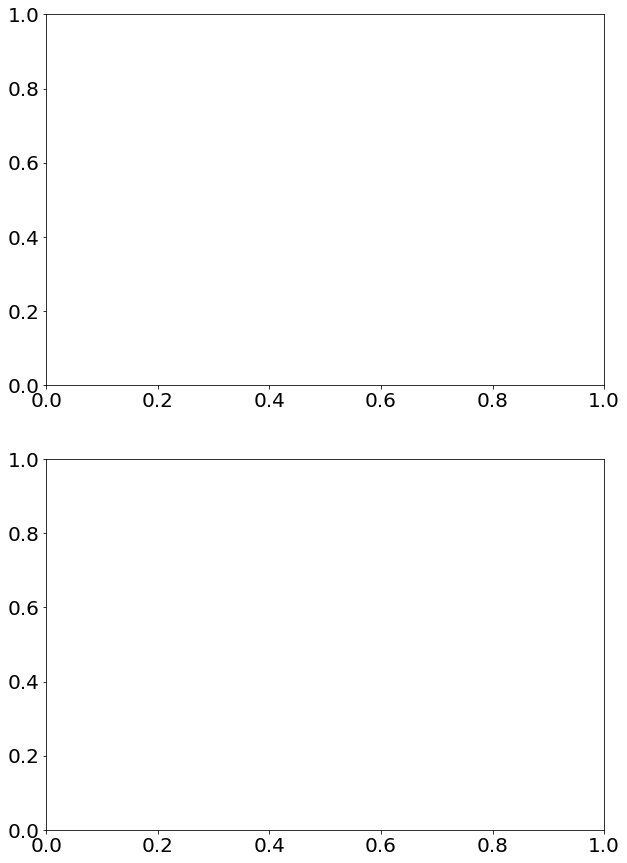

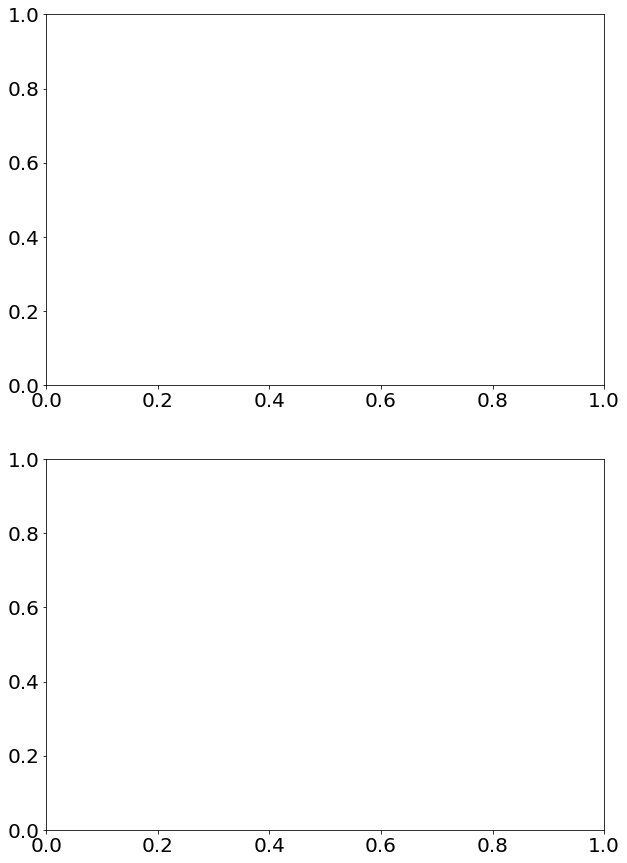

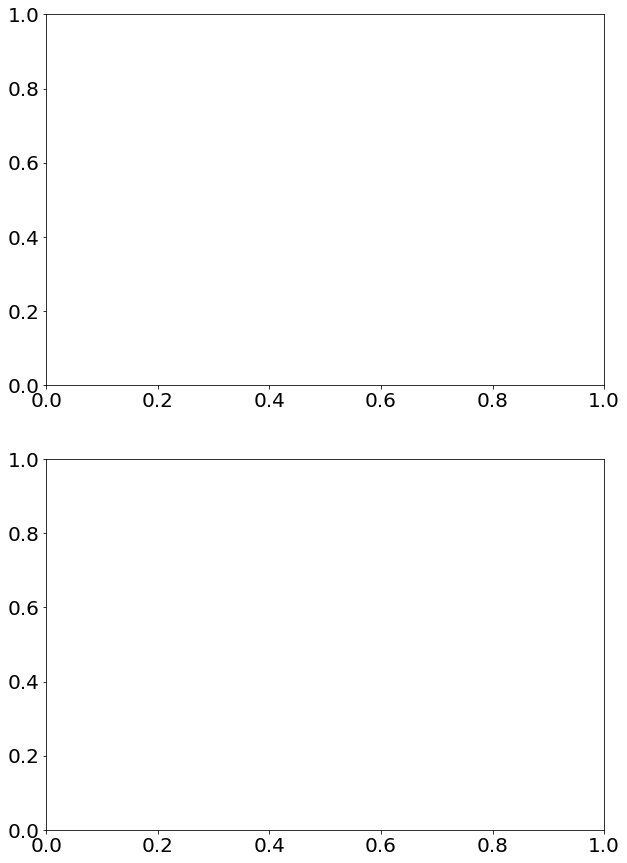

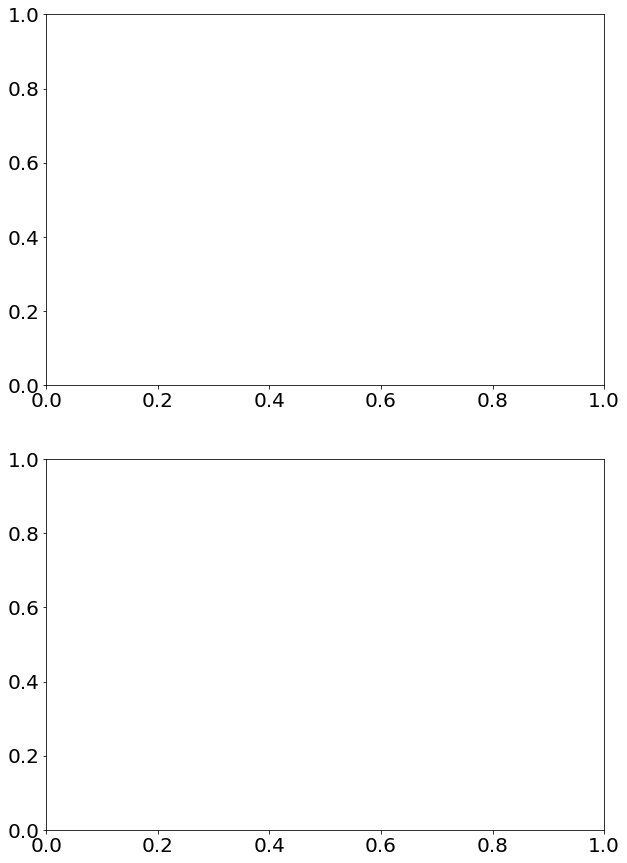

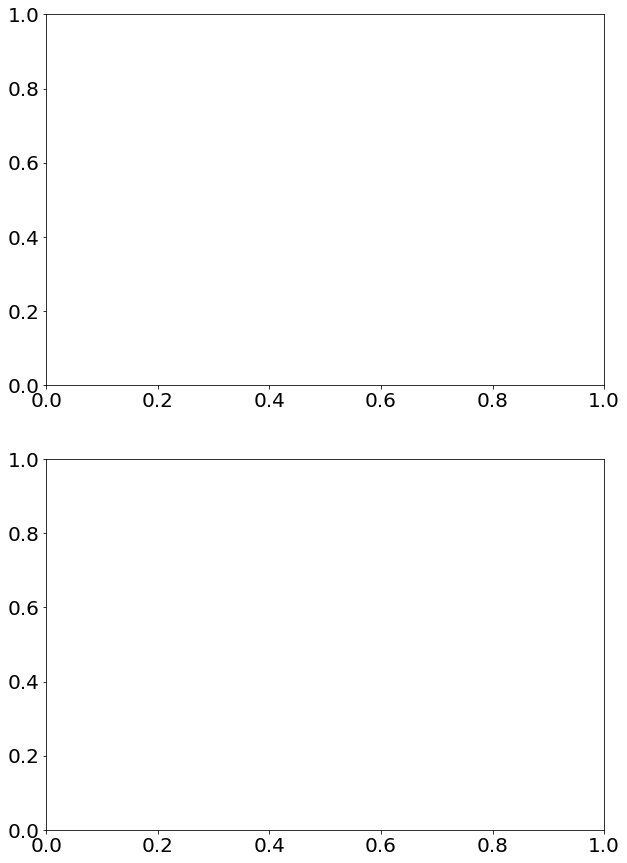

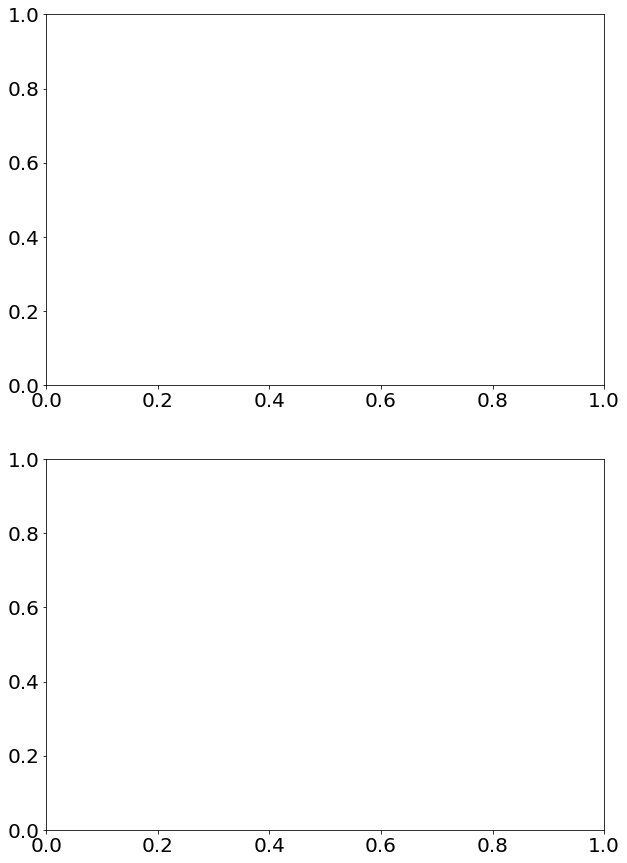

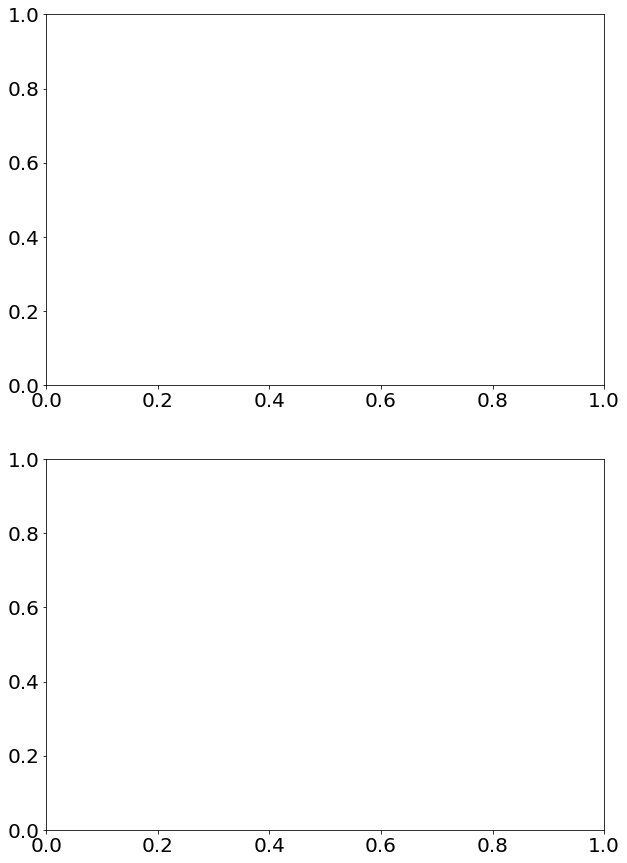

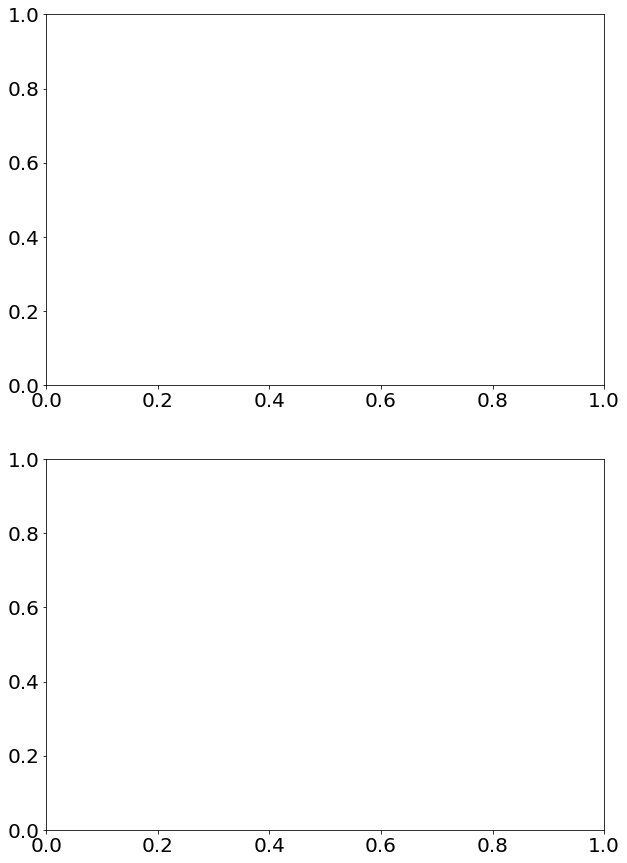

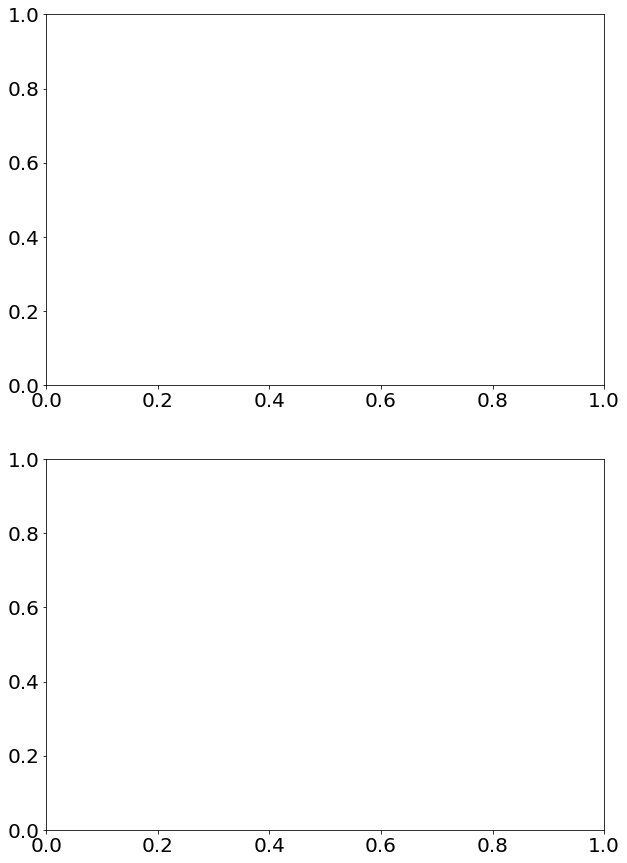

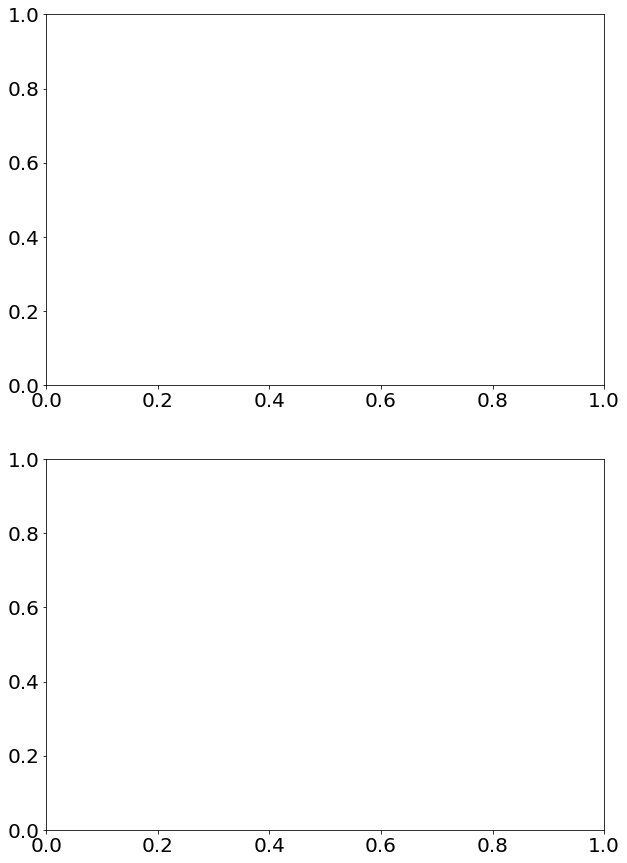

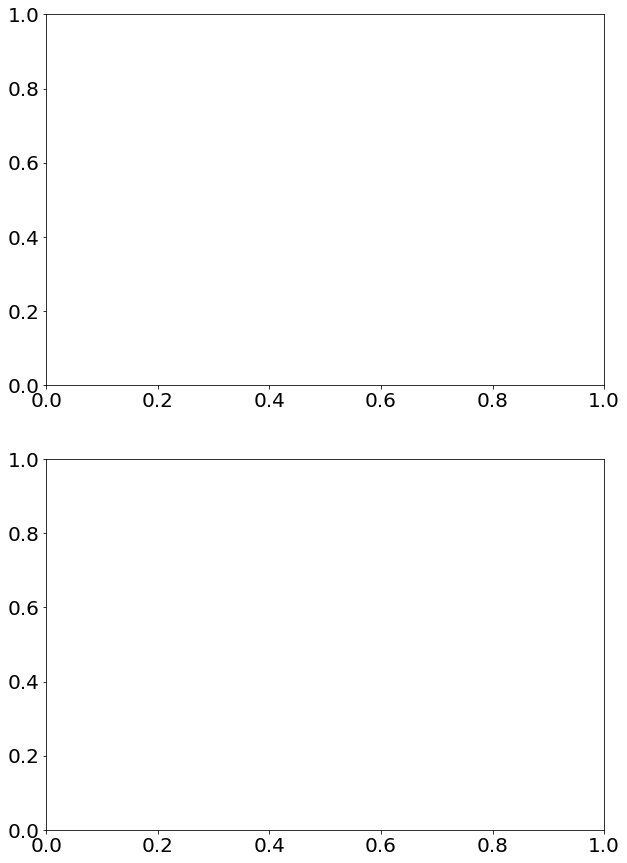

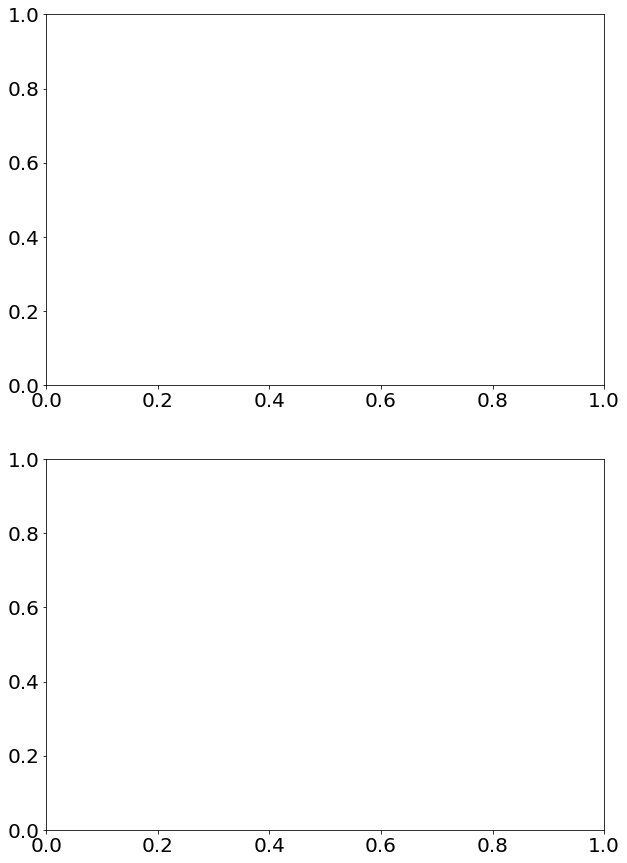

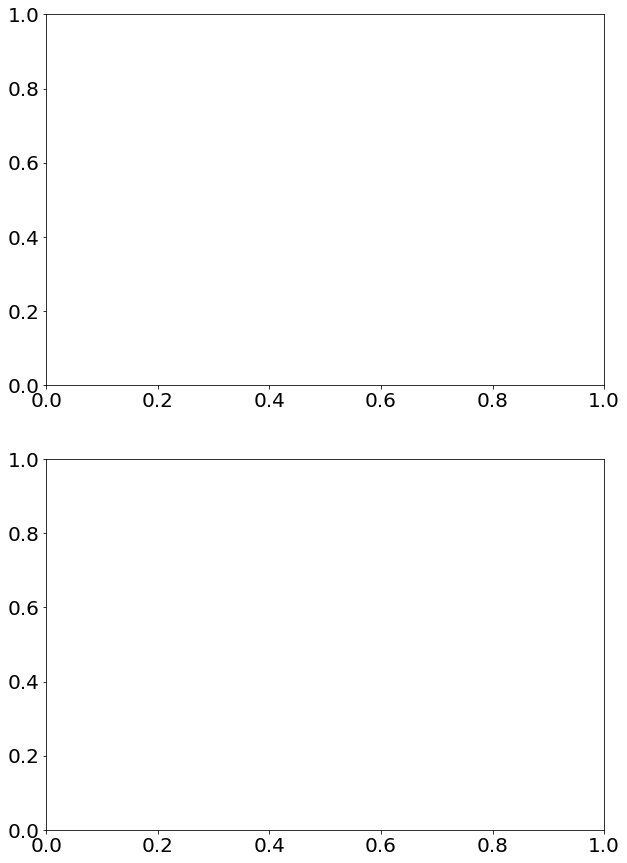

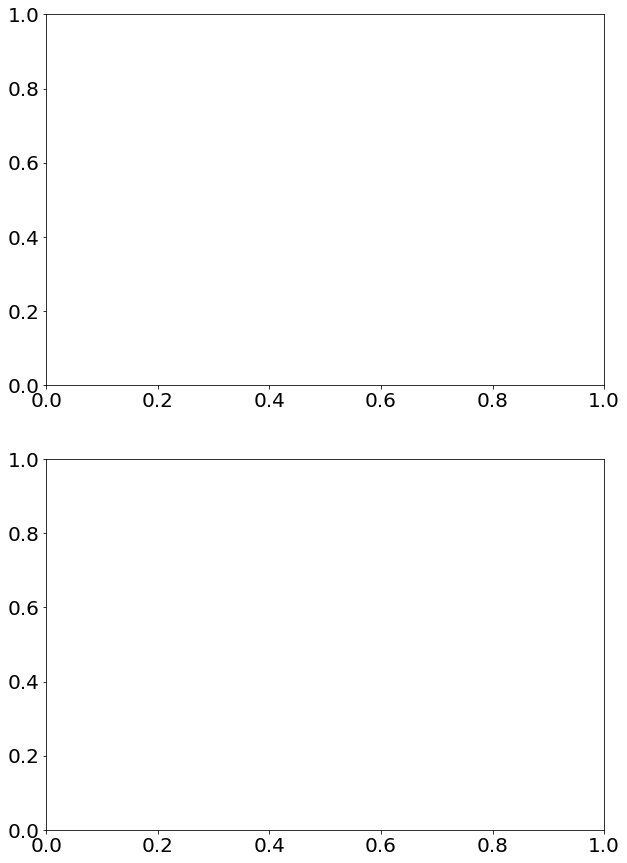

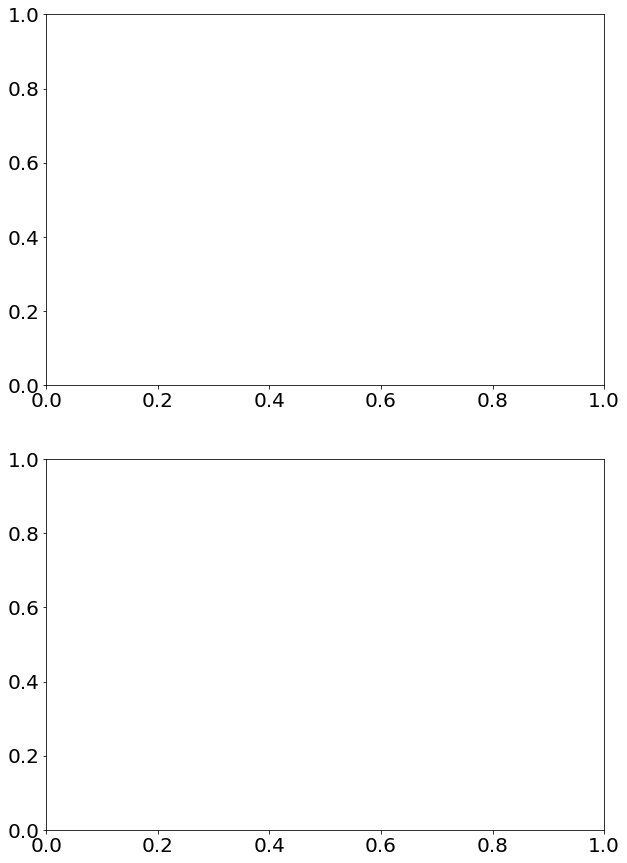

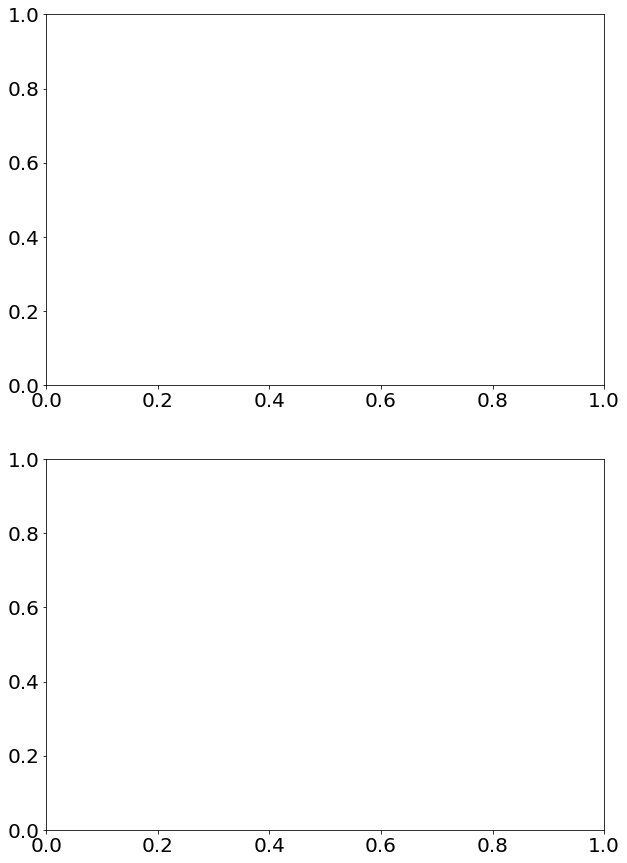

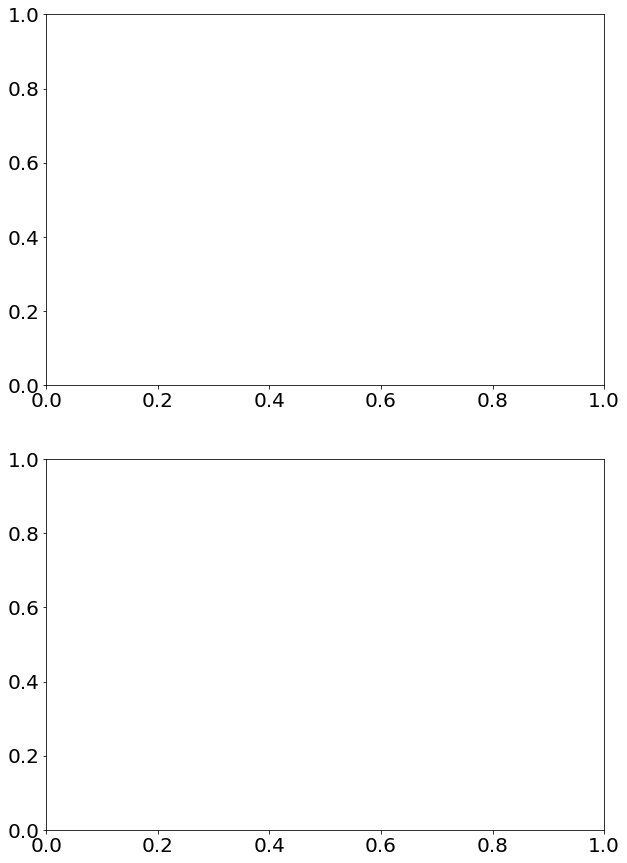

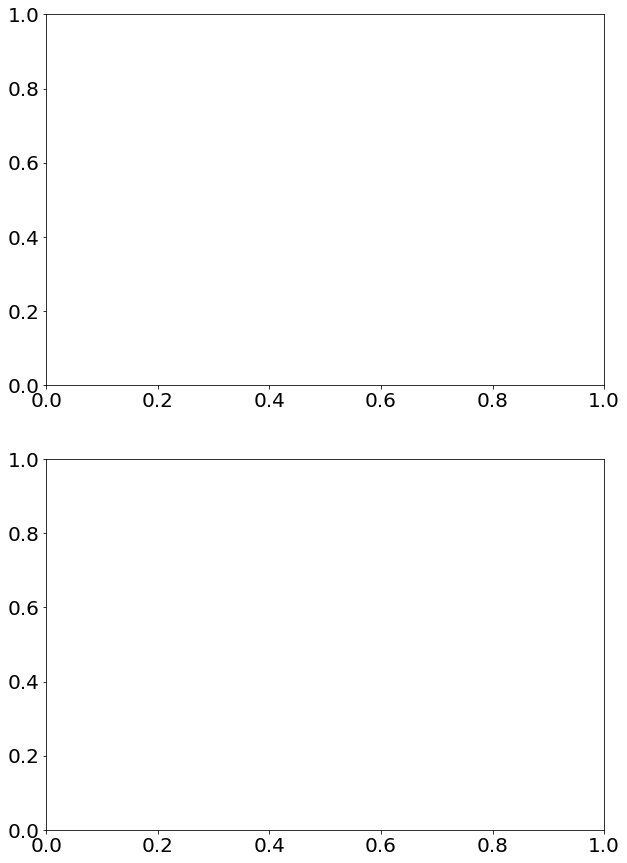

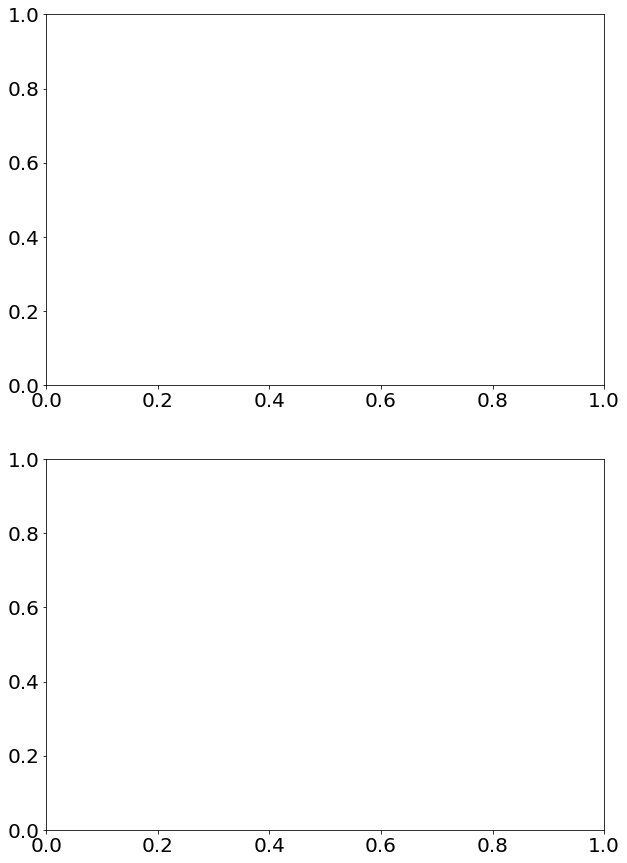

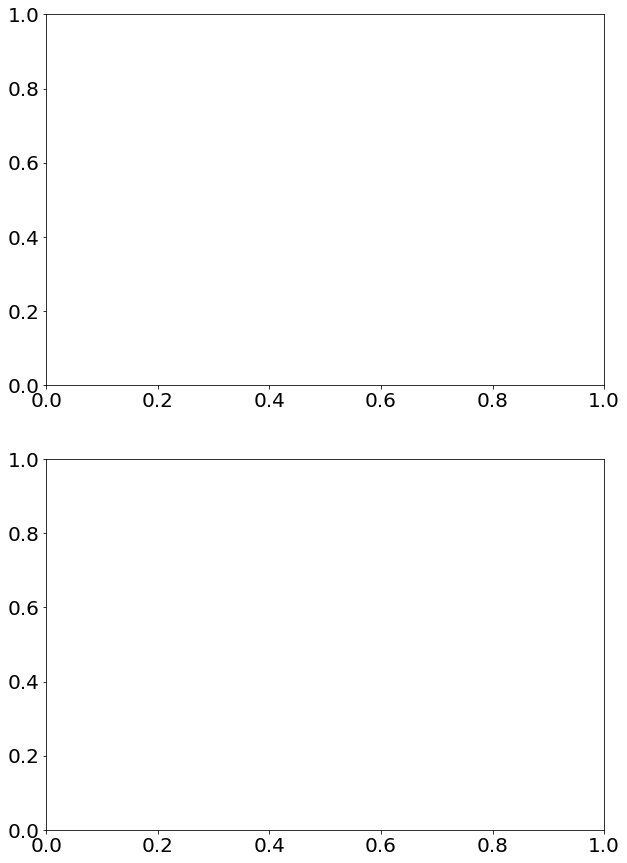

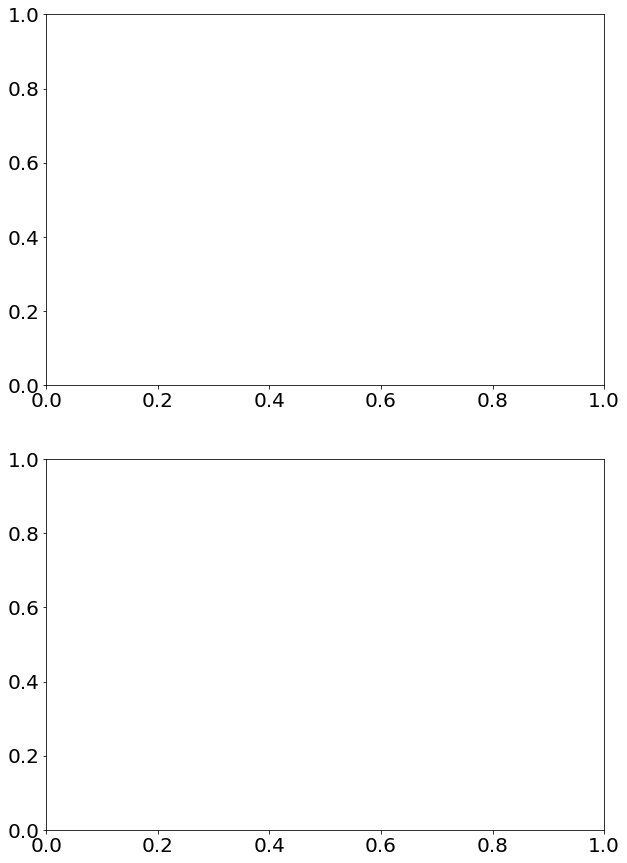

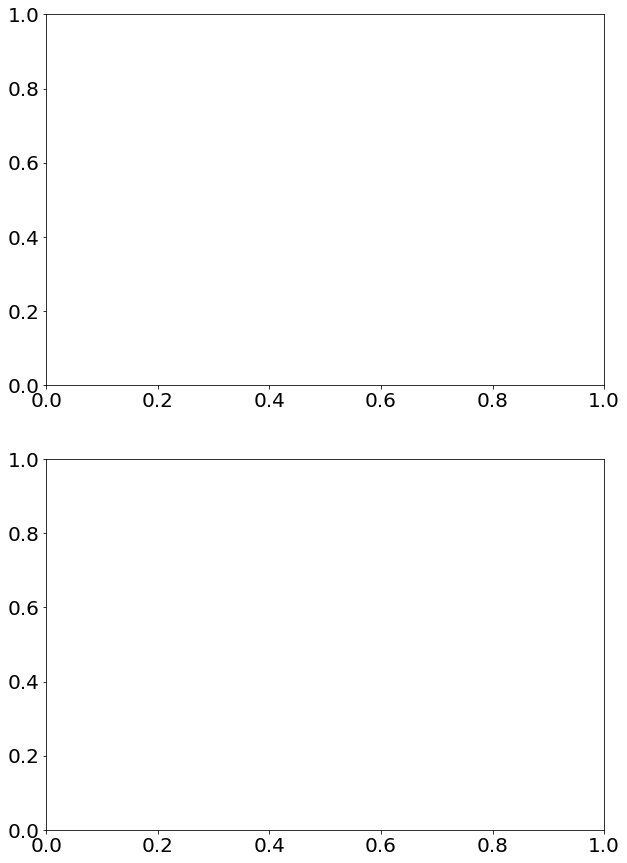

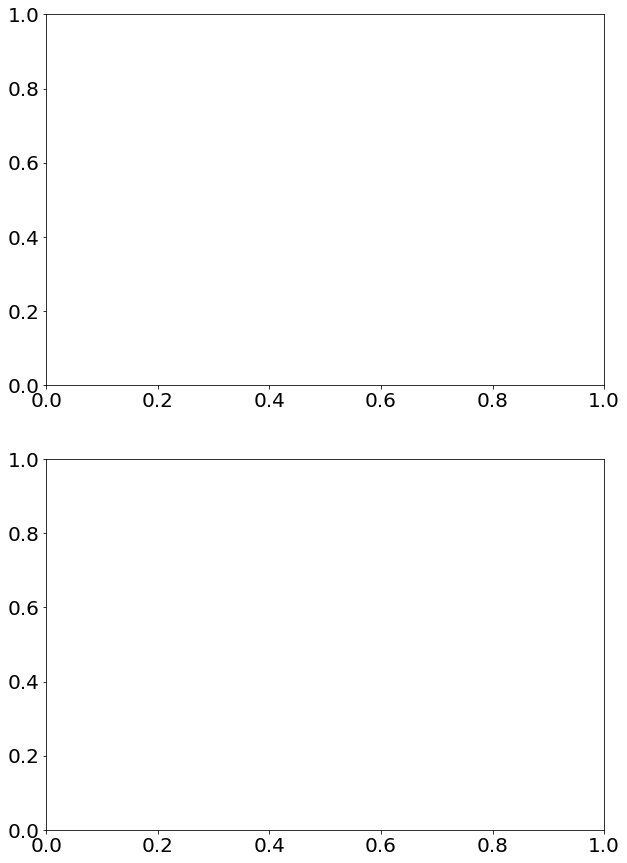

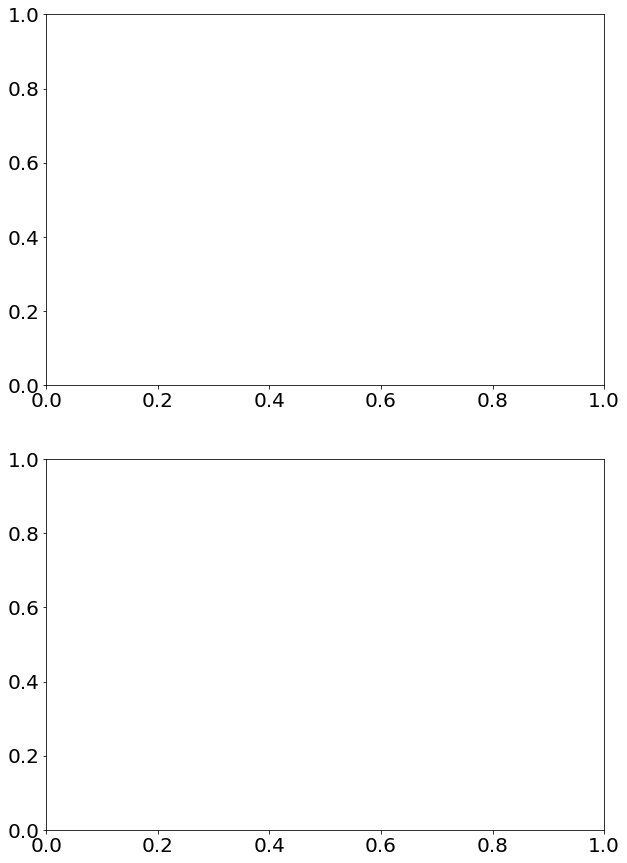

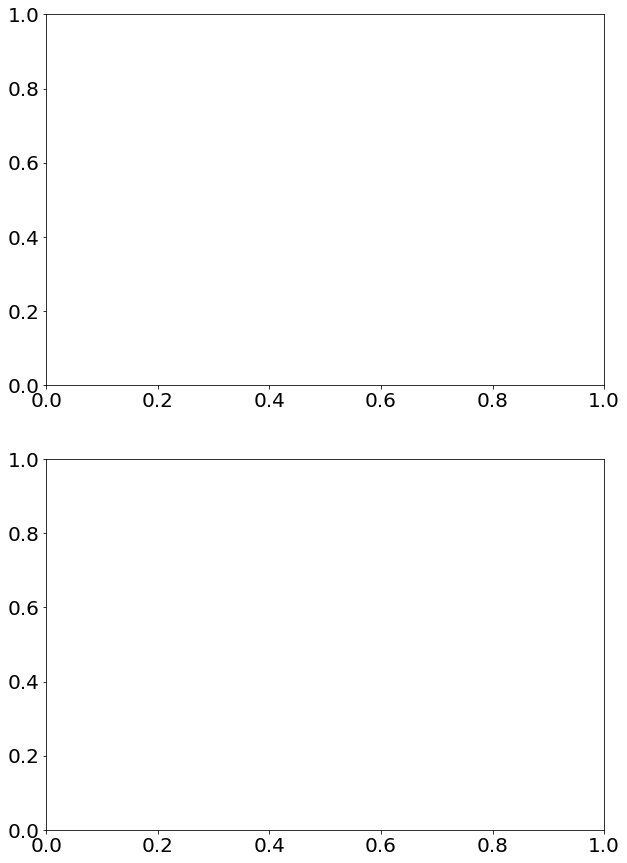

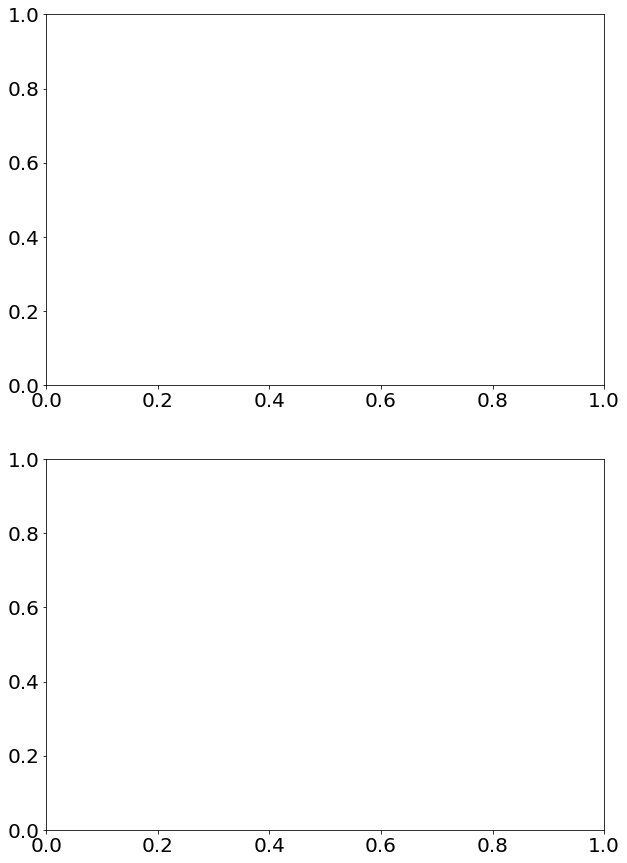

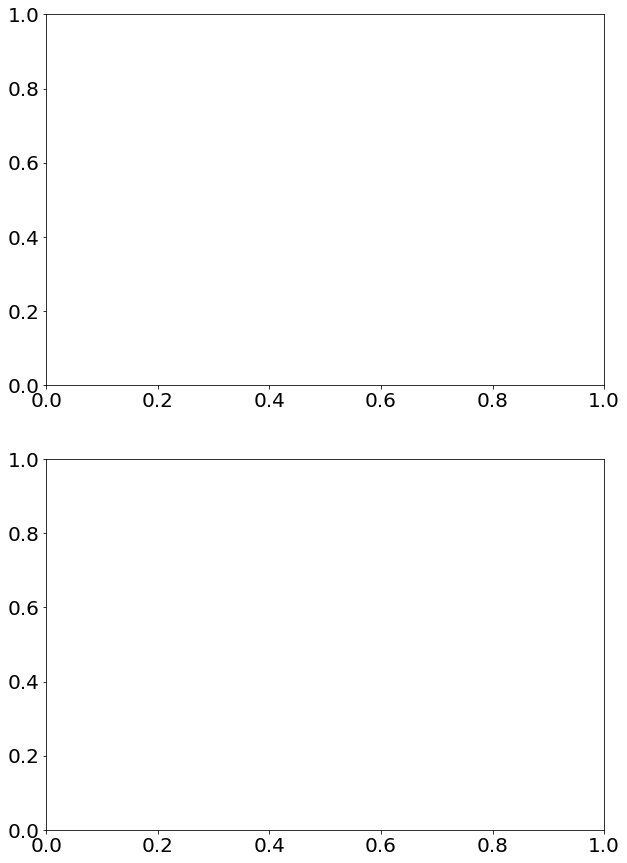

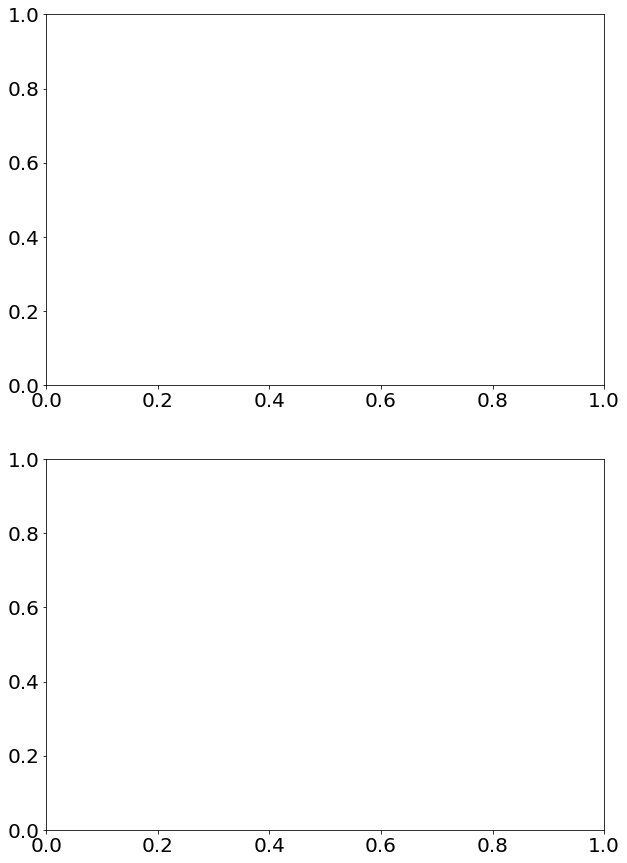

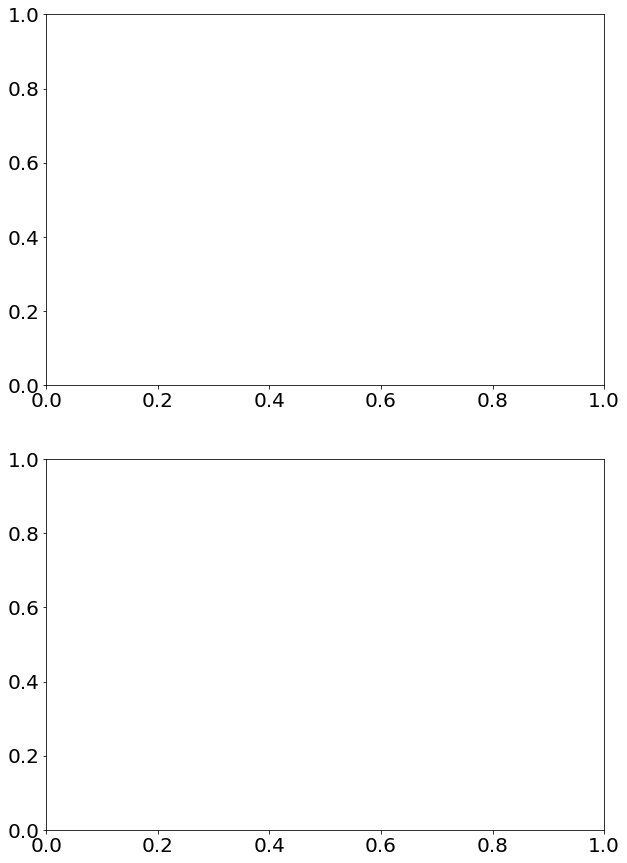

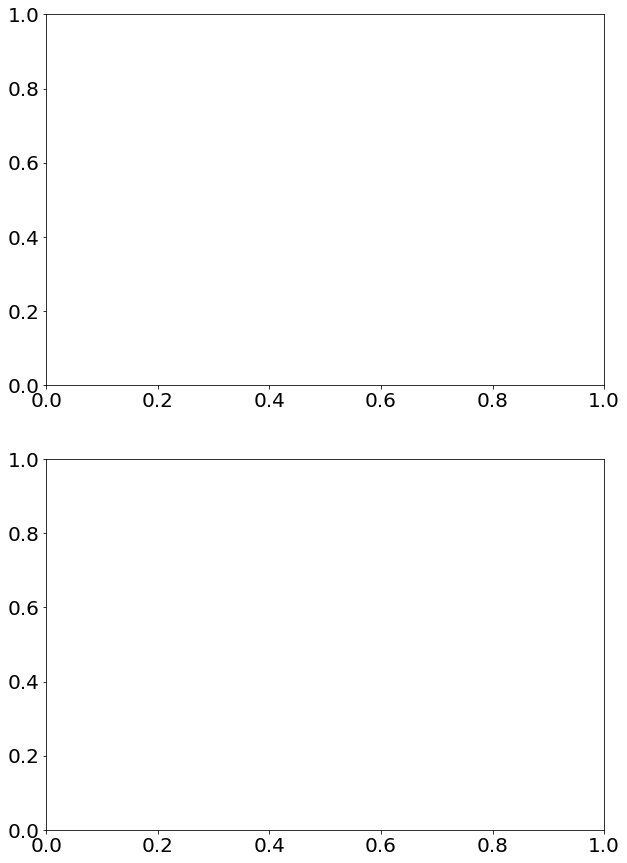

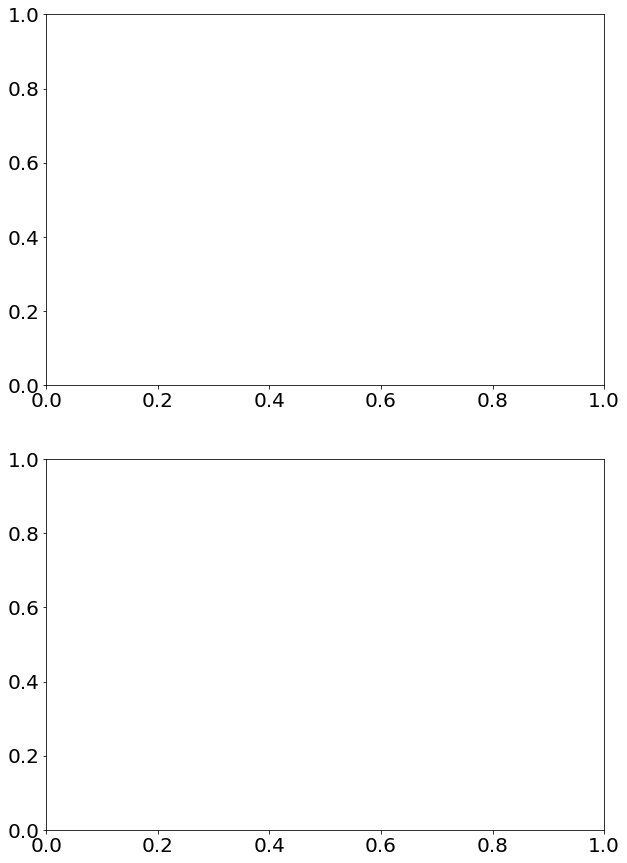

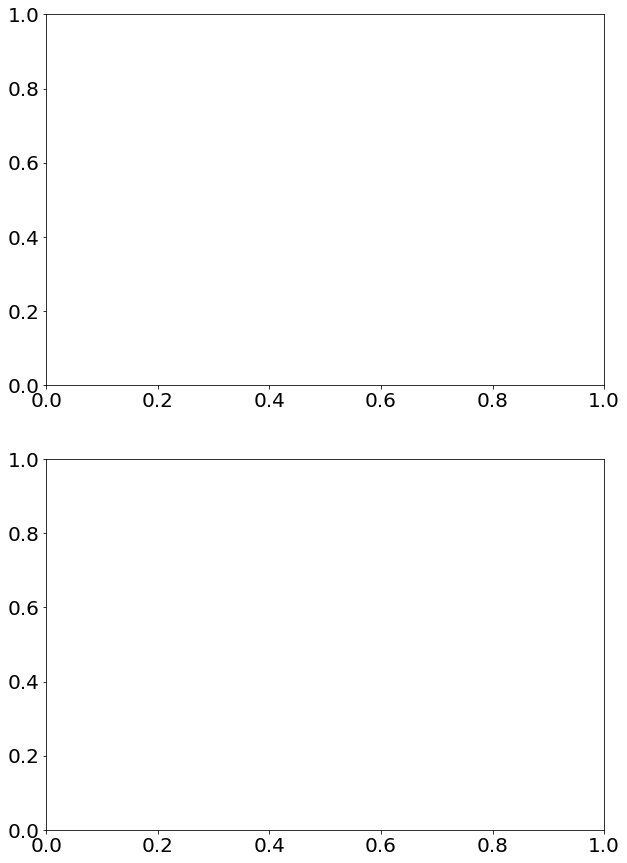

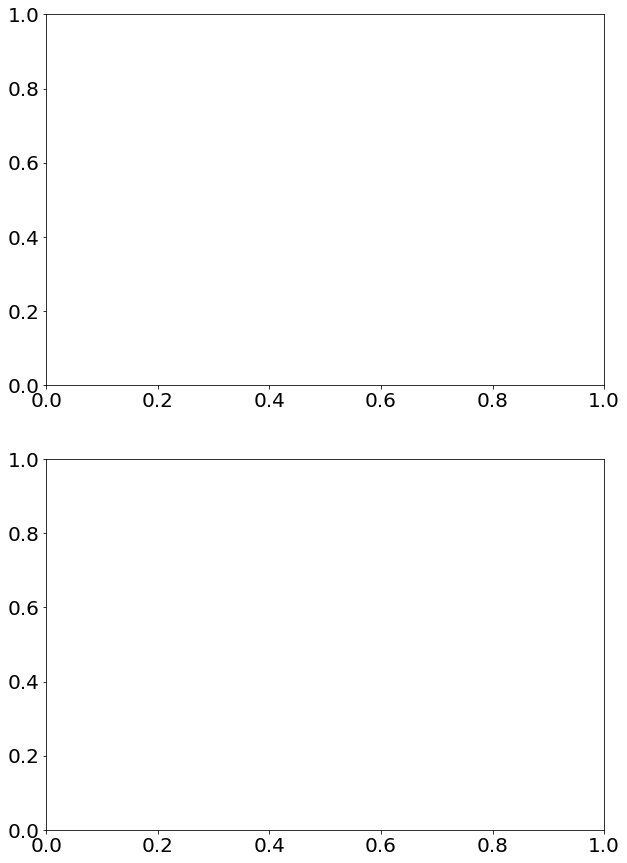

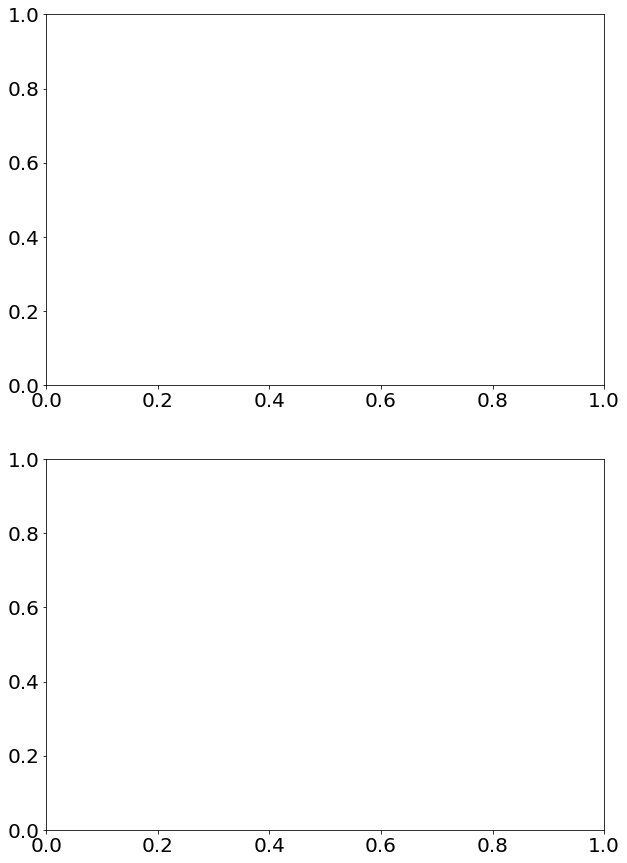

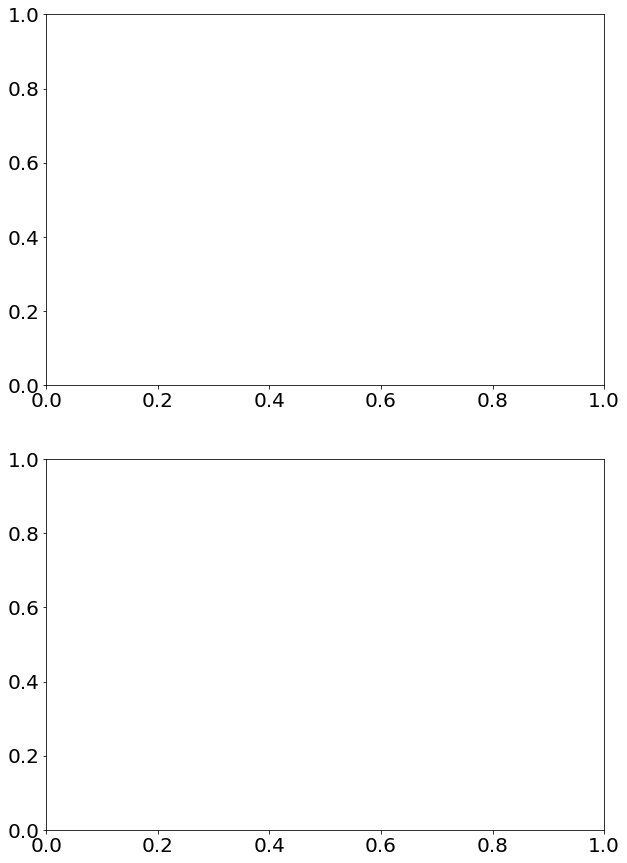

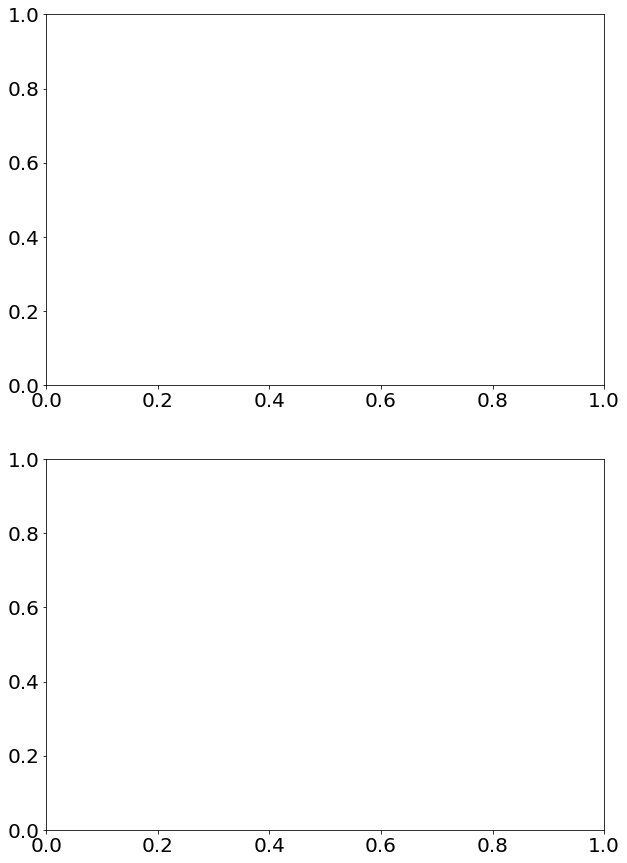

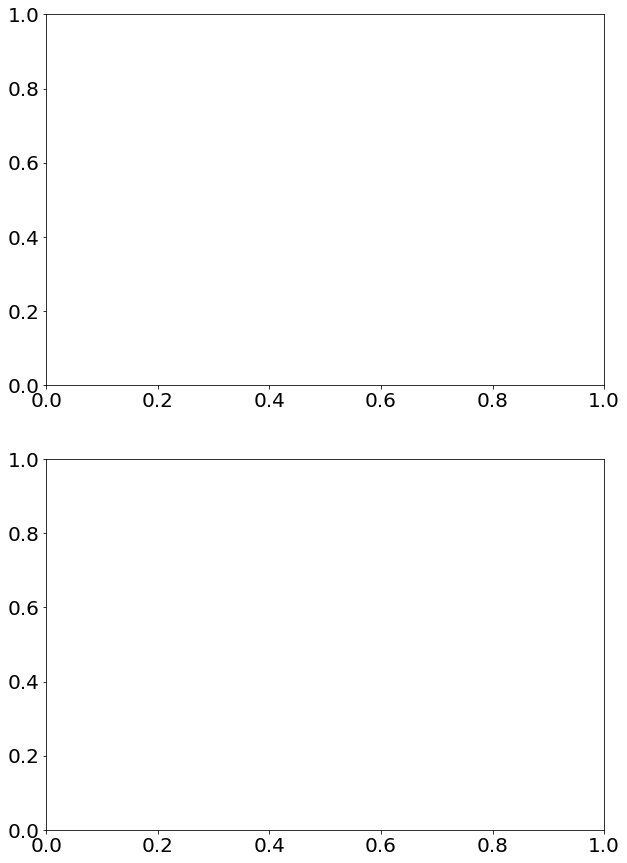

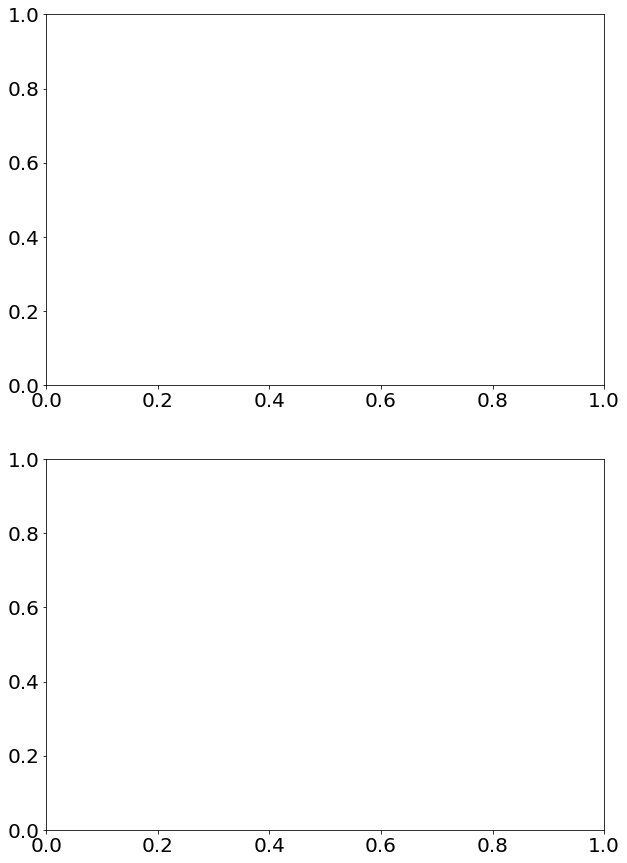

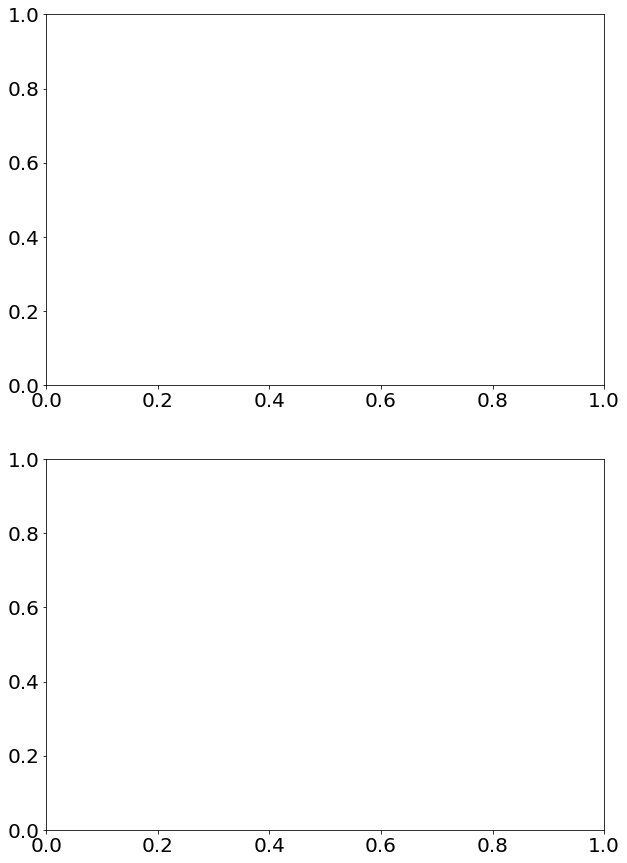

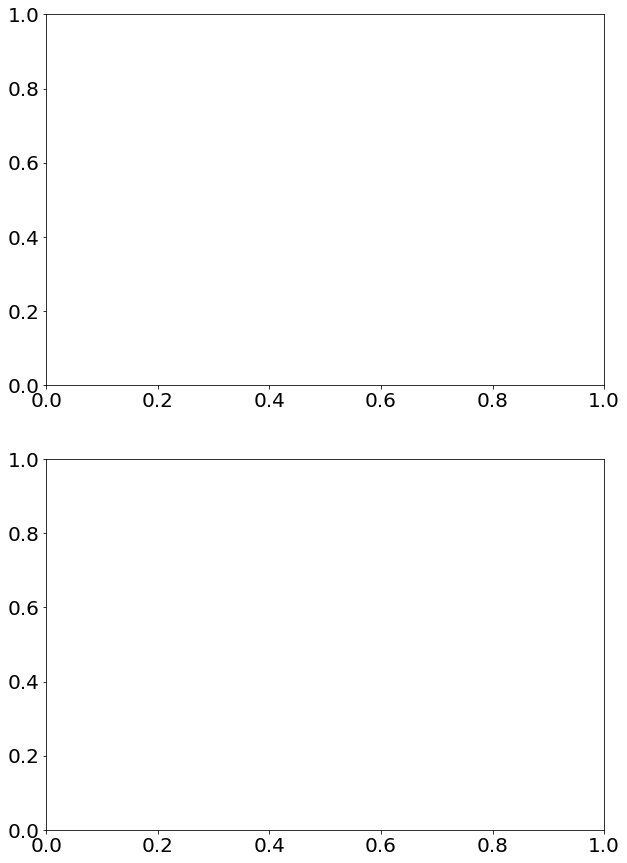

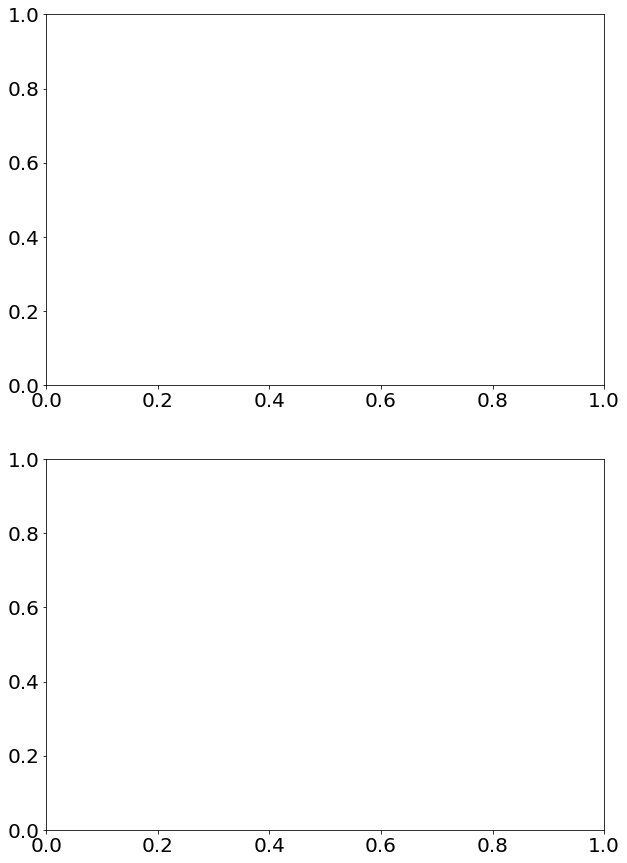

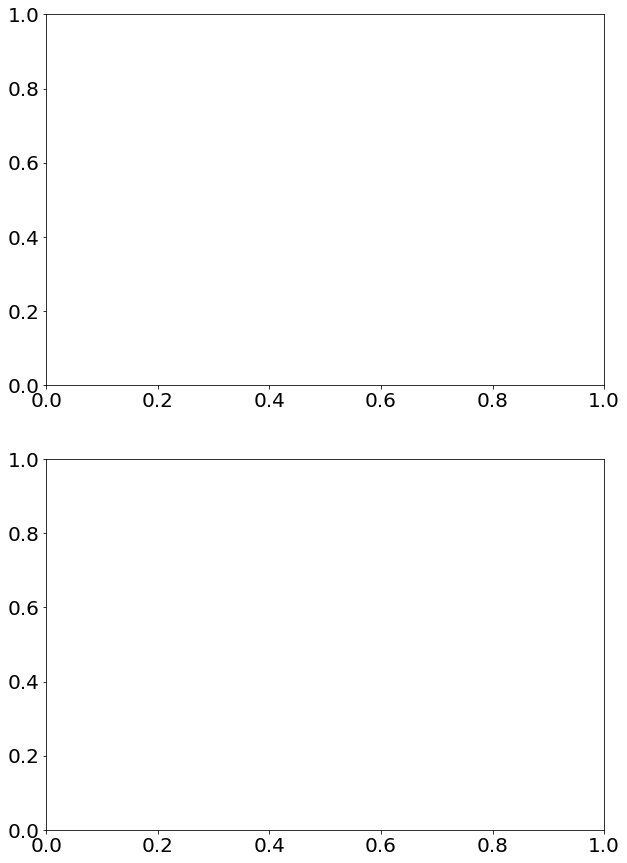

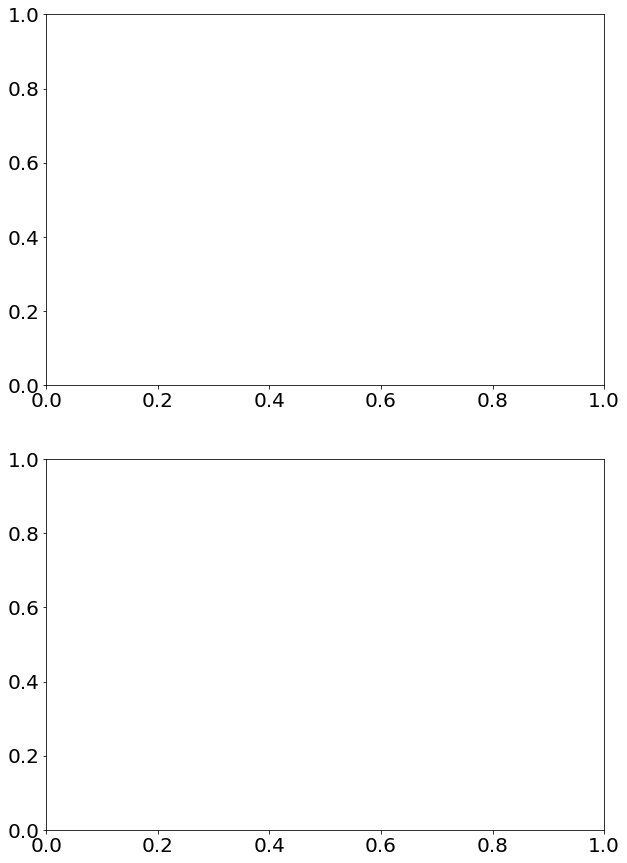

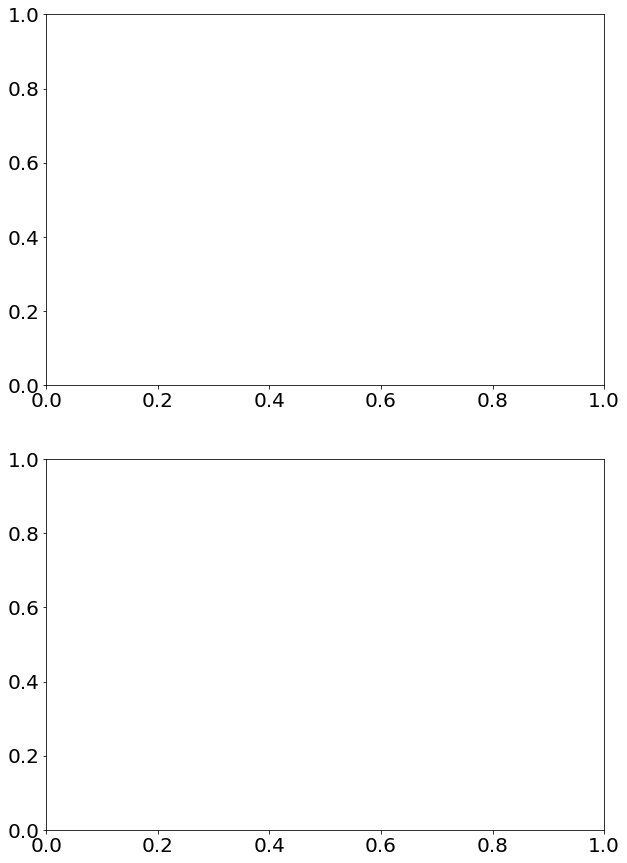

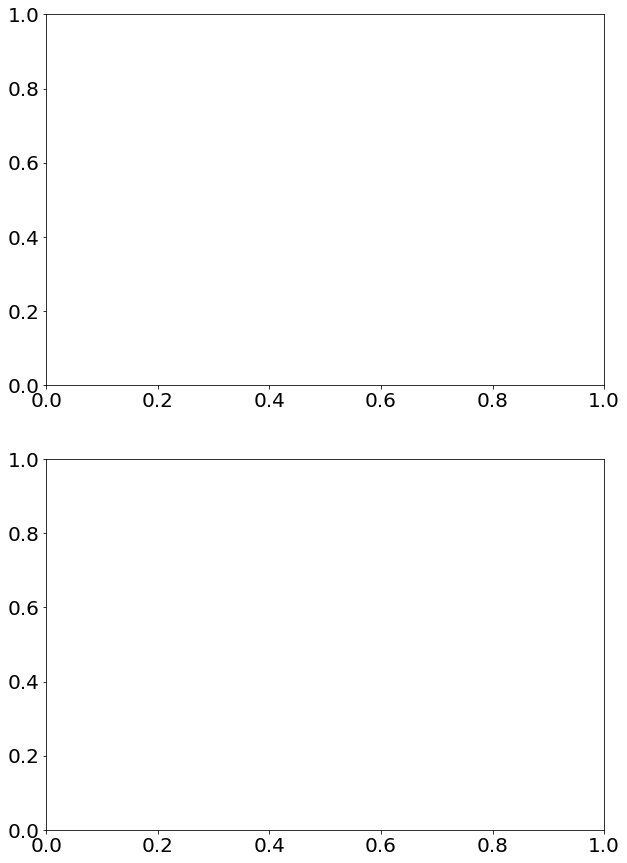

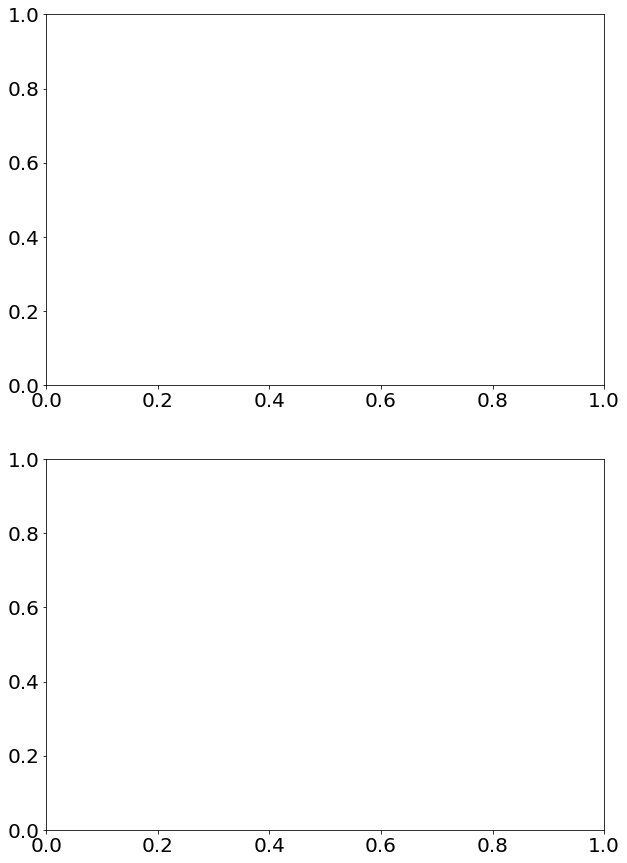

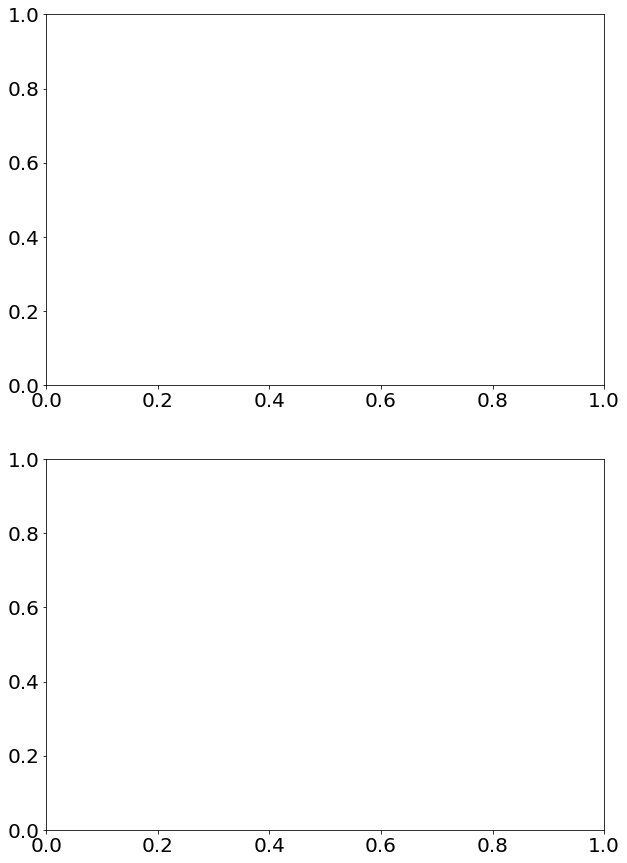

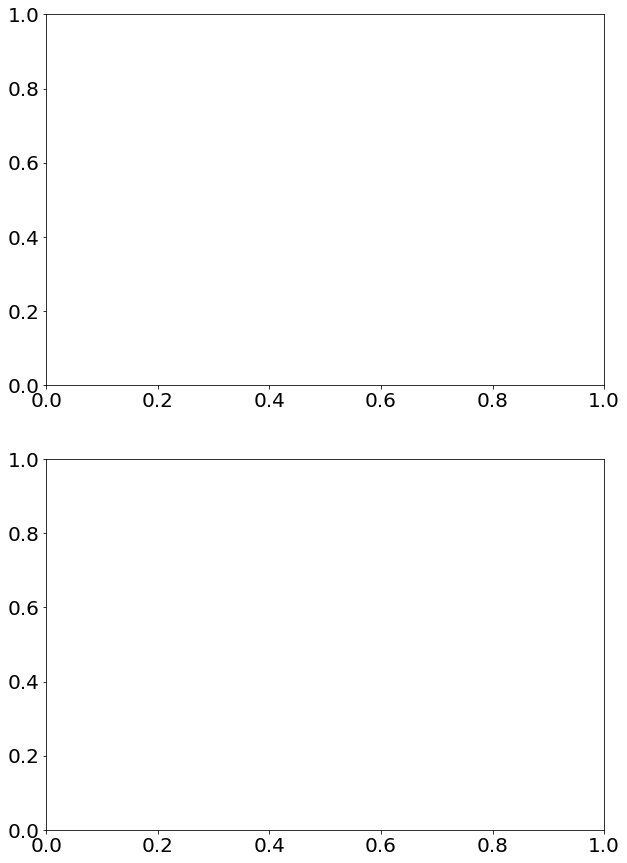

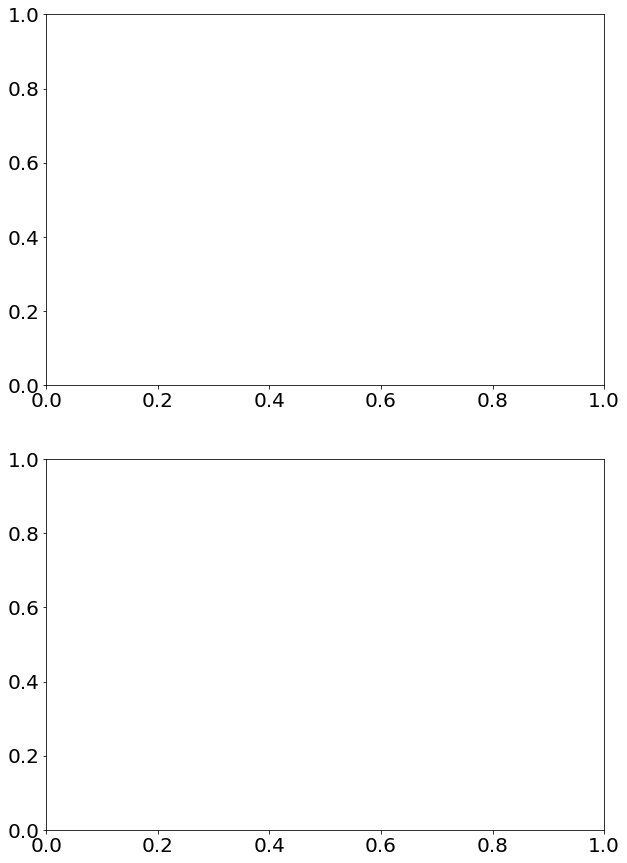

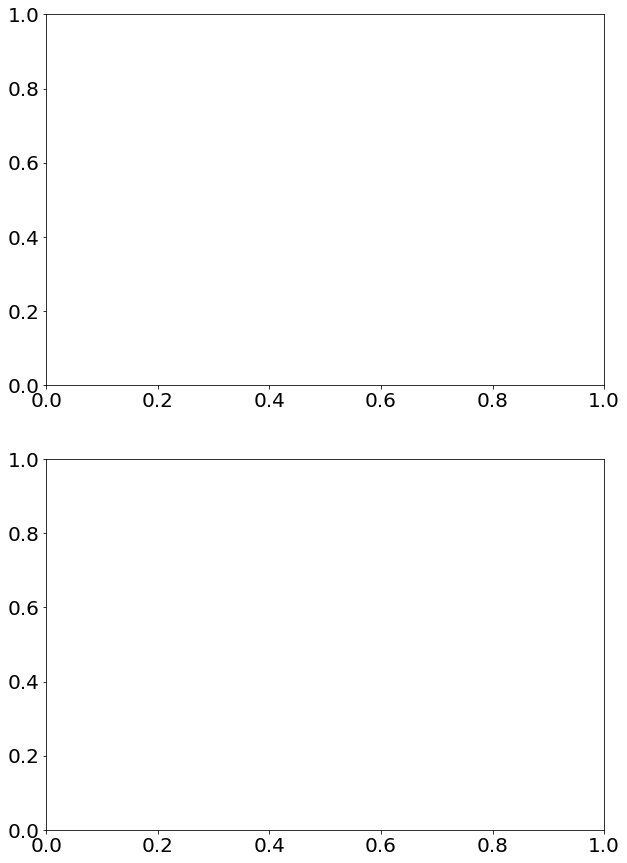

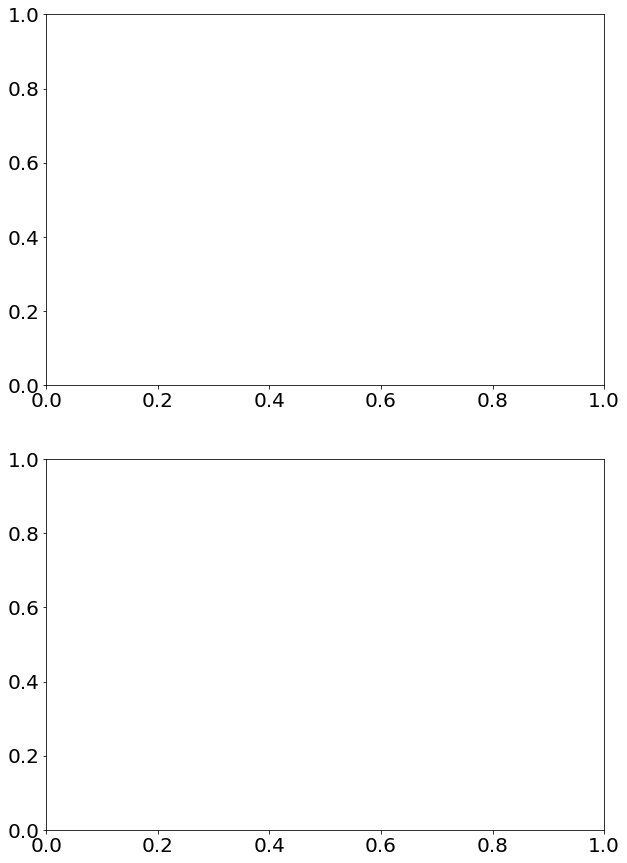

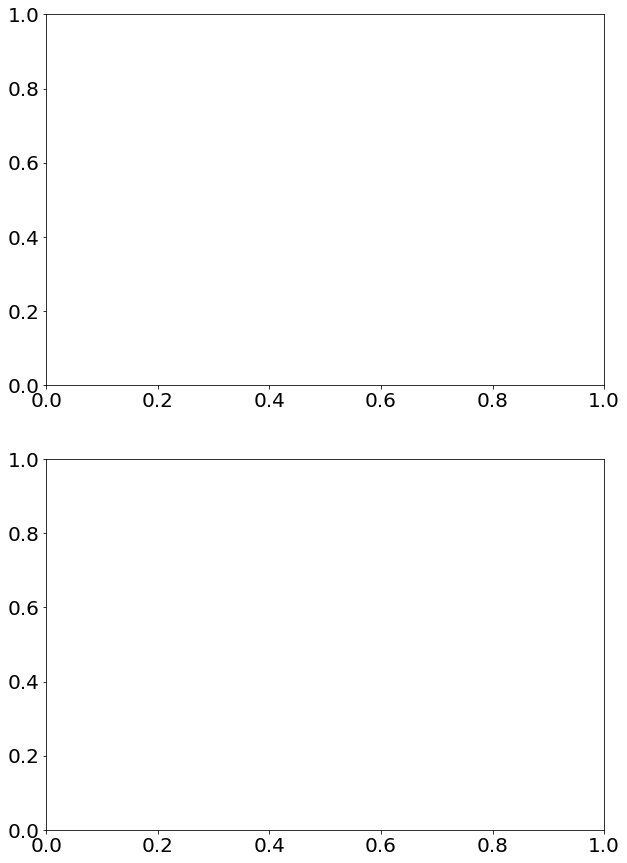

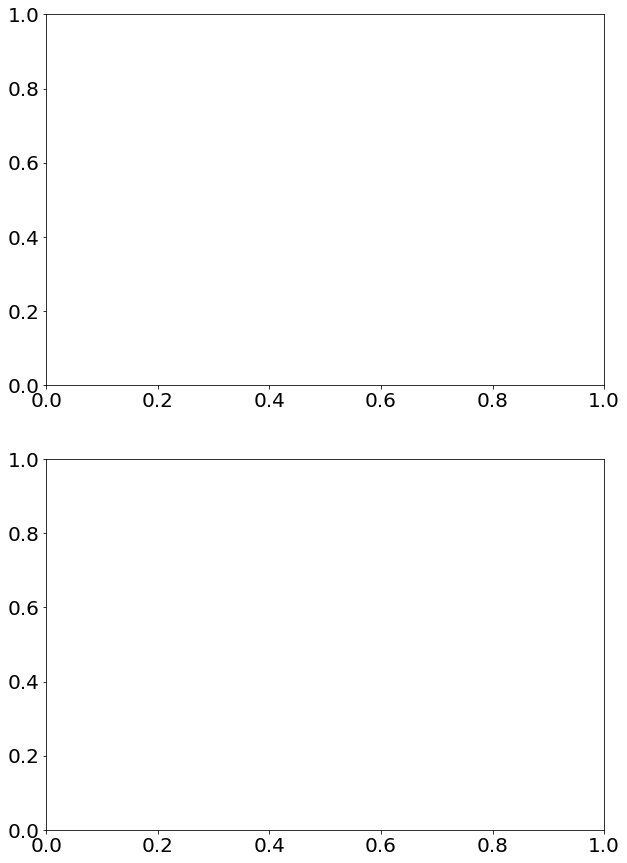

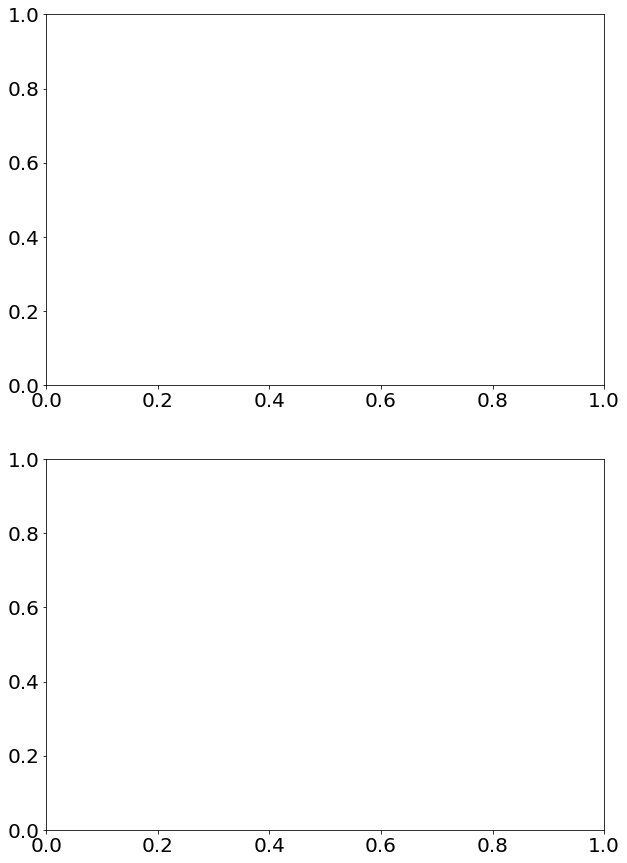

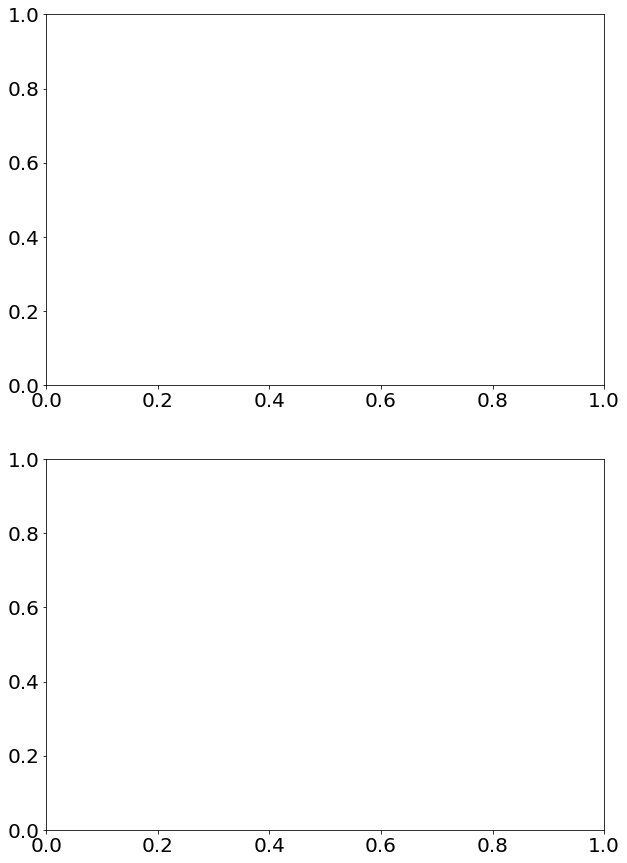

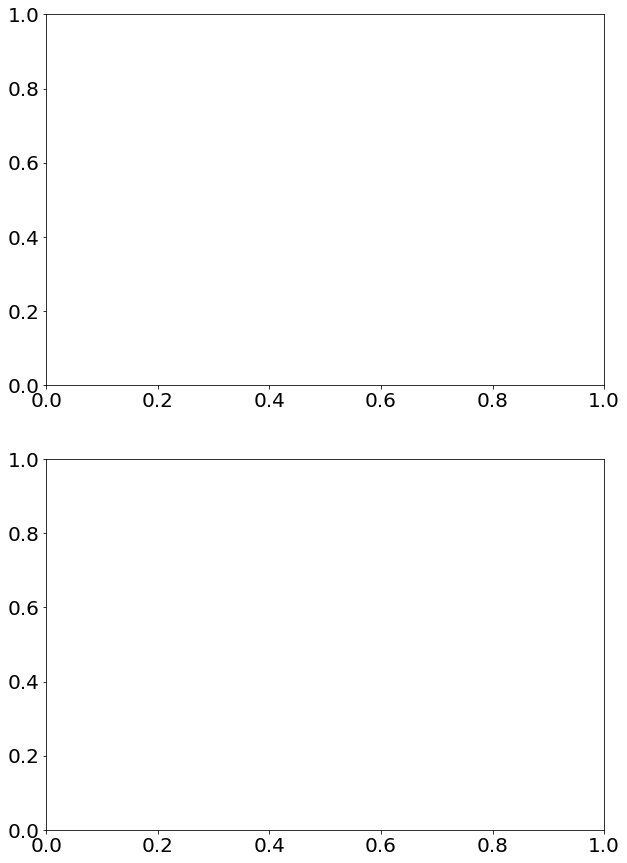

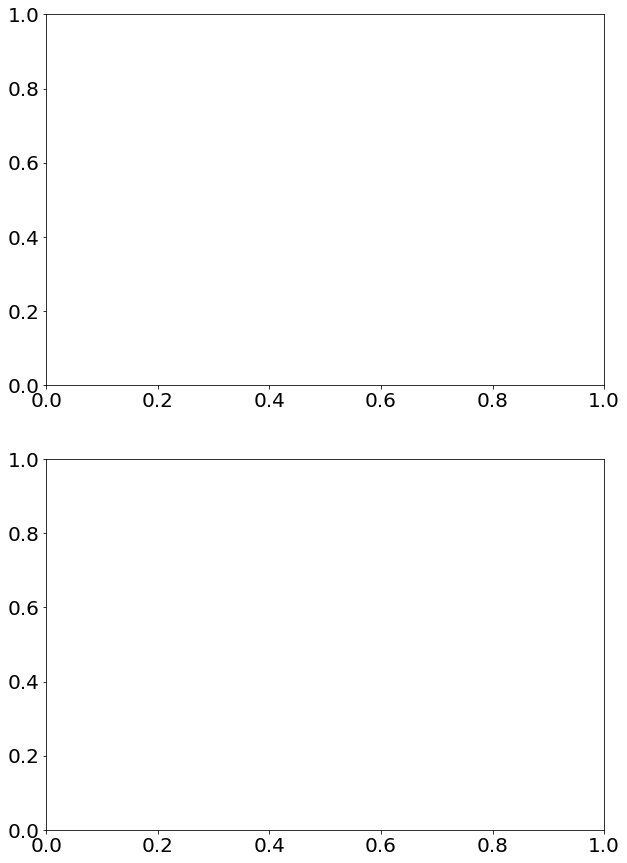

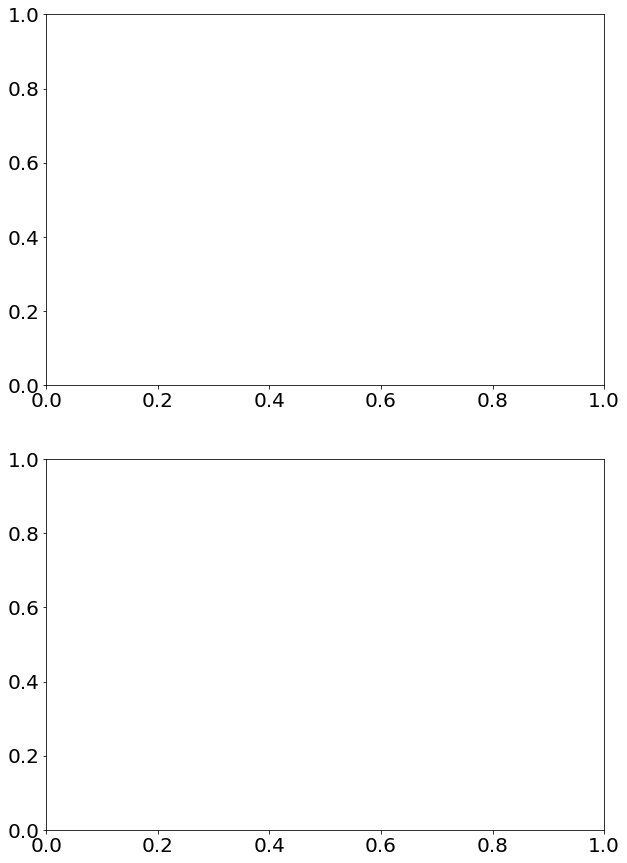

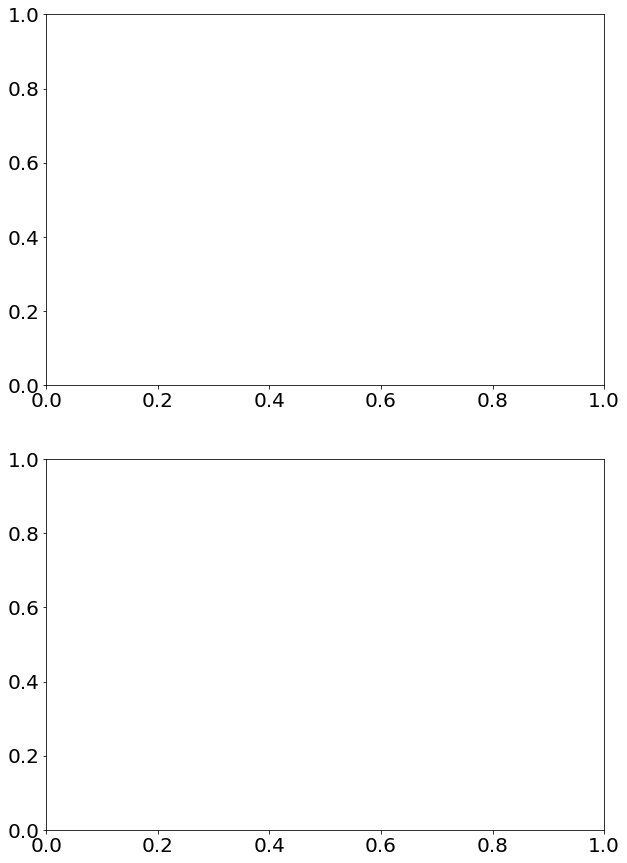

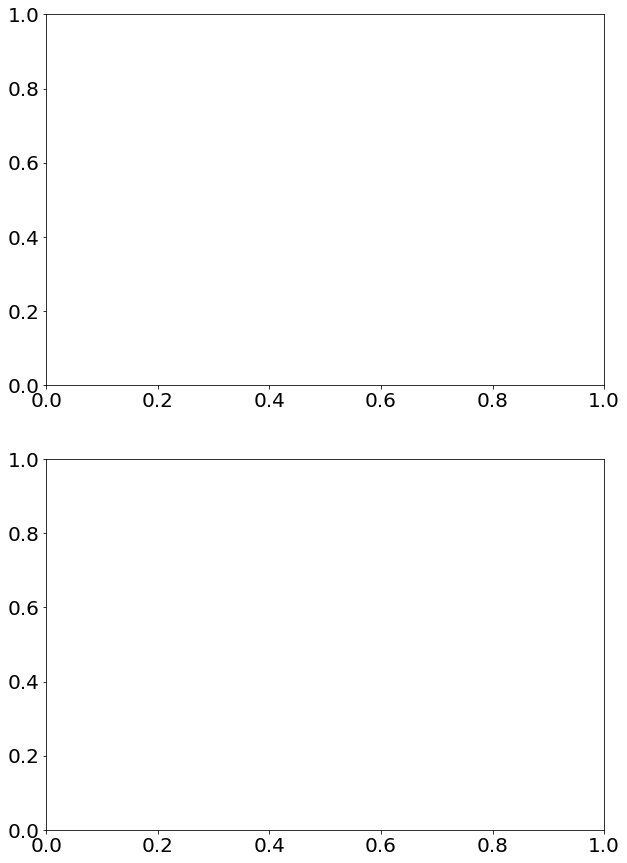

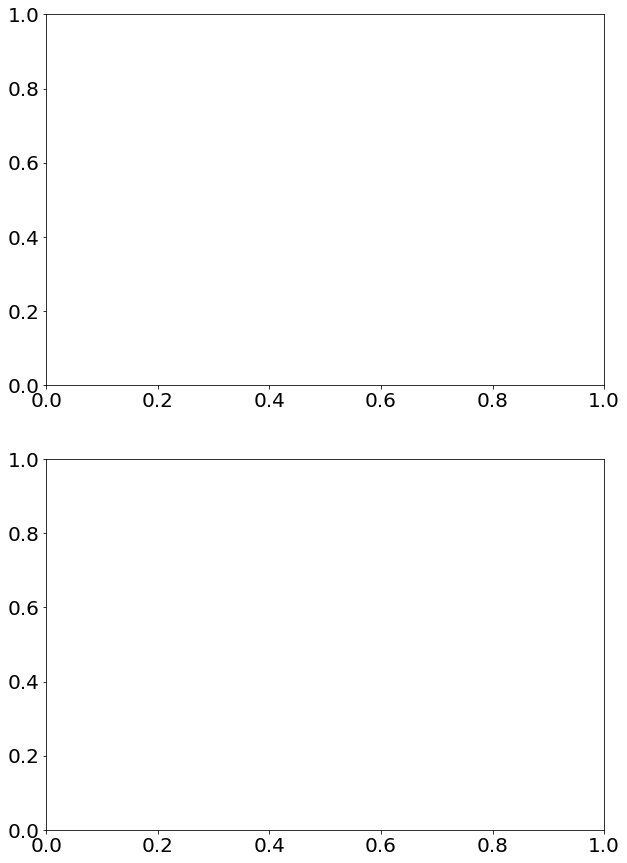

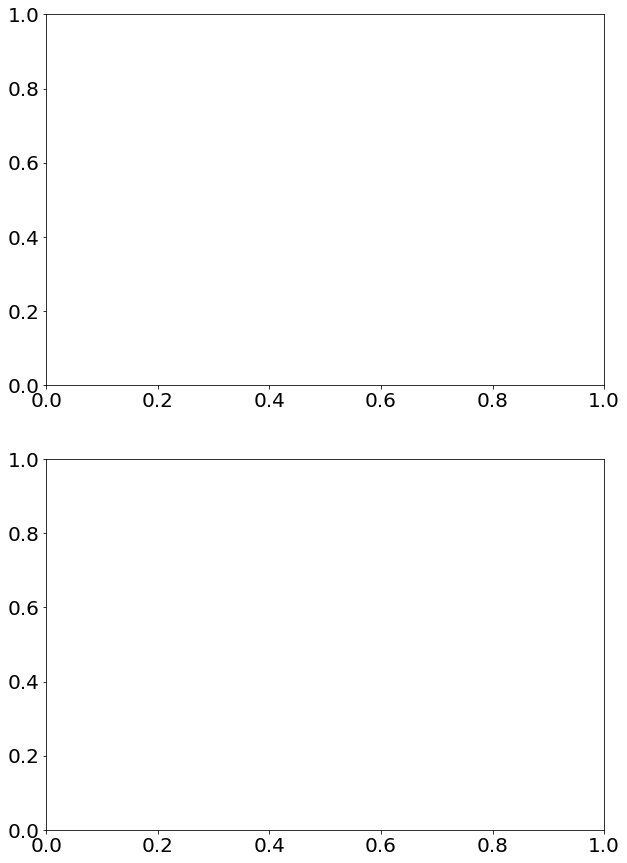

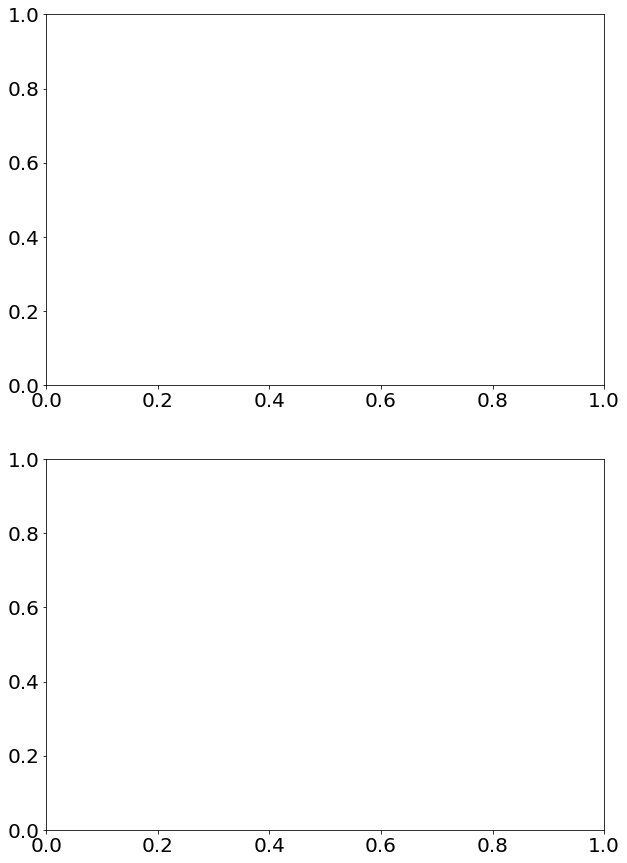

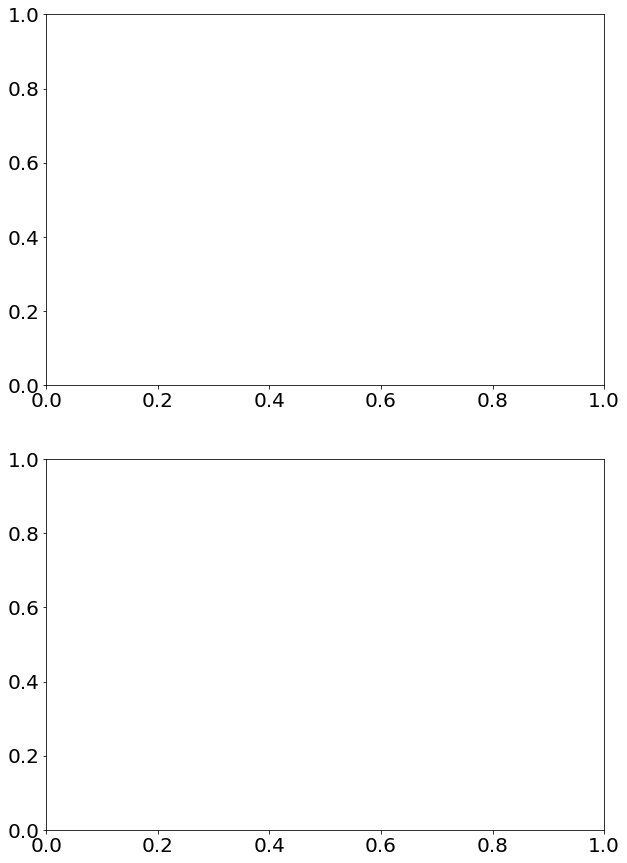

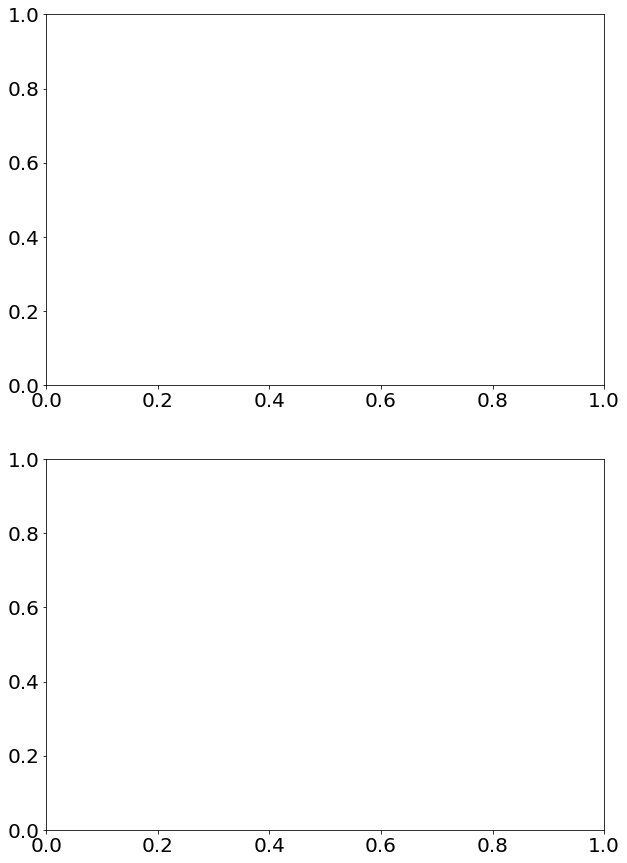

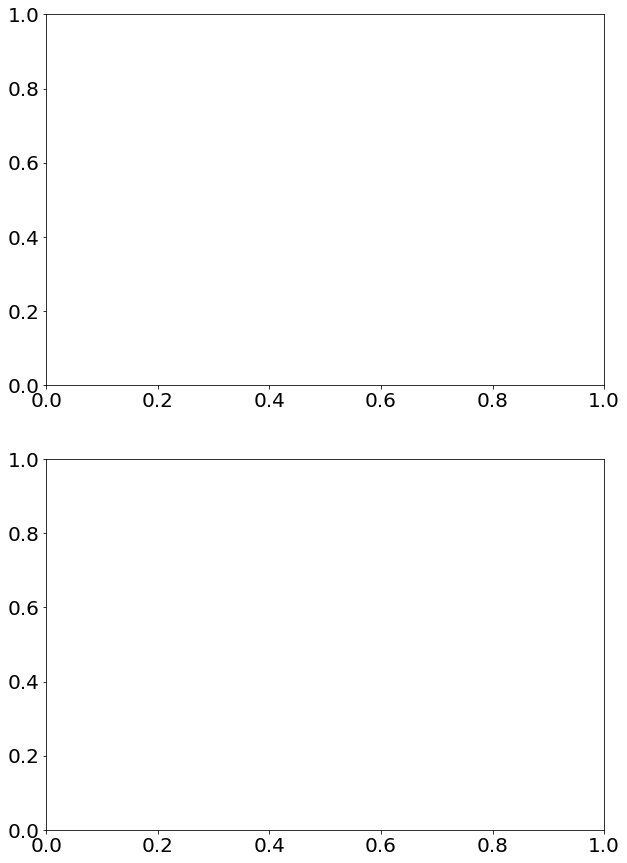

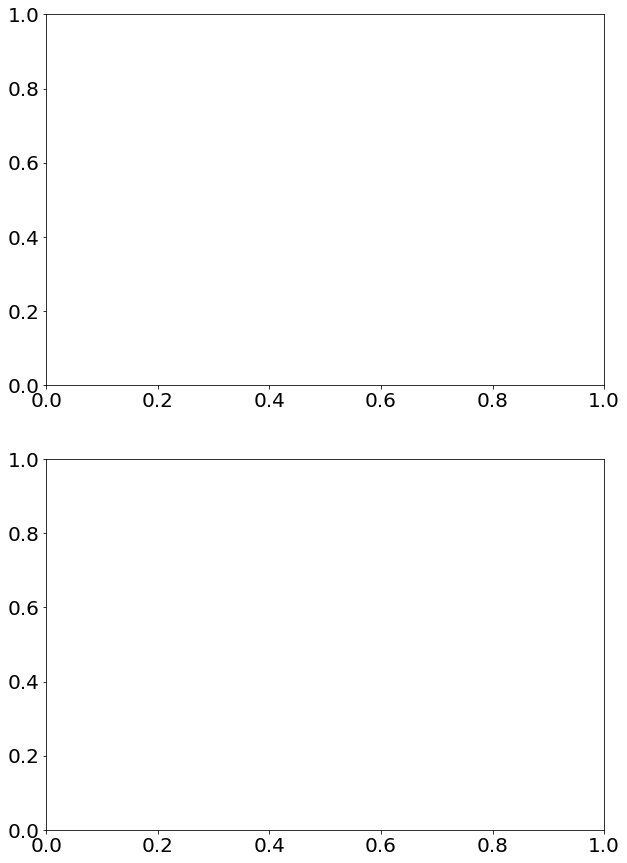

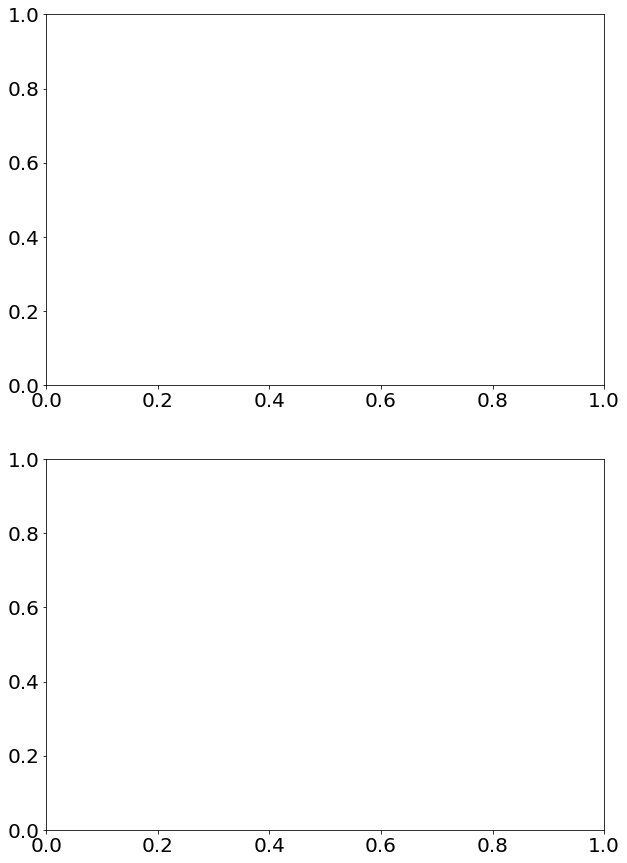

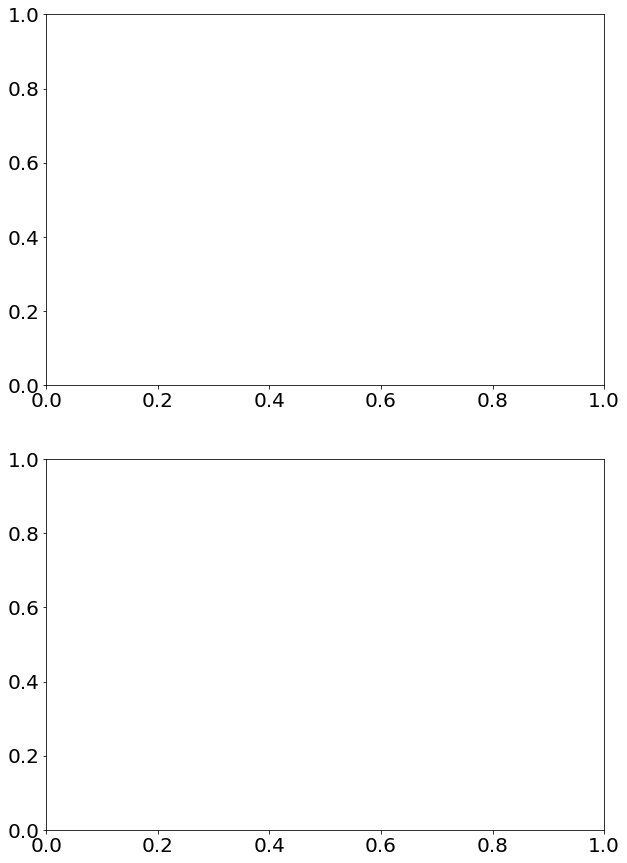

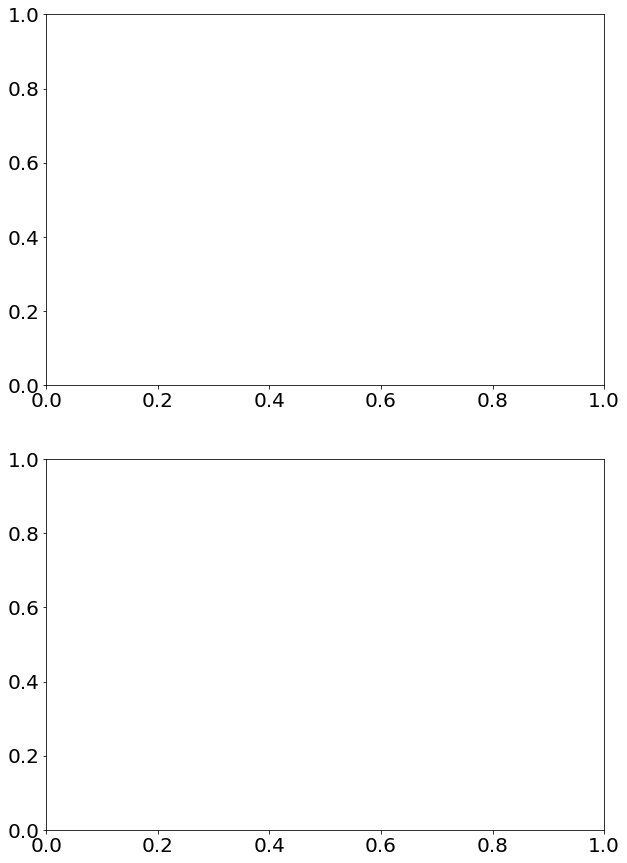

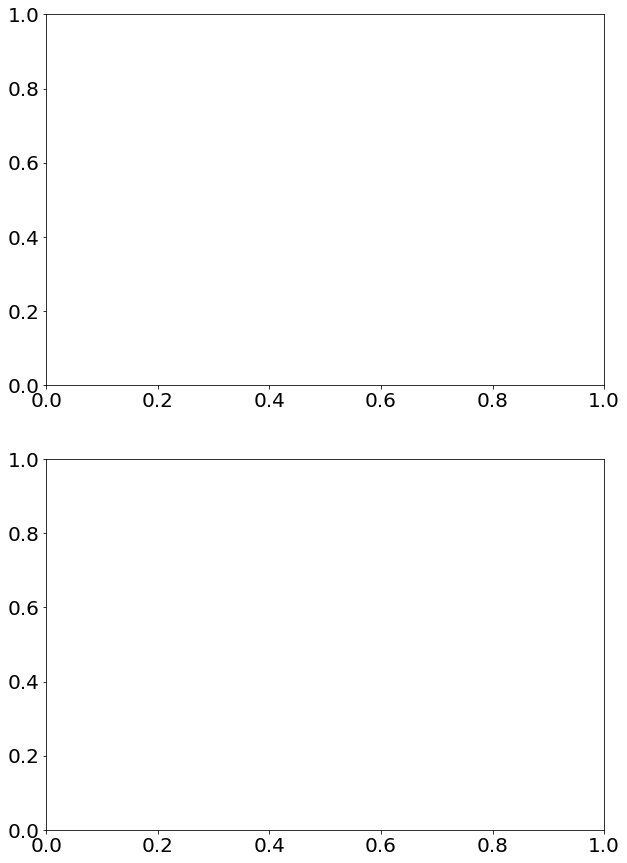

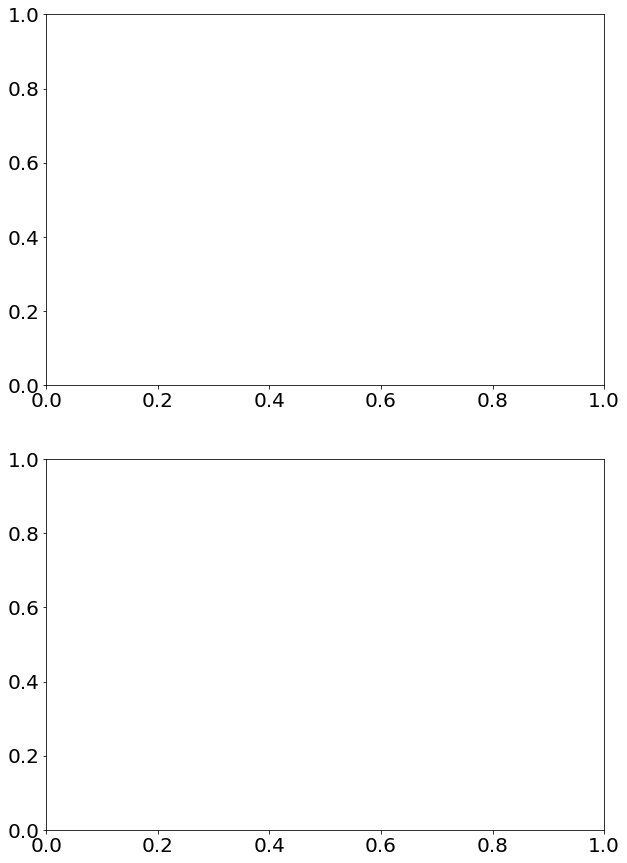

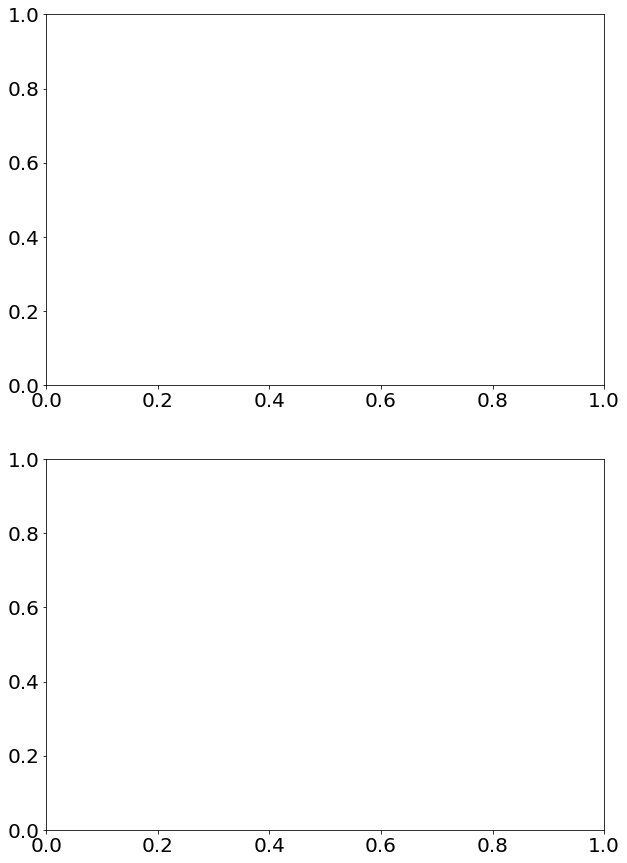

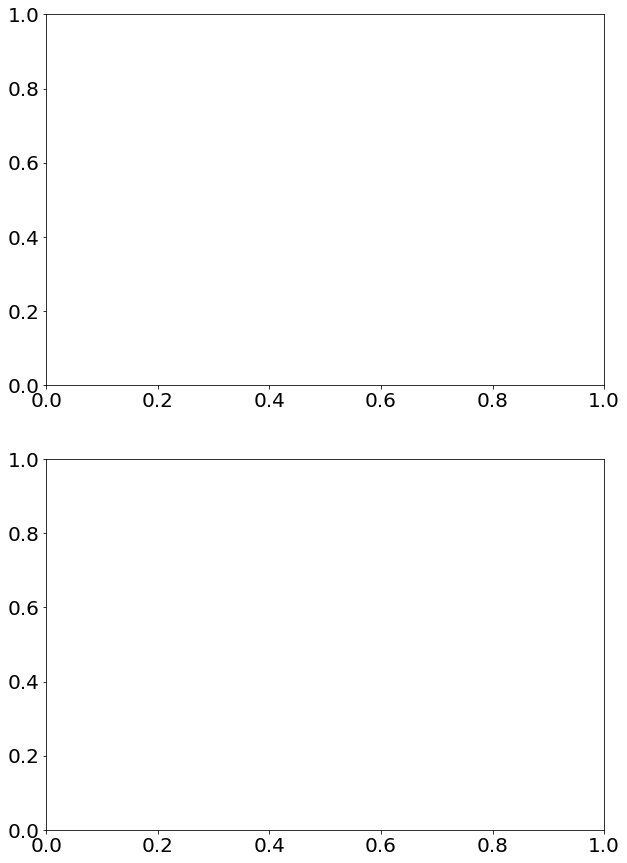

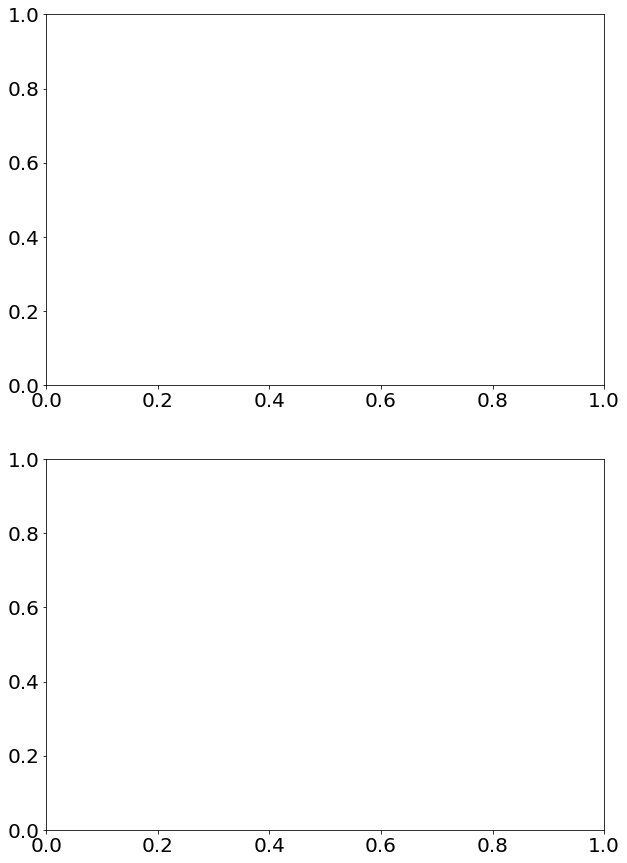

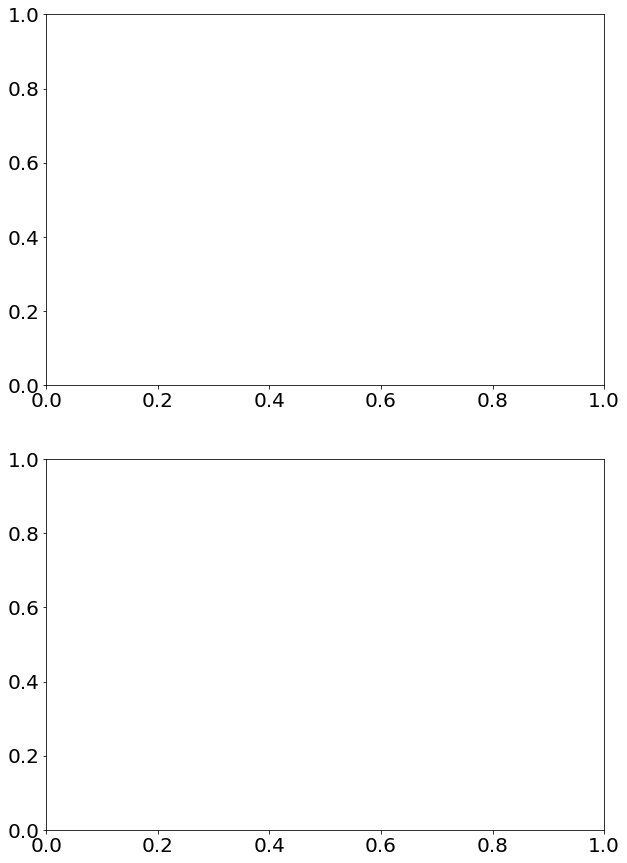

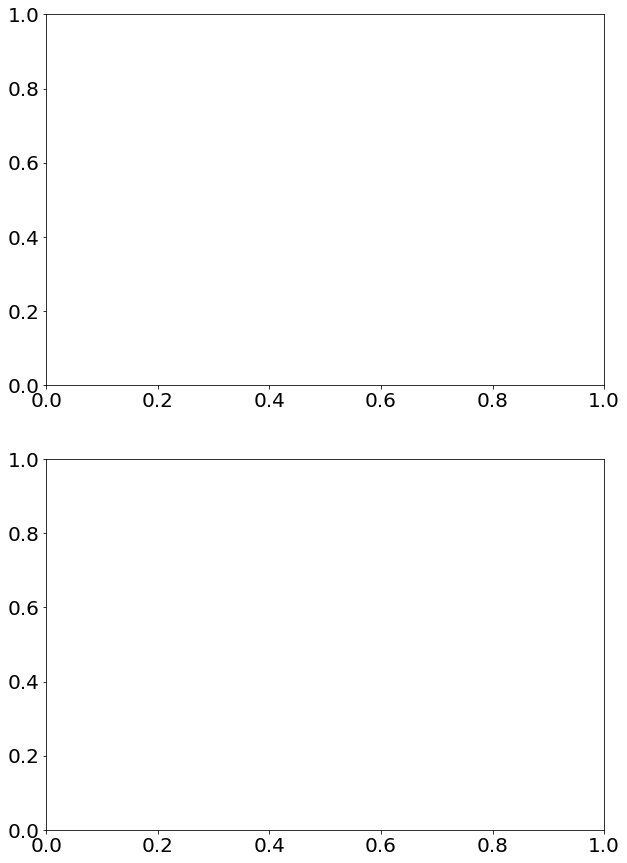

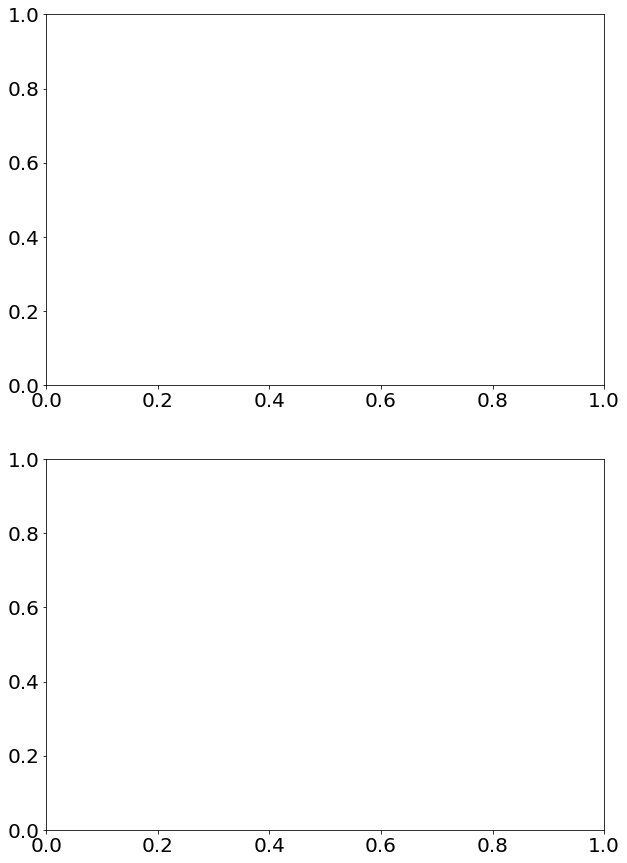

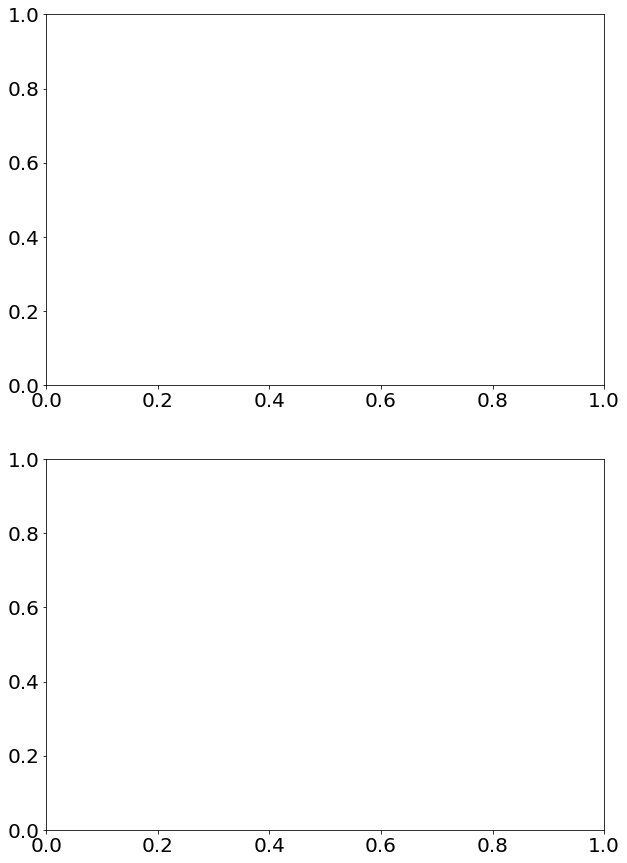

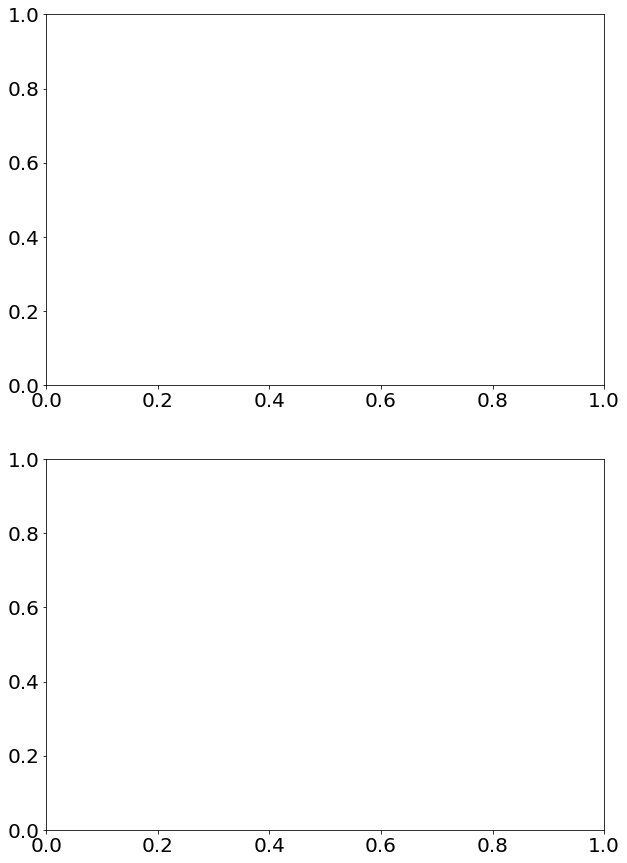

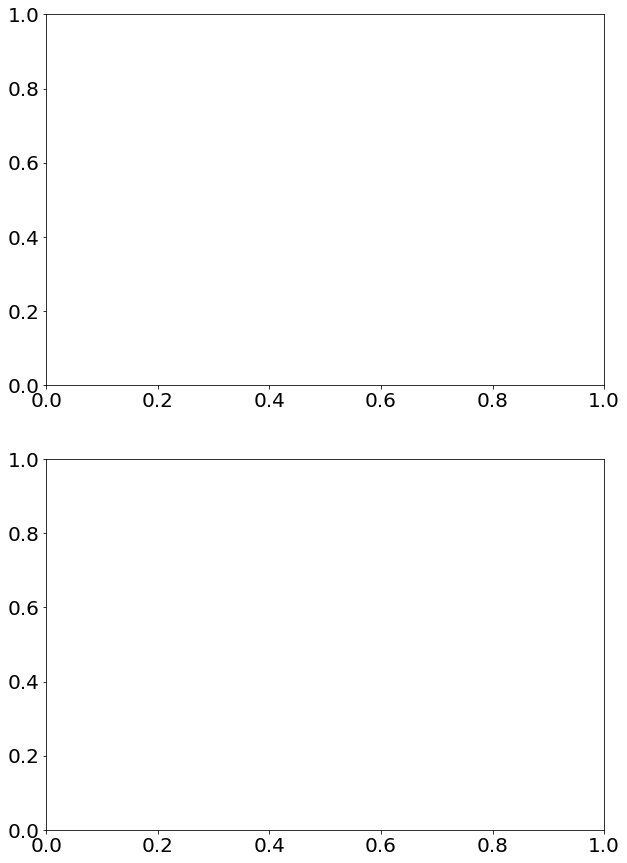

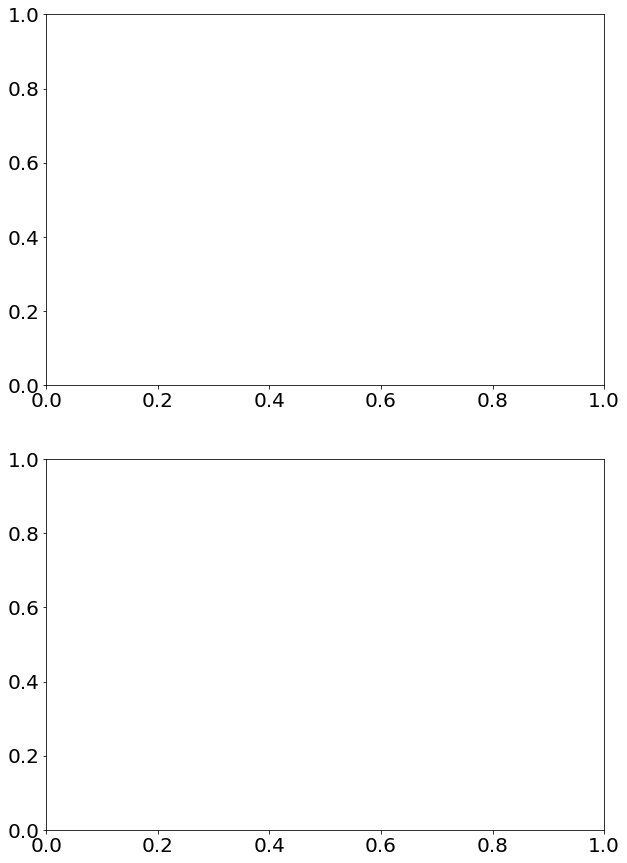

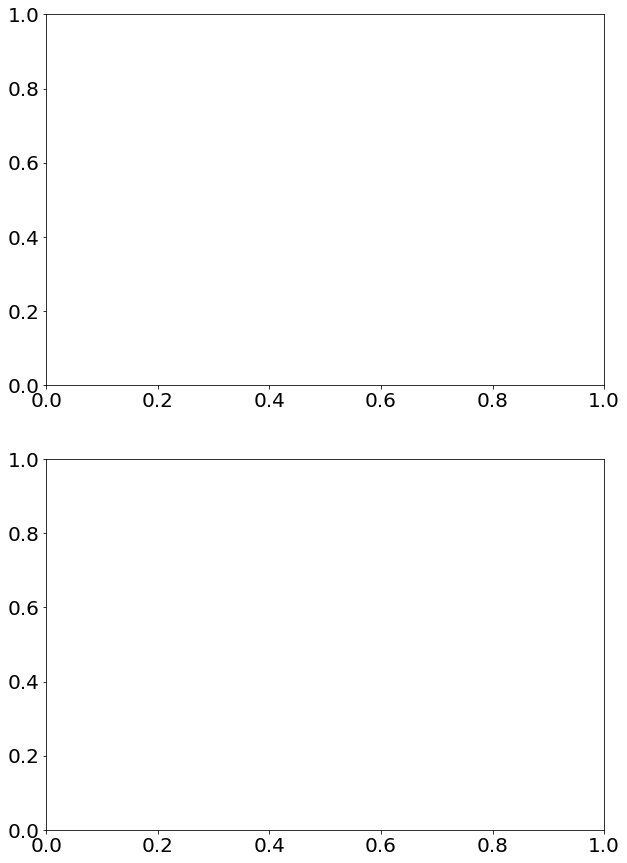

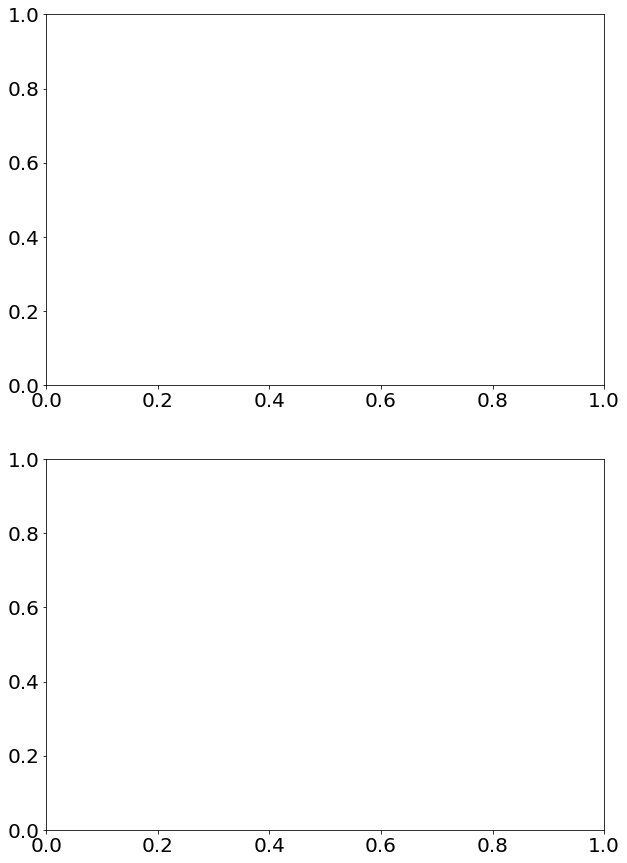

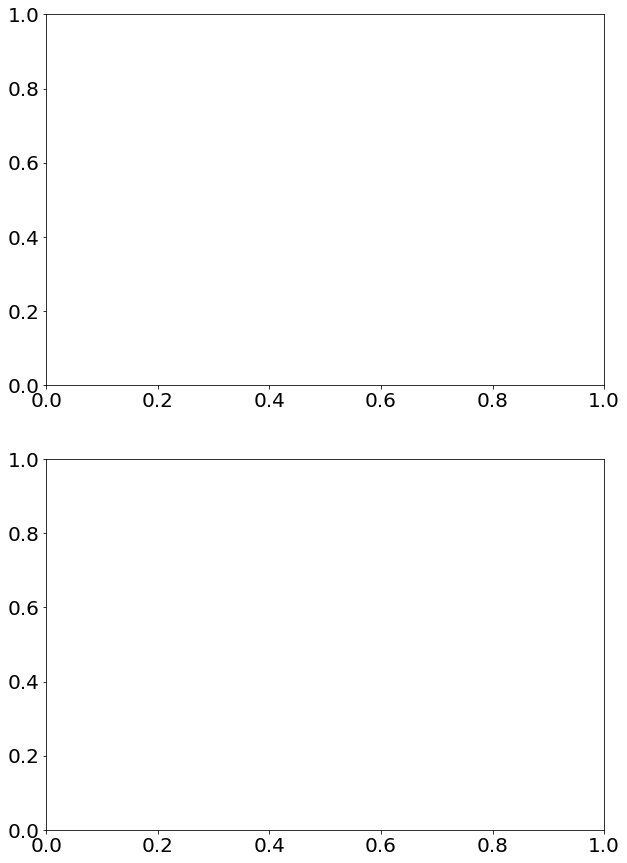

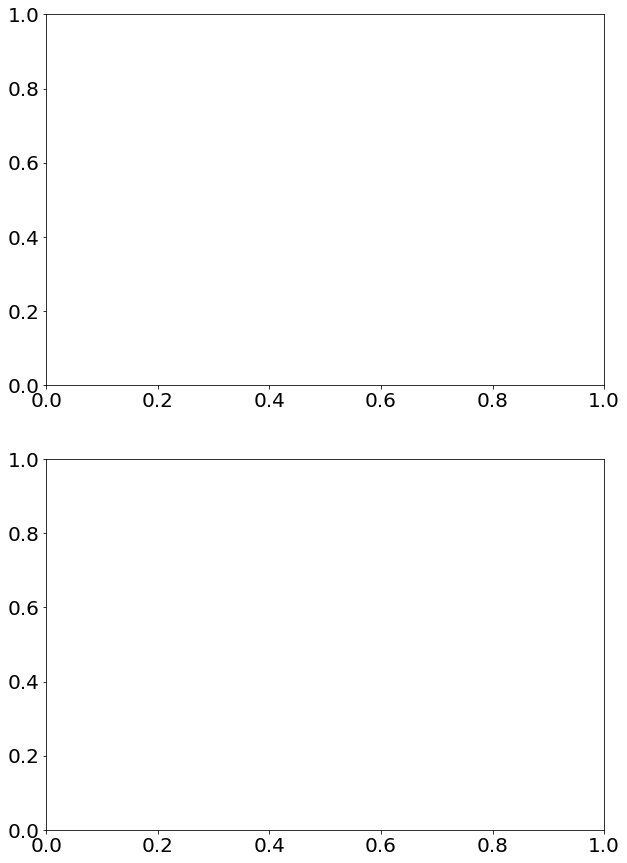

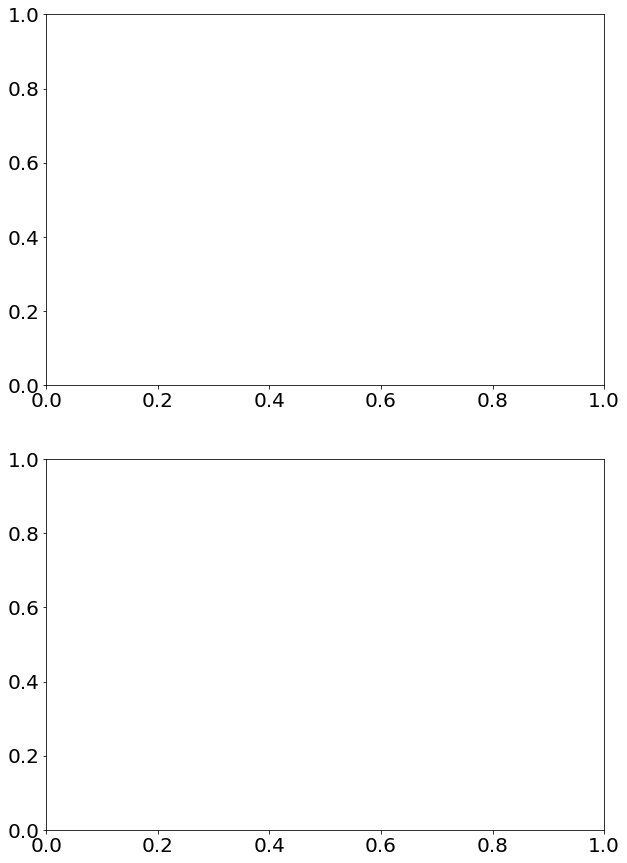

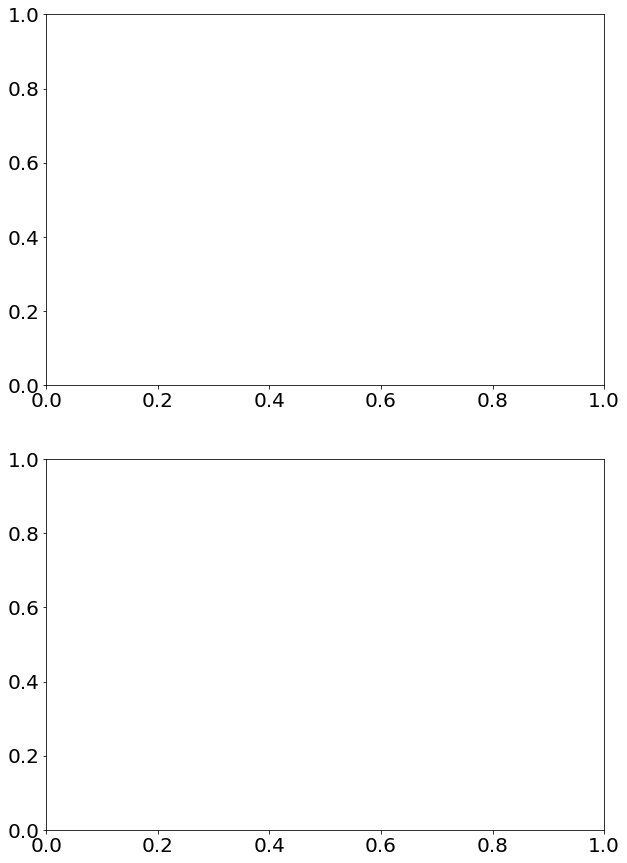

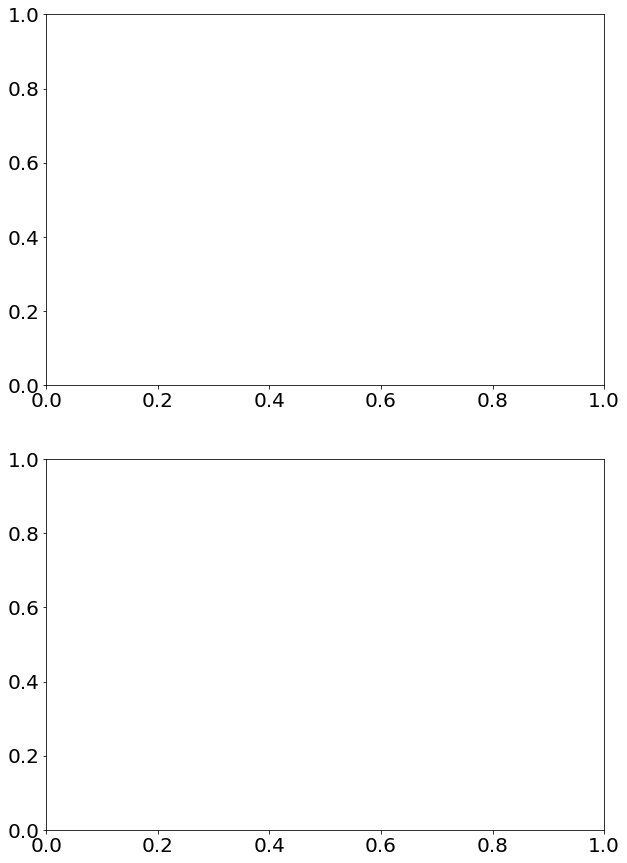

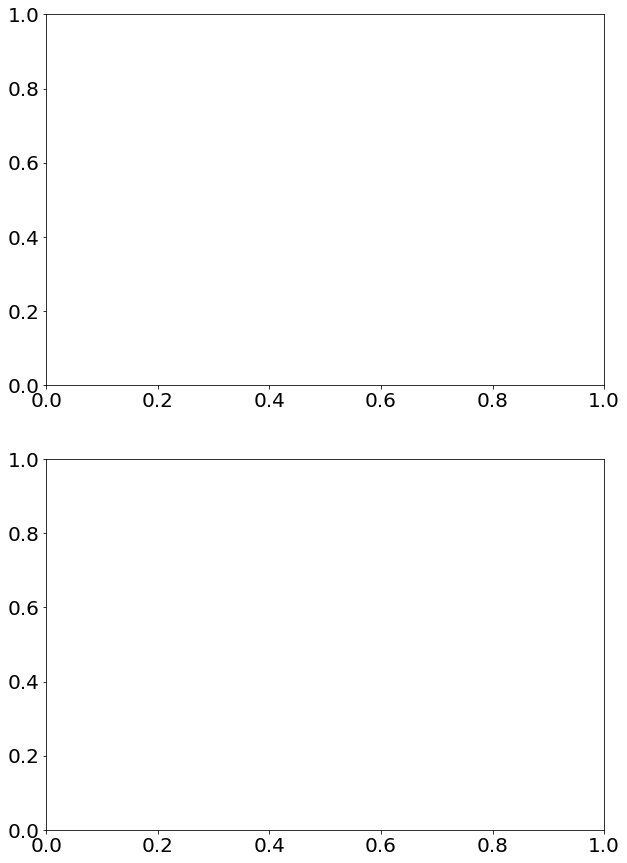

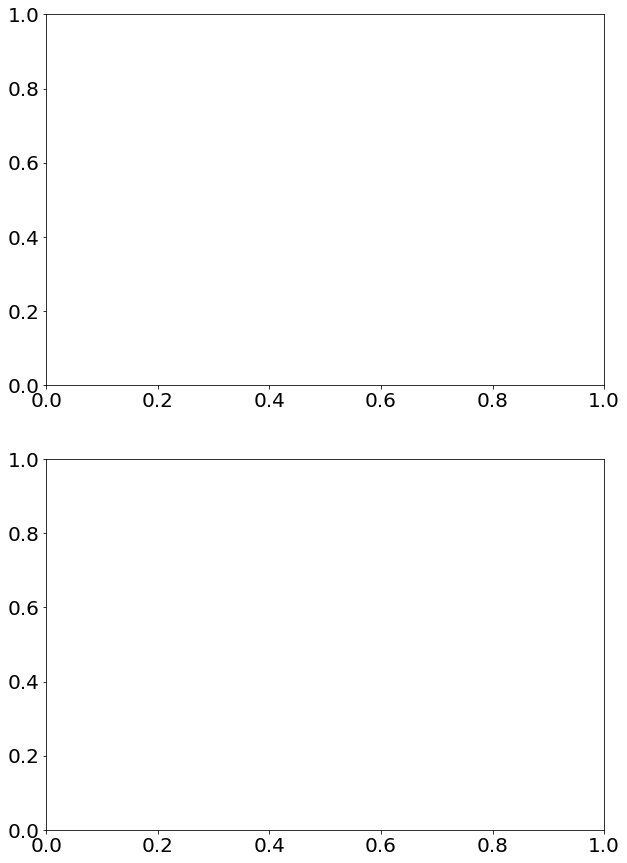

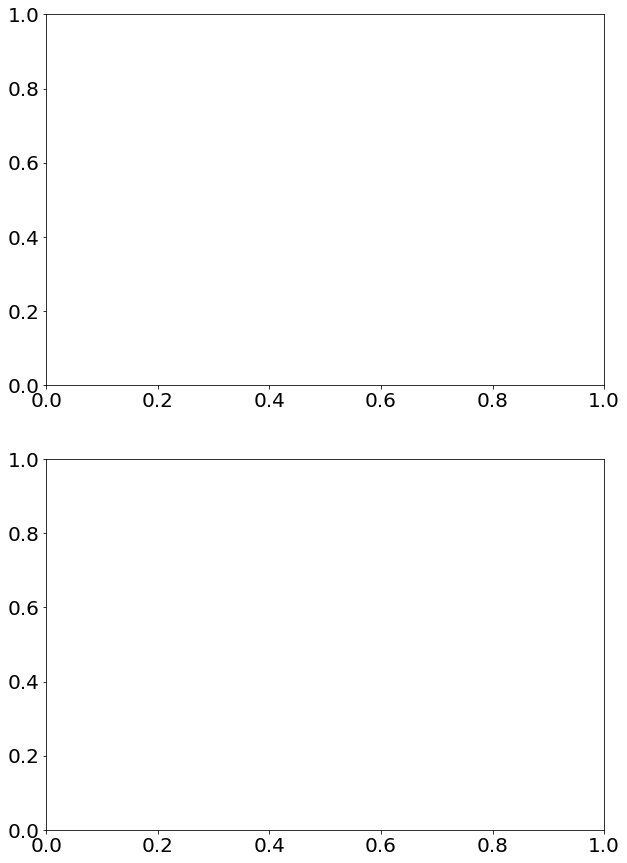

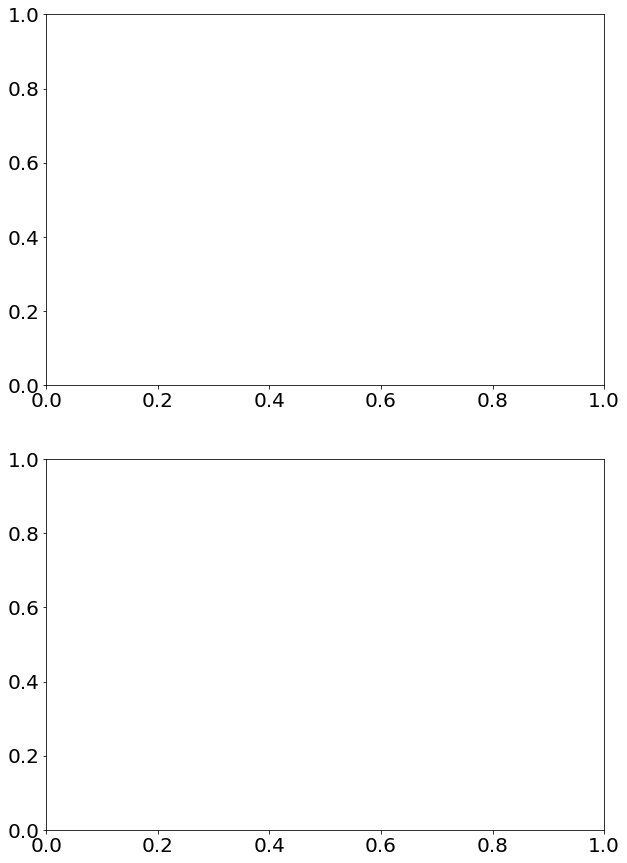

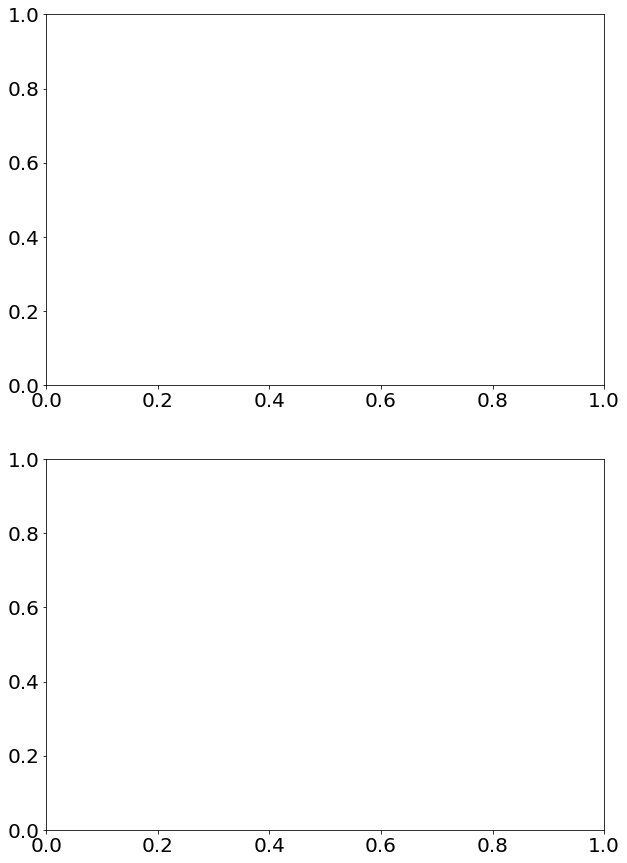

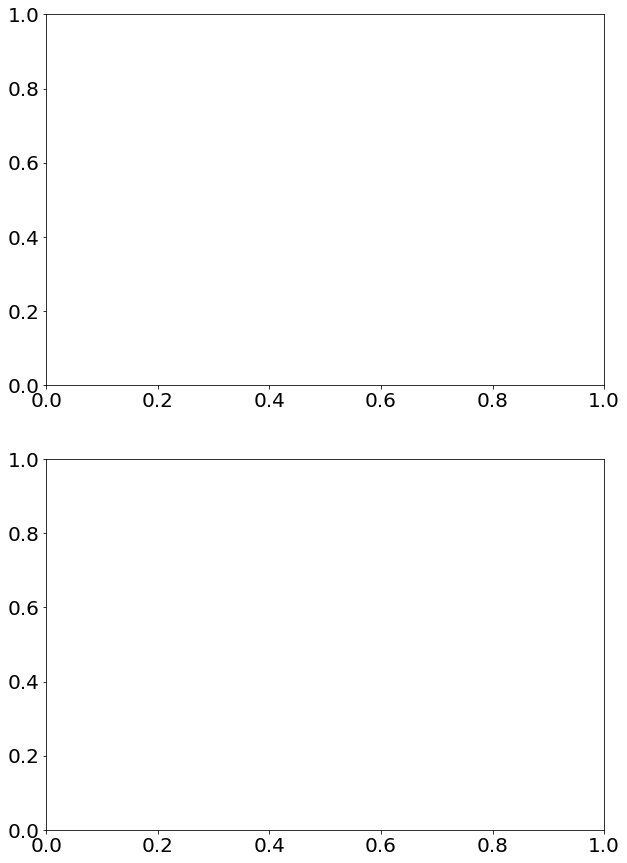

In [12]:
#full spectra and close up Halpha OSMOS targets:
days=[20180111,20180112,20180113,20180114,20180115,20180116,20180117,20180118,20180119,20180120,20180121,
      20180122,20180123,20180124,20180125,20180126,20180127,20180128,20180204,20180205,20180206,20180207,
      20180208,20180209]

flist = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/CSCU_reductions/2018*/finals/trim.*'))
for exp in flist:
    plot = plt.figure(figsize=(10,15))
    ax_close = plt.subplot(211)
    ax_wide = plt.subplot(212)
    exposure = exp.split('/')[9].split('.')[2]
    date = exp.split('/')[7]
    name = exp.split('/')[9].split('.')[1]
    if name[-4:] == 'comb':
        continue
            
    if exposure == 'fits':
        w,f,v = read_mdm(exp)
        norm_reg = (w>6565) & (w<6576)
        norm_by = np.median(f[norm_reg])
        plot_spec_wide_close(w,f/norm_by,v/norm_by,ax=ax_close,wmin=6540,wmax=6580)
        ax_wide.vlines(x = 6563, ymin = 0, ymax = 5, color = 'grey', linestyle = 'dashed')
        
        plot_spec_wide_close(w,f/norm_by,v/norm_by,ax=ax_wide,wmin=6000,wmax=8000)
        ax_close.vlines(x = 6563, ymin = 0, ymax = 5, color = 'grey', linestyle = 'dashed')
        
        plt.savefig('/Users/amandaash/Desktop/Research/plots/exposure_spectra/{0}_{1}.pdf'.format(name,date), bbox = 'tight')
            
        
    else:
        w,f,v = read_mdm(exp)
        norm_reg = (w>6565) & (w<6576)
        norm_by = np.median(f[norm_reg])
        plot_spec_wide_close(w,f/norm_by,v/norm_by,ax=ax_close,wmin=6540,wmax=6580)            
        ax_wide.vlines(x = 6563, ymin = 0, ymax = 5, color = 'grey', linestyle = 'dashed')    
        plot_spec_wide_close(w,f/norm_by,v/norm_by,ax=ax_wide,wmin=6000,wmax=8000)
            
        plt.savefig('/Users/amandaash/Desktop/Research/plots/exposure_spectra/{0}_{1}_{2}.pdf'.format(name,date, exposure), bbox = 'tight')
    plt.close()

        